In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from category_encoders import BinaryEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score


font_path = '../Font/GmarketSansTTFMedium.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

plt.rcParams['axes.unicode_minus'] = False

In [2]:
seoul = pd.read_csv('../Data/preprocessing/seoul_real_transcation_price.csv')

In [3]:
seoul.head(5)

,시도명,시군구명,관리기관,회사명,공장구분,단지명,설립구분,입주형태,보유구분,등록구분,...,지식산업센터명,대표업종,업종명,업종코드,차수,법인주소,필지수,공장주소,공장주소_지번,공장관리번호
0,서울특별시,종로구,서울특별시 종로구,남일문화 (주),개별,,일반,해당없음,임대,신규등록,...,,18111,경 인쇄업 외 2 종,"181,111,811,318,119",10,서울특별시 종로구 자하문로16길 8 (창성동),1,서울특별시 종로구 자하문로16길 8 (창성동),서울특별시 종로구 창성동 87-1번지,1.110000e+14
1,서울특별시,종로구,서울특별시 종로구,(주)에취.알.디,개별,,일반,해당없음,임대,등록변경,...,,33932,전시용 모형 제조업,33932,10,서울특별시 종로구 통의동 35-69번지,1,서울특별시 종로구 통의동 35-69번지,서울특별시 종로구 통의동 35-69번지,1.110000e+14
2,서울특별시,종로구,서울특별시 종로구,(주)코리아쉬핑가제트,개별,,일반,해당없음,자가,등록변경,...,,58113,일반 서적 출판업 외 3 종,"58,113,181,111,811,300,000",10,서울특별시 도봉구 창동 181-17번지 쌍용아파트 115-1902,1,서울특별시 종로구 자하문로2길 13-3 (통의동),서울특별시 종로구 통의동 35-6번지,1.110000e+14
3,서울특별시,종로구,서울특별시 종로구,삼영DP,개별,,일반,해당없음,임대,신규등록,...,,18111,경 인쇄업 외 2 종,"181,111,811,318,119",10,서울특별시 종로구 사직로 125 (적선동),1,서울특별시 종로구 사직로 125 (적선동),서울특별시 종로구 적선동 107-1번지,1.110000e+14
4,서울특별시,종로구,서울특별시 종로구,삼진기획,개별,,일반,해당없음,임대,등록변경,...,,18119,기타 인쇄업 외 1 종,"1,811,918,113",10,서울특별시 서대문구 홍제동 -번지 문화촌현대아파트 103-1101호,1,서울특별시 종로구 적선동 2번지,서울특별시 종로구 적선동 2번지,1.110000e+14


In [4]:
seoul.columns

Index(['시도명', '시군구명', '관리기관', '회사명', '공장구분', '단지명', '설립구분', '입주형태', '보유구분',
       '등록구분', '전화번호', '남자종업원', '여자종업원', '외국인남자종업원', '외국인여자종업원', '종업원합계',
       '생산품', '원자재', '공장규모', '용도지역', '지목', '용지면적', '제조시설면적', '부대시설면적', '건축면적',
       '지식산업센터명', '대표업종', '업종명', '업종코드', '차수', '법인주소', '필지수', '공장주소',
       '공장주소_지번', '공장관리번호'],
      dtype='object')

In [5]:
seoul = seoul.drop(columns=['시도명', '시군구명', '관리기관', '회사명', '단지명', '전화번호', '법인주소', '필지수', '공장주소', '공장관리번호']) #1차
seoul = seoul.drop(columns=['생산품', '원자재', '업종명', '업종코드', '차수']) #2차

### 공장주소_지번을 시, 구, 동으로 구분하기

In [6]:
address = seoul['공장주소_지번'].str.split(n=2, expand=True)
address[2] = address[2].str.split().str[0] #남은 부분에서 첫번째만 분리

print(address)

address.columns = ['시', '구', '동']
seoul = pd.concat([seoul, address[['시', '구', '동']]], axis=1)
seoul = seoul.drop(columns=['공장주소_지번', '시', '동'])


           0    1    2
0      서울특별시  종로구  창성동
1      서울특별시  종로구  통의동
2      서울특별시  종로구  통의동
3      서울특별시  종로구  적선동
4      서울특별시  종로구  적선동
...      ...  ...  ...
11628  서울특별시  강동구  천호동
11629  서울특별시  강동구  천호동
11630  서울특별시  강동구  천호동
11631  서울특별시  강동구  천호동
11632  서울특별시  강동구  천호동

[11633 rows x 3 columns]


In [7]:
object_columns = ['공장구분', '설립구분', '입주형태', '보유구분', '등록구분', '공장규모', '용도지역', '지목', '지식산업센터명', '대표업종', '구']
int_columns = ['남자종업원', '여자종업원', '외국인남자종업원', '외국인여자종업원', '종업원합계','용지면적', '제조시설면적', '부대시설면적', '건축면적']

In [8]:
# object 타입 변환
for column in object_columns:
    seoul[column] = seoul[column].astype('object')

for column in int_columns:
    seoul[column] = seoul[column].astype('int')

In [9]:
seoul['입주형태'] = seoul['입주형태'].str.strip() # 공백제거
seoul['입주형태'].replace('', '해당없음', inplace=True)
seoul['입주형태'].fillna('해당없음', inplace=True)

In [ ]:
seoul['용도지역'] = seoul['용도지역'].str.strip() # 공백제거
seoul['용도지역'].replace('', '해당없음', inplace=True)
seoul['용도지역'].fillna('해당없음', inplace=True)

In [10]:
seoul['지목'] = seoul['지목'].str.strip() # 공백제거
seoul['지목'].replace('', '해당없음', inplace=True)
seoul['지목'].fillna('해당없음', inplace=True)

In [11]:
seoul['지식산업센터명'] = seoul['지식산업센터명'].str.strip() # 공백제거
seoul['지식산업센터명'].replace('', '해당없음', inplace=True)
seoul['지식산업센터명'].fillna('해당없음', inplace=True)

In [12]:
label_encoders = {}
for column in seoul.select_dtypes(include=['object']).columns:
    if column != '구':
        label_encoders[column] = LabelEncoder()
        seoul[column] = label_encoders[column].fit_transform(seoul[column])

# '구' 칼럼 라벨 인코딩
label_encoder_gu = LabelEncoder()
seoul['구'] = label_encoder_gu.fit_transform(seoul['구'])


In [13]:
X = seoul.drop(columns=['구'])
y = seoul['구']

In [14]:
print(X.shape, y.shape)

(11633, 19) (11633,)


In [15]:
X

,공장구분,설립구분,입주형태,보유구분,등록구분,남자종업원,여자종업원,외국인남자종업원,외국인여자종업원,종업원합계,공장규모,용도지역,지목,용지면적,제조시설면적,부대시설면적,건축면적,지식산업센터명,대표업종
0,0,1,8,0,2,0,0,0,0,0,1,57,2,238,57,69,126,223,105
1,0,1,8,0,0,5,2,0,0,7,1,78,2,157,79,78,157,223,396
2,0,1,8,1,0,12,12,0,0,24,1,78,2,160,92,67,160,223,422
3,0,1,8,0,2,0,0,0,0,0,1,59,2,280,35,88,123,223,105
4,0,1,8,0,0,7,2,0,0,9,1,34,2,122,159,18,177,223,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11628,0,1,5,0,0,1,4,0,0,5,1,58,2,104,104,0,104,223,68
11629,0,1,8,1,0,0,0,0,0,0,1,78,2,164,110,53,164,223,384
11630,0,1,5,0,0,7,0,0,0,7,1,58,2,125,114,11,125,223,77
11631,0,1,5,0,2,2,3,0,0,5,1,74,2,104,104,0,104,223,42


In [16]:
y.value_counts()

7     3455
15    1357
6     1215
23    1190
19     845
3      642
17     428
24     341
10     265
0      228
14     208
5      174
22     166
9      155
1      129
18     108
8      105
16     103
12     102
21      94
2       89
20      77
4       65
13      52
11      40
Name: 구, dtype: int64

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(7910, 19) (1978, 19) (1745, 19) (7910,) (1978,) (1745,)


In [18]:
## label encoding
from sklearn.preprocessing import LabelEncoder
categorical_features = list(X_train.dtypes[X_train.dtypes == 'object'.index])

# 라벨 인코딩 호기화
le = LabelEncoder()

# Label encoding 적용
for feature in categorical_features:
    X_train[feature] = le.fit_transform(X_train[feature])
    X_val[feature] = le.fit_transform(X_val[feature])
    X_test[feature] = le.fit_transform(X_test[feature])

In [19]:
print(X_train.info(), X.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7910 entries, 2548 to 5416
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   공장구분      7910 non-null   int32
 1   설립구분      7910 non-null   int32
 2   입주형태      7910 non-null   int32
 3   보유구분      7910 non-null   int32
 4   등록구분      7910 non-null   int32
 5   남자종업원     7910 non-null   int32
 6   여자종업원     7910 non-null   int32
 7   외국인남자종업원  7910 non-null   int32
 8   외국인여자종업원  7910 non-null   int32
 9   종업원합계     7910 non-null   int32
 10  공장규모      7910 non-null   int32
 11  용도지역      7910 non-null   int32
 12  지목        7910 non-null   int32
 13  용지면적      7910 non-null   int32
 14  제조시설면적    7910 non-null   int32
 15  부대시설면적    7910 non-null   int32
 16  건축면적      7910 non-null   int32
 17  지식산업센터명   7910 non-null   int32
 18  대표업종      7910 non-null   int32
dtypes: int32(19)
memory usage: 648.9 KB
None 공장구분        0
설립구분        0
입주형태        0
보유구분        0
등록구분       

In [20]:
X_train

,공장구분,설립구분,입주형태,보유구분,등록구분,남자종업원,여자종업원,외국인남자종업원,외국인여자종업원,종업원합계,공장규모,용도지역,지목,용지면적,제조시설면적,부대시설면적,건축면적,지식산업센터명,대표업종
2548,0,1,8,1,2,10,1,2,0,13,1,9,2,495,245,54,299,223,165
5896,1,0,4,1,3,32,6,1,0,39,1,9,0,208,816,636,1452,96,250
2660,0,1,8,0,0,5,12,0,0,17,1,11,2,904,72,26,98,223,65
8386,1,3,4,1,3,2,9,0,0,11,1,9,0,66,271,175,446,172,62
3536,0,1,5,0,2,4,0,0,0,4,1,58,2,0,131,160,292,223,268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4166,0,1,5,0,0,1,2,0,0,3,1,1,2,170,22,148,170,223,39
9825,0,1,8,0,3,24,1,0,0,25,1,9,0,601,412,220,632,223,347
4383,0,1,8,1,3,11,2,0,0,13,1,9,2,359,0,110,110,223,229
1315,0,1,5,0,2,1,1,0,0,2,1,34,0,0,65,0,65,69,64


In [21]:
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import os

In [22]:
# 결과를 CSV 파일에 저장하는 콜백 함수
def save_trial_to_csv(study, trial, model_name):
    header = ['Trial Number', 'Model', 'Params', 'Value']
    file_exists = os.path.isfile('optuna_trials.csv')
    
    with open('optuna_trials.csv', mode='a', newline='') as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(header)
        
        params = trial.params
        writer.writerow([trial.number, model_name, params, trial.value])


In [23]:
# Optuna 목적 함수 - XGBoost
def objective_xgb(trial, X_train, y_train, X_val, y_val):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10)
    }
    model = XGBClassifier(**params, use_label_encoder=False)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='mlogloss',
              early_stopping_rounds=10,
              verbose=False)
    score = model.score(X_val, y_val)
    return score

In [24]:
# Optuna 목적 함수 - LightGBM
def objective_lgbm(trial, X_train, y_train, X_val, y_val):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'min_split_gain': trial.suggest_float('min_split_gain', 0, 10)
    }
    model = LGBMClassifier(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='multi_logloss'
    )
    
    # Manual early stopping implementation
    early_stopping_rounds = 10
    best_iteration = len(model.evals_result_['valid_0']['multi_logloss']) - 1
    for i in range(len(model.evals_result_['valid_0']['multi_logloss']) - early_stopping_rounds):
        if model.evals_result_['valid_0']['multi_logloss'][i] < min(model.evals_result_['valid_0']['multi_logloss'][i+1:i+early_stopping_rounds+1]):
            best_iteration = i
            break
    
    model.set_params(n_estimators=best_iteration + 1)
    model.fit(X_train, y_train)  # Refit the model with the best iteration
    
    score = model.score(X_val, y_val)
    return score

In [25]:
# XGBoost 하이퍼파라미터 최적화
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(lambda trial: objective_xgb(trial, X_train, y_train, X_val, y_val), n_trials=100, callbacks=[lambda study, trial: save_trial_to_csv(study, trial, 'XGBoost')])

[I 2024-06-22 00:53:29,545] A new study created in memory with name: no-name-c45b426b-3eb5-45db-99fc-32967329e661
c:\Users\vivid\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\vivid\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-22 00:53:33,630] Trial 0 finished with value: 0.5005055611729019 and parameters: {'max_depth': 4, 'learning_rate': 1.2500115954500597e-06, 'n_estimators': 279, 'subsample': 0.6205118862722128, 'colsample_bytree': 0.6933599810702264, 'gamma': 1.1393923902055292, 'min_child_weight': 9, 'reg_alpha': 3.065324466092696, 'reg_lambda': 5.359354062386582}. Best is trial 0 with

In [26]:
# LightGBM 하이퍼파라미터 최적화
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(lambda trial: objective_lgbm(trial, X_train, y_train, X_val, y_val), n_trials=100, callbacks=[lambda study, trial: save_trial_to_csv(study, trial, 'LightGBM')])

[I 2024-06-22 00:56:49,363] A new study created in memory with name: no-name-b0dca660-617b-4734-a12a-04765df07cd5


[1]	valid_0's multi_logloss: 2.4891
[2]	valid_0's multi_logloss: 2.4891
[3]	valid_0's multi_logloss: 2.4891
[4]	valid_0's multi_logloss: 2.4891
[5]	valid_0's multi_logloss: 2.4891
[6]	valid_0's multi_logloss: 2.4891
[7]	valid_0's multi_logloss: 2.4891
[8]	valid_0's multi_logloss: 2.4891
[9]	valid_0's multi_logloss: 2.4891
[10]	valid_0's multi_logloss: 2.4891
[11]	valid_0's multi_logloss: 2.4891
[12]	valid_0's multi_logloss: 2.4891
[13]	valid_0's multi_logloss: 2.4891
[14]	valid_0's multi_logloss: 2.4891
[15]	valid_0's multi_logloss: 2.4891
[16]	valid_0's multi_logloss: 2.4891
[17]	valid_0's multi_logloss: 2.4891
[18]	valid_0's multi_logloss: 2.4891
[19]	valid_0's multi_logloss: 2.4891
[20]	valid_0's multi_logloss: 2.4891
[21]	valid_0's multi_logloss: 2.4891
[22]	valid_0's multi_logloss: 2.4891
[23]	valid_0's multi_logloss: 2.4891
[24]	valid_0's multi_logloss: 2.4891
[25]	valid_0's multi_logloss: 2.4891
[26]	valid_0's multi_logloss: 2.4891
[27]	valid_0's multi_logloss: 2.4891
[28]	valid

[I 2024-06-22 00:56:54,745] Trial 0 finished with value: 0.29575328614762386 and parameters: {'num_leaves': 30, 'learning_rate': 4.7832447567208256e-08, 'n_estimators': 227, 'min_child_samples': 27, 'subsample': 0.7748297888598397, 'colsample_bytree': 0.8371867257812168, 'reg_alpha': 0.2508179676045452, 'reg_lambda': 8.248656600951145, 'min_split_gain': 8.754357806380892}. Best is trial 0 with value: 0.29575328614762386.


[1]	valid_0's multi_logloss: 2.4891
[2]	valid_0's multi_logloss: 2.4891
[3]	valid_0's multi_logloss: 2.4891
[4]	valid_0's multi_logloss: 2.4891
[5]	valid_0's multi_logloss: 2.4891
[6]	valid_0's multi_logloss: 2.4891
[7]	valid_0's multi_logloss: 2.4891
[8]	valid_0's multi_logloss: 2.4891
[9]	valid_0's multi_logloss: 2.4891
[10]	valid_0's multi_logloss: 2.4891
[11]	valid_0's multi_logloss: 2.4891
[12]	valid_0's multi_logloss: 2.4891
[13]	valid_0's multi_logloss: 2.4891
[14]	valid_0's multi_logloss: 2.4891
[15]	valid_0's multi_logloss: 2.4891
[16]	valid_0's multi_logloss: 2.4891
[17]	valid_0's multi_logloss: 2.4891
[18]	valid_0's multi_logloss: 2.4891
[19]	valid_0's multi_logloss: 2.4891
[20]	valid_0's multi_logloss: 2.4891
[21]	valid_0's multi_logloss: 2.4891
[22]	valid_0's multi_logloss: 2.4891
[23]	valid_0's multi_logloss: 2.4891
[24]	valid_0's multi_logloss: 2.4891
[25]	valid_0's multi_logloss: 2.4891
[26]	valid_0's multi_logloss: 2.4891
[27]	valid_0's multi_logloss: 2.4891
[28]	valid

[I 2024-06-22 00:57:00,515] Trial 1 finished with value: 0.29575328614762386 and parameters: {'num_leaves': 136, 'learning_rate': 7.039339617195908e-08, 'n_estimators': 242, 'min_child_samples': 100, 'subsample': 0.9801650691260888, 'colsample_bytree': 0.6099735978374167, 'reg_alpha': 4.106556264389601, 'reg_lambda': 0.5870261604188343, 'min_split_gain': 6.3219743843147675}. Best is trial 0 with value: 0.29575328614762386.


[1]	valid_0's multi_logloss: 2.48478
[2]	valid_0's multi_logloss: 2.48052
[3]	valid_0's multi_logloss: 2.47614
[4]	valid_0's multi_logloss: 2.47192
[5]	valid_0's multi_logloss: 2.46728
[6]	valid_0's multi_logloss: 2.46308
[7]	valid_0's multi_logloss: 2.45883
[8]	valid_0's multi_logloss: 2.45441
[9]	valid_0's multi_logloss: 2.45033
[10]	valid_0's multi_logloss: 2.44661
[11]	valid_0's multi_logloss: 2.44241
[12]	valid_0's multi_logloss: 2.43867
[13]	valid_0's multi_logloss: 2.43457
[14]	valid_0's multi_logloss: 2.43044
[15]	valid_0's multi_logloss: 2.42675
[16]	valid_0's multi_logloss: 2.42298
[17]	valid_0's multi_logloss: 2.41887
[18]	valid_0's multi_logloss: 2.41531
[19]	valid_0's multi_logloss: 2.41145
[20]	valid_0's multi_logloss: 2.40729
[21]	valid_0's multi_logloss: 2.40352
[22]	valid_0's multi_logloss: 2.3996
[23]	valid_0's multi_logloss: 2.39557
[24]	valid_0's multi_logloss: 2.39212
[25]	valid_0's multi_logloss: 2.38862
[26]	valid_0's multi_logloss: 2.38511
[27]	valid_0's multi_l

[I 2024-06-22 00:57:03,783] Trial 2 finished with value: 0.3619817997977755 and parameters: {'num_leaves': 205, 'learning_rate': 0.0019352832253383032, 'n_estimators': 133, 'min_child_samples': 50, 'subsample': 0.5680112079007742, 'colsample_bytree': 0.7855875337035576, 'reg_alpha': 1.9841180077450193, 'reg_lambda': 7.504898221025472, 'min_split_gain': 8.305417081892076}. Best is trial 2 with value: 0.3619817997977755.


[1]	valid_0's multi_logloss: 2.29697
[2]	valid_0's multi_logloss: 3.30268
[3]	valid_0's multi_logloss: 2.85153
[4]	valid_0's multi_logloss: 2.38289
[5]	valid_0's multi_logloss: 2.25307
[6]	valid_0's multi_logloss: 2.14463
[7]	valid_0's multi_logloss: 2.0666
[8]	valid_0's multi_logloss: 2.00258
[9]	valid_0's multi_logloss: 1.94307
[10]	valid_0's multi_logloss: 1.88847
[11]	valid_0's multi_logloss: 1.8465
[12]	valid_0's multi_logloss: 1.81359
[13]	valid_0's multi_logloss: 1.77202
[14]	valid_0's multi_logloss: 1.73962
[15]	valid_0's multi_logloss: 1.71581
[16]	valid_0's multi_logloss: 1.6956
[17]	valid_0's multi_logloss: 1.67458
[18]	valid_0's multi_logloss: 1.65815
[19]	valid_0's multi_logloss: 1.63852
[20]	valid_0's multi_logloss: 1.62438
[21]	valid_0's multi_logloss: 1.60797
[22]	valid_0's multi_logloss: 1.59142
[23]	valid_0's multi_logloss: 1.57745
[24]	valid_0's multi_logloss: 1.56059
[25]	valid_0's multi_logloss: 1.54649
[26]	valid_0's multi_logloss: 1.53331
[27]	valid_0's multi_log

[I 2024-06-22 00:57:06,533] Trial 3 finished with value: 0.37209302325581395 and parameters: {'num_leaves': 9, 'learning_rate': 0.12031712307038056, 'n_estimators': 224, 'min_child_samples': 70, 'subsample': 0.5335305425852388, 'colsample_bytree': 0.5149222919898352, 'reg_alpha': 9.41147637401712, 'reg_lambda': 0.11574773246349479, 'min_split_gain': 0.49991290241634734}. Best is trial 3 with value: 0.37209302325581395.


[1]	valid_0's multi_logloss: 2.48909
[2]	valid_0's multi_logloss: 2.48907
[3]	valid_0's multi_logloss: 2.48905
[4]	valid_0's multi_logloss: 2.48904
[5]	valid_0's multi_logloss: 2.48903
[6]	valid_0's multi_logloss: 2.48901
[7]	valid_0's multi_logloss: 2.48899
[8]	valid_0's multi_logloss: 2.48897
[9]	valid_0's multi_logloss: 2.48896
[10]	valid_0's multi_logloss: 2.48894
[11]	valid_0's multi_logloss: 2.48892
[12]	valid_0's multi_logloss: 2.48891
[13]	valid_0's multi_logloss: 2.48889
[14]	valid_0's multi_logloss: 2.48887
[15]	valid_0's multi_logloss: 2.48886
[16]	valid_0's multi_logloss: 2.48884
[17]	valid_0's multi_logloss: 2.48882
[18]	valid_0's multi_logloss: 2.48881
[19]	valid_0's multi_logloss: 2.48879
[20]	valid_0's multi_logloss: 2.48878
[21]	valid_0's multi_logloss: 2.48876
[22]	valid_0's multi_logloss: 2.48875
[23]	valid_0's multi_logloss: 2.48873
[24]	valid_0's multi_logloss: 2.48871
[25]	valid_0's multi_logloss: 2.4887
[26]	valid_0's multi_logloss: 2.48868
[27]	valid_0's multi_l

[I 2024-06-22 00:57:08,867] Trial 4 finished with value: 0.29575328614762386 and parameters: {'num_leaves': 86, 'learning_rate': 8.472961951157469e-06, 'n_estimators': 109, 'min_child_samples': 71, 'subsample': 0.7939032663372548, 'colsample_bytree': 0.6788639641156059, 'reg_alpha': 3.138028706764543, 'reg_lambda': 9.352401132774895, 'min_split_gain': 9.993665634018098}. Best is trial 3 with value: 0.37209302325581395.


[1]	valid_0's multi_logloss: 2.48898
[2]	valid_0's multi_logloss: 2.48885
[3]	valid_0's multi_logloss: 2.48871
[4]	valid_0's multi_logloss: 2.4886
[5]	valid_0's multi_logloss: 2.48848
[6]	valid_0's multi_logloss: 2.48833
[7]	valid_0's multi_logloss: 2.48819
[8]	valid_0's multi_logloss: 2.48806
[9]	valid_0's multi_logloss: 2.48792
[10]	valid_0's multi_logloss: 2.48778
[11]	valid_0's multi_logloss: 2.48767
[12]	valid_0's multi_logloss: 2.48753
[13]	valid_0's multi_logloss: 2.48739
[14]	valid_0's multi_logloss: 2.48727
[15]	valid_0's multi_logloss: 2.48713
[16]	valid_0's multi_logloss: 2.487
[17]	valid_0's multi_logloss: 2.48686
[18]	valid_0's multi_logloss: 2.48676
[19]	valid_0's multi_logloss: 2.48663
[20]	valid_0's multi_logloss: 2.4865
[21]	valid_0's multi_logloss: 2.48639
[22]	valid_0's multi_logloss: 2.48625
[23]	valid_0's multi_logloss: 2.48613
[24]	valid_0's multi_logloss: 2.48599
[25]	valid_0's multi_logloss: 2.48585
[26]	valid_0's multi_logloss: 2.48572
[27]	valid_0's multi_logl

[I 2024-06-22 00:57:12,550] Trial 5 finished with value: 0.29575328614762386 and parameters: {'num_leaves': 13, 'learning_rate': 6.569590084091433e-05, 'n_estimators': 169, 'min_child_samples': 80, 'subsample': 0.6583709510097135, 'colsample_bytree': 0.6565617916002795, 'reg_alpha': 5.162723078435738, 'reg_lambda': 6.5583818801064915, 'min_split_gain': 3.418277444142801}. Best is trial 3 with value: 0.37209302325581395.


[1]	valid_0's multi_logloss: 2.50235
[2]	valid_0's multi_logloss: 2.50223
[3]	valid_0's multi_logloss: 2.50213
[4]	valid_0's multi_logloss: 2.50202
[5]	valid_0's multi_logloss: 2.5019
[6]	valid_0's multi_logloss: 2.50177
[7]	valid_0's multi_logloss: 2.50164
[8]	valid_0's multi_logloss: 2.50151
[9]	valid_0's multi_logloss: 2.50138
[10]	valid_0's multi_logloss: 2.50124
[11]	valid_0's multi_logloss: 2.50114
[12]	valid_0's multi_logloss: 2.50101
[13]	valid_0's multi_logloss: 2.50087
[14]	valid_0's multi_logloss: 2.50075
[15]	valid_0's multi_logloss: 2.50062
[16]	valid_0's multi_logloss: 2.5005
[17]	valid_0's multi_logloss: 2.50036
[18]	valid_0's multi_logloss: 2.50028
[19]	valid_0's multi_logloss: 2.50016
[20]	valid_0's multi_logloss: 2.50005
[21]	valid_0's multi_logloss: 2.49995
[22]	valid_0's multi_logloss: 2.49981
[23]	valid_0's multi_logloss: 2.4997
[24]	valid_0's multi_logloss: 2.49957
[25]	valid_0's multi_logloss: 2.49943
[26]	valid_0's multi_logloss: 2.49929
[27]	valid_0's multi_log

[I 2024-06-22 00:57:14,231] Trial 6 finished with value: 0.29575328614762386 and parameters: {'num_leaves': 132, 'learning_rate': 5.880394429754236e-05, 'n_estimators': 59, 'min_child_samples': 96, 'subsample': 0.7262292246907633, 'colsample_bytree': 0.5739194595496242, 'reg_alpha': 6.6970744796383554, 'reg_lambda': 1.89005104898047, 'min_split_gain': 3.3919445327871722}. Best is trial 3 with value: 0.37209302325581395.


[1]	valid_0's multi_logloss: 2.48909
[2]	valid_0's multi_logloss: 2.48908
[3]	valid_0's multi_logloss: 2.48906
[4]	valid_0's multi_logloss: 2.48905
[5]	valid_0's multi_logloss: 2.48904
[6]	valid_0's multi_logloss: 2.48902
[7]	valid_0's multi_logloss: 2.48901
[8]	valid_0's multi_logloss: 2.489
[9]	valid_0's multi_logloss: 2.48898
[10]	valid_0's multi_logloss: 2.48897
[11]	valid_0's multi_logloss: 2.48896
[12]	valid_0's multi_logloss: 2.48895
[13]	valid_0's multi_logloss: 2.48893
[14]	valid_0's multi_logloss: 2.48892
[15]	valid_0's multi_logloss: 2.48891
[16]	valid_0's multi_logloss: 2.48889
[17]	valid_0's multi_logloss: 2.48888
[18]	valid_0's multi_logloss: 2.48887
[19]	valid_0's multi_logloss: 2.48885
[20]	valid_0's multi_logloss: 2.48884
[21]	valid_0's multi_logloss: 2.48883
[22]	valid_0's multi_logloss: 2.48882
[23]	valid_0's multi_logloss: 2.4888
[24]	valid_0's multi_logloss: 2.48879
[25]	valid_0's multi_logloss: 2.48878
[26]	valid_0's multi_logloss: 2.48876
[27]	valid_0's multi_log

[I 2024-06-22 00:57:17,049] Trial 7 finished with value: 0.29575328614762386 and parameters: {'num_leaves': 7, 'learning_rate': 5.613809697160958e-06, 'n_estimators': 134, 'min_child_samples': 52, 'subsample': 0.7855546442418255, 'colsample_bytree': 0.9580033246524435, 'reg_alpha': 6.440661692791281, 'reg_lambda': 4.360655577912723, 'min_split_gain': 5.208707401162504}. Best is trial 3 with value: 0.37209302325581395.


[1]	valid_0's multi_logloss: 2.48907
[2]	valid_0's multi_logloss: 2.48902
[3]	valid_0's multi_logloss: 2.48898
[4]	valid_0's multi_logloss: 2.48894
[5]	valid_0's multi_logloss: 2.48889
[6]	valid_0's multi_logloss: 2.48885
[7]	valid_0's multi_logloss: 2.48882
[8]	valid_0's multi_logloss: 2.48878
[9]	valid_0's multi_logloss: 2.48874
[10]	valid_0's multi_logloss: 2.4887
[11]	valid_0's multi_logloss: 2.48866
[12]	valid_0's multi_logloss: 2.48863
[13]	valid_0's multi_logloss: 2.48858
[14]	valid_0's multi_logloss: 2.48855
[15]	valid_0's multi_logloss: 2.48851
[16]	valid_0's multi_logloss: 2.48847
[17]	valid_0's multi_logloss: 2.48842
[18]	valid_0's multi_logloss: 2.48839
[19]	valid_0's multi_logloss: 2.48835
[20]	valid_0's multi_logloss: 2.48831
[21]	valid_0's multi_logloss: 2.48827
[22]	valid_0's multi_logloss: 2.48823
[23]	valid_0's multi_logloss: 2.48819
[24]	valid_0's multi_logloss: 2.48816
[25]	valid_0's multi_logloss: 2.48812
[26]	valid_0's multi_logloss: 2.48808
[27]	valid_0's multi_l

[I 2024-06-22 00:57:24,720] Trial 8 finished with value: 0.29575328614762386 and parameters: {'num_leaves': 103, 'learning_rate': 2.216420423749468e-05, 'n_estimators': 237, 'min_child_samples': 41, 'subsample': 0.5908562798016812, 'colsample_bytree': 0.5500144895859018, 'reg_alpha': 1.7270432552306691, 'reg_lambda': 9.467592874084673, 'min_split_gain': 4.646201038716834}. Best is trial 3 with value: 0.37209302325581395.


[1]	valid_0's multi_logloss: 2.48909
[2]	valid_0's multi_logloss: 2.48909
[3]	valid_0's multi_logloss: 2.48908
[4]	valid_0's multi_logloss: 2.48907
[5]	valid_0's multi_logloss: 2.48906
[6]	valid_0's multi_logloss: 2.48905
[7]	valid_0's multi_logloss: 2.48905
[8]	valid_0's multi_logloss: 2.48904
[9]	valid_0's multi_logloss: 2.48903
[10]	valid_0's multi_logloss: 2.48902
[11]	valid_0's multi_logloss: 2.48901
[12]	valid_0's multi_logloss: 2.48901
[13]	valid_0's multi_logloss: 2.489
[14]	valid_0's multi_logloss: 2.48899
[15]	valid_0's multi_logloss: 2.48898
[16]	valid_0's multi_logloss: 2.48897
[17]	valid_0's multi_logloss: 2.48897
[18]	valid_0's multi_logloss: 2.48896
[19]	valid_0's multi_logloss: 2.48895
[20]	valid_0's multi_logloss: 2.48894
[21]	valid_0's multi_logloss: 2.48893
[22]	valid_0's multi_logloss: 2.48893
[23]	valid_0's multi_logloss: 2.48892
[24]	valid_0's multi_logloss: 2.48891
[25]	valid_0's multi_logloss: 2.4889
[26]	valid_0's multi_logloss: 2.48889
[27]	valid_0's multi_log

[I 2024-06-22 00:57:27,226] Trial 9 finished with value: 0.29575328614762386 and parameters: {'num_leaves': 76, 'learning_rate': 3.578180962628213e-06, 'n_estimators': 93, 'min_child_samples': 86, 'subsample': 0.6145368564278546, 'colsample_bytree': 0.8086210460222223, 'reg_alpha': 3.517518489759477, 'reg_lambda': 6.477078448218915, 'min_split_gain': 1.326526437897776}. Best is trial 3 with value: 0.37209302325581395.


[1]	valid_0's multi_logloss: 1.86023
[2]	valid_0's multi_logloss: 1.56171
[3]	valid_0's multi_logloss: 1.48104
[4]	valid_0's multi_logloss: 1.42559
[5]	valid_0's multi_logloss: 1.39398
[6]	valid_0's multi_logloss: 1.36646
[7]	valid_0's multi_logloss: 1.35348
[8]	valid_0's multi_logloss: 1.33712
[9]	valid_0's multi_logloss: 1.33442
[10]	valid_0's multi_logloss: 1.33099
[11]	valid_0's multi_logloss: 1.32685
[12]	valid_0's multi_logloss: 1.32418
[13]	valid_0's multi_logloss: 1.32397
[14]	valid_0's multi_logloss: 1.32282
[15]	valid_0's multi_logloss: 1.32223
[16]	valid_0's multi_logloss: 1.32214
[17]	valid_0's multi_logloss: 1.32178
[18]	valid_0's multi_logloss: 1.32083
[19]	valid_0's multi_logloss: 1.32051
[20]	valid_0's multi_logloss: 1.31898
[21]	valid_0's multi_logloss: 1.3179
[22]	valid_0's multi_logloss: 1.31869
[23]	valid_0's multi_logloss: 1.31857
[24]	valid_0's multi_logloss: 1.31838
[25]	valid_0's multi_logloss: 1.31813
[26]	valid_0's multi_logloss: 1.31804
[27]	valid_0's multi_l

[I 2024-06-22 00:57:30,513] Trial 10 finished with value: 0.6198179979777553 and parameters: {'num_leaves': 250, 'learning_rate': 0.9226476708157224, 'n_estimators': 278, 'min_child_samples': 6, 'subsample': 0.5146812046822202, 'colsample_bytree': 0.5019673179759725, 'reg_alpha': 9.828574422843934, 'reg_lambda': 3.43930062973815, 'min_split_gain': 0.3375659547831503}. Best is trial 10 with value: 0.6198179979777553.


[1]	valid_0's multi_logloss: 1.85034
[2]	valid_0's multi_logloss: 1.56051
[3]	valid_0's multi_logloss: 1.46932
[4]	valid_0's multi_logloss: 1.3963
[5]	valid_0's multi_logloss: 1.36115
[6]	valid_0's multi_logloss: 1.33986
[7]	valid_0's multi_logloss: 1.33134
[8]	valid_0's multi_logloss: 1.31717
[9]	valid_0's multi_logloss: 1.3139
[10]	valid_0's multi_logloss: 1.31096
[11]	valid_0's multi_logloss: 1.30684
[12]	valid_0's multi_logloss: 1.30703
[13]	valid_0's multi_logloss: 1.30607
[14]	valid_0's multi_logloss: 1.30331
[15]	valid_0's multi_logloss: 1.30309
[16]	valid_0's multi_logloss: 1.30078
[17]	valid_0's multi_logloss: 1.29917
[18]	valid_0's multi_logloss: 1.29799
[19]	valid_0's multi_logloss: 1.29794
[20]	valid_0's multi_logloss: 1.29796
[21]	valid_0's multi_logloss: 1.29791
[22]	valid_0's multi_logloss: 1.29791
[23]	valid_0's multi_logloss: 1.29768
[24]	valid_0's multi_logloss: 1.29758
[25]	valid_0's multi_logloss: 1.29739
[26]	valid_0's multi_logloss: 1.29703
[27]	valid_0's multi_lo

[I 2024-06-22 00:57:33,376] Trial 11 finished with value: 0.6193124368048534 and parameters: {'num_leaves': 253, 'learning_rate': 0.8307466558970549, 'n_estimators': 299, 'min_child_samples': 15, 'subsample': 0.5022703141279108, 'colsample_bytree': 0.545267316288113, 'reg_alpha': 9.964997597502862, 'reg_lambda': 2.8757532754546453, 'min_split_gain': 0.25686987482205115}. Best is trial 10 with value: 0.6198179979777553.


[1]	valid_0's multi_logloss: 2.0266
[2]	valid_0's multi_logloss: 1.77611
[3]	valid_0's multi_logloss: 1.62968
[4]	valid_0's multi_logloss: 1.53758
[5]	valid_0's multi_logloss: 1.47651
[6]	valid_0's multi_logloss: 1.43055
[7]	valid_0's multi_logloss: 1.40033
[8]	valid_0's multi_logloss: 1.36557
[9]	valid_0's multi_logloss: 1.34671
[10]	valid_0's multi_logloss: 1.33239
[11]	valid_0's multi_logloss: 1.32055
[12]	valid_0's multi_logloss: 1.3114
[13]	valid_0's multi_logloss: 1.29662
[14]	valid_0's multi_logloss: 1.29026
[15]	valid_0's multi_logloss: 1.2829
[16]	valid_0's multi_logloss: 1.27595
[17]	valid_0's multi_logloss: 1.26819
[18]	valid_0's multi_logloss: 1.26243
[19]	valid_0's multi_logloss: 1.25816
[20]	valid_0's multi_logloss: 1.25144
[21]	valid_0's multi_logloss: 1.24827
[22]	valid_0's multi_logloss: 1.24537
[23]	valid_0's multi_logloss: 1.24227
[24]	valid_0's multi_logloss: 1.24015
[25]	valid_0's multi_logloss: 1.23875
[26]	valid_0's multi_logloss: 1.23796
[27]	valid_0's multi_log

[I 2024-06-22 00:57:36,872] Trial 12 finished with value: 0.647118301314459 and parameters: {'num_leaves': 243, 'learning_rate': 0.311653805917073, 'n_estimators': 290, 'min_child_samples': 7, 'subsample': 0.5199478447586352, 'colsample_bytree': 0.5030934022333223, 'reg_alpha': 9.894450343149623, 'reg_lambda': 3.445542500069592, 'min_split_gain': 0.041443537576996814}. Best is trial 12 with value: 0.647118301314459.


[1]	valid_0's multi_logloss: 2.45138
[2]	valid_0's multi_logloss: 2.41691
[3]	valid_0's multi_logloss: 2.38331
[4]	valid_0's multi_logloss: 2.34924
[5]	valid_0's multi_logloss: 2.31425
[6]	valid_0's multi_logloss: 2.28542
[7]	valid_0's multi_logloss: 2.25847
[8]	valid_0's multi_logloss: 2.23213
[9]	valid_0's multi_logloss: 2.2076
[10]	valid_0's multi_logloss: 2.18853
[11]	valid_0's multi_logloss: 2.16399
[12]	valid_0's multi_logloss: 2.1436
[13]	valid_0's multi_logloss: 2.12056
[14]	valid_0's multi_logloss: 2.09928
[15]	valid_0's multi_logloss: 2.08119
[16]	valid_0's multi_logloss: 2.06327
[17]	valid_0's multi_logloss: 2.04188
[18]	valid_0's multi_logloss: 2.02451
[19]	valid_0's multi_logloss: 2.00631
[20]	valid_0's multi_logloss: 1.98847
[21]	valid_0's multi_logloss: 1.97506
[22]	valid_0's multi_logloss: 1.95948
[23]	valid_0's multi_logloss: 1.94337
[24]	valid_0's multi_logloss: 1.93154
[25]	valid_0's multi_logloss: 1.91796
[26]	valid_0's multi_logloss: 1.90509
[27]	valid_0's multi_lo

[I 2024-06-22 00:57:42,038] Trial 13 finished with value: 0.6213346814964611 and parameters: {'num_leaves': 252, 'learning_rate': 0.01671158223927809, 'n_estimators': 296, 'min_child_samples': 6, 'subsample': 0.6753311629717509, 'colsample_bytree': 0.7098962345150964, 'reg_alpha': 8.268007554727678, 'reg_lambda': 4.34945632221992, 'min_split_gain': 2.037531346307724}. Best is trial 12 with value: 0.647118301314459.


[1]	valid_0's multi_logloss: 2.4694
[2]	valid_0's multi_logloss: 2.45072
[3]	valid_0's multi_logloss: 2.43183
[4]	valid_0's multi_logloss: 2.41384
[5]	valid_0's multi_logloss: 2.39473
[6]	valid_0's multi_logloss: 2.37742
[7]	valid_0's multi_logloss: 2.36071
[8]	valid_0's multi_logloss: 2.34494
[9]	valid_0's multi_logloss: 2.32903
[10]	valid_0's multi_logloss: 2.31499
[11]	valid_0's multi_logloss: 2.29899
[12]	valid_0's multi_logloss: 2.28483
[13]	valid_0's multi_logloss: 2.26991
[14]	valid_0's multi_logloss: 2.25517
[15]	valid_0's multi_logloss: 2.24265
[16]	valid_0's multi_logloss: 2.2306
[17]	valid_0's multi_logloss: 2.21617
[18]	valid_0's multi_logloss: 2.20408
[19]	valid_0's multi_logloss: 2.19094
[20]	valid_0's multi_logloss: 2.17796
[21]	valid_0's multi_logloss: 2.16776
[22]	valid_0's multi_logloss: 2.15534
[23]	valid_0's multi_logloss: 2.14355
[24]	valid_0's multi_logloss: 2.13335
[25]	valid_0's multi_logloss: 2.12265
[26]	valid_0's multi_logloss: 2.11206
[27]	valid_0's multi_lo

[I 2024-06-22 00:57:47,805] Trial 14 finished with value: 0.6107178968655207 and parameters: {'num_leaves': 194, 'learning_rate': 0.008757604553098661, 'n_estimators': 274, 'min_child_samples': 27, 'subsample': 0.8756051853601238, 'colsample_bytree': 0.7142020165147891, 'reg_alpha': 8.018542324991754, 'reg_lambda': 5.321507266593718, 'min_split_gain': 2.1467580706121447}. Best is trial 12 with value: 0.647118301314459.


[1]	valid_0's multi_logloss: 2.47795
[2]	valid_0's multi_logloss: 2.46698
[3]	valid_0's multi_logloss: 2.45591
[4]	valid_0's multi_logloss: 2.44527
[5]	valid_0's multi_logloss: 2.43486
[6]	valid_0's multi_logloss: 2.42451
[7]	valid_0's multi_logloss: 2.41473
[8]	valid_0's multi_logloss: 2.40495
[9]	valid_0's multi_logloss: 2.39521
[10]	valid_0's multi_logloss: 2.3856
[11]	valid_0's multi_logloss: 2.37579
[12]	valid_0's multi_logloss: 2.36672
[13]	valid_0's multi_logloss: 2.35713
[14]	valid_0's multi_logloss: 2.34832
[15]	valid_0's multi_logloss: 2.33987
[16]	valid_0's multi_logloss: 2.3308
[17]	valid_0's multi_logloss: 2.32192
[18]	valid_0's multi_logloss: 2.31323
[19]	valid_0's multi_logloss: 2.30442
[20]	valid_0's multi_logloss: 2.29576
[21]	valid_0's multi_logloss: 2.28765
[22]	valid_0's multi_logloss: 2.27911
[23]	valid_0's multi_logloss: 2.27065
[24]	valid_0's multi_logloss: 2.26315
[25]	valid_0's multi_logloss: 2.25539
[26]	valid_0's multi_logloss: 2.24811
[27]	valid_0's multi_lo

[I 2024-06-22 00:57:53,311] Trial 15 finished with value: 0.5399393326592518 and parameters: {'num_leaves': 205, 'learning_rate': 0.0043186511543551, 'n_estimators': 192, 'min_child_samples': 6, 'subsample': 0.6838961720404084, 'colsample_bytree': 0.9497126263298268, 'reg_alpha': 8.013162535431599, 'reg_lambda': 4.7152080934033425, 'min_split_gain': 2.232103153170272}. Best is trial 12 with value: 0.647118301314459.


[1]	valid_0's multi_logloss: 2.40839
[2]	valid_0's multi_logloss: 2.34102
[3]	valid_0's multi_logloss: 2.2756
[4]	valid_0's multi_logloss: 2.21959
[5]	valid_0's multi_logloss: 2.16738
[6]	valid_0's multi_logloss: 2.1257
[7]	valid_0's multi_logloss: 2.0819
[8]	valid_0's multi_logloss: 2.0439
[9]	valid_0's multi_logloss: 2.0094
[10]	valid_0's multi_logloss: 1.97657
[11]	valid_0's multi_logloss: 1.94289
[12]	valid_0's multi_logloss: 1.91431
[13]	valid_0's multi_logloss: 1.8872
[14]	valid_0's multi_logloss: 1.86299
[15]	valid_0's multi_logloss: 1.84009
[16]	valid_0's multi_logloss: 1.81688
[17]	valid_0's multi_logloss: 1.79575
[18]	valid_0's multi_logloss: 1.77248
[19]	valid_0's multi_logloss: 1.75167
[20]	valid_0's multi_logloss: 1.73112
[21]	valid_0's multi_logloss: 1.71166
[22]	valid_0's multi_logloss: 1.69482
[23]	valid_0's multi_logloss: 1.67827
[24]	valid_0's multi_logloss: 1.66422
[25]	valid_0's multi_logloss: 1.64957
[26]	valid_0's multi_logloss: 1.63659
[27]	valid_0's multi_loglos

[I 2024-06-22 00:57:57,335] Trial 16 finished with value: 0.6223458038422649 and parameters: {'num_leaves': 167, 'learning_rate': 0.029004055978824588, 'n_estimators': 297, 'min_child_samples': 24, 'subsample': 0.8657138365659387, 'colsample_bytree': 0.8879156308168858, 'reg_alpha': 8.21347248955723, 'reg_lambda': 2.317589140265407, 'min_split_gain': 1.9797585804505848}. Best is trial 12 with value: 0.647118301314459.


[1]	valid_0's multi_logloss: 2.48684
[2]	valid_0's multi_logloss: 2.48467
[3]	valid_0's multi_logloss: 2.48244
[4]	valid_0's multi_logloss: 2.48029
[5]	valid_0's multi_logloss: 2.47809
[6]	valid_0's multi_logloss: 2.47605
[7]	valid_0's multi_logloss: 2.47395
[8]	valid_0's multi_logloss: 2.47188
[9]	valid_0's multi_logloss: 2.46992
[10]	valid_0's multi_logloss: 2.468
[11]	valid_0's multi_logloss: 2.46595
[12]	valid_0's multi_logloss: 2.46406
[13]	valid_0's multi_logloss: 2.46206
[14]	valid_0's multi_logloss: 2.46009
[15]	valid_0's multi_logloss: 2.45825
[16]	valid_0's multi_logloss: 2.45625
[17]	valid_0's multi_logloss: 2.45426
[18]	valid_0's multi_logloss: 2.45228
[19]	valid_0's multi_logloss: 2.45028
[20]	valid_0's multi_logloss: 2.44815
[21]	valid_0's multi_logloss: 2.4462
[22]	valid_0's multi_logloss: 2.44429
[23]	valid_0's multi_logloss: 2.44231
[24]	valid_0's multi_logloss: 2.44046
[25]	valid_0's multi_logloss: 2.43859
[26]	valid_0's multi_logloss: 2.43672
[27]	valid_0's multi_log

[I 2024-06-22 00:58:04,873] Trial 17 finished with value: 0.3543983822042467 and parameters: {'num_leaves': 174, 'learning_rate': 0.0007541415673030411, 'n_estimators': 265, 'min_child_samples': 25, 'subsample': 0.8717509424189193, 'colsample_bytree': 0.8692935196018156, 'reg_alpha': 6.888476326056482, 'reg_lambda': 1.7685913556938933, 'min_split_gain': 3.3664489662336363}. Best is trial 12 with value: 0.647118301314459.


[1]	valid_0's multi_logloss: 2.33565
[2]	valid_0's multi_logloss: 2.21591
[3]	valid_0's multi_logloss: 2.11817
[4]	valid_0's multi_logloss: 2.03704
[5]	valid_0's multi_logloss: 1.96624
[6]	valid_0's multi_logloss: 1.90897
[7]	valid_0's multi_logloss: 1.8542
[8]	valid_0's multi_logloss: 1.80772
[9]	valid_0's multi_logloss: 1.76629
[10]	valid_0's multi_logloss: 1.72959
[11]	valid_0's multi_logloss: 1.69601
[12]	valid_0's multi_logloss: 1.66556
[13]	valid_0's multi_logloss: 1.63962
[14]	valid_0's multi_logloss: 1.61749
[15]	valid_0's multi_logloss: 1.59366
[16]	valid_0's multi_logloss: 1.57245
[17]	valid_0's multi_logloss: 1.55316
[18]	valid_0's multi_logloss: 1.5362
[19]	valid_0's multi_logloss: 1.51678
[20]	valid_0's multi_logloss: 1.50207
[21]	valid_0's multi_logloss: 1.48785
[22]	valid_0's multi_logloss: 1.47623
[23]	valid_0's multi_logloss: 1.46377
[24]	valid_0's multi_logloss: 1.45444
[25]	valid_0's multi_logloss: 1.44454
[26]	valid_0's multi_logloss: 1.43536
[27]	valid_0's multi_lo

[I 2024-06-22 00:58:07,620] Trial 18 finished with value: 0.6253791708796764 and parameters: {'num_leaves': 165, 'learning_rate': 0.05827693260077952, 'n_estimators': 203, 'min_child_samples': 36, 'subsample': 0.8674966882595723, 'colsample_bytree': 0.9137486099642794, 'reg_alpha': 8.633495877462591, 'reg_lambda': 2.7257166004410864, 'min_split_gain': 1.254587120351918}. Best is trial 12 with value: 0.647118301314459.


[1]	valid_0's multi_logloss: 2.18221
[2]	valid_0's multi_logloss: 1.98736
[3]	valid_0's multi_logloss: 1.85632
[4]	valid_0's multi_logloss: 1.75899
[5]	valid_0's multi_logloss: 1.68278
[6]	valid_0's multi_logloss: 1.61893
[7]	valid_0's multi_logloss: 1.56846
[8]	valid_0's multi_logloss: 1.52397
[9]	valid_0's multi_logloss: 1.48477
[10]	valid_0's multi_logloss: 1.45331
[11]	valid_0's multi_logloss: 1.42837
[12]	valid_0's multi_logloss: 1.40484
[13]	valid_0's multi_logloss: 1.3855
[14]	valid_0's multi_logloss: 1.36579
[15]	valid_0's multi_logloss: 1.35173
[16]	valid_0's multi_logloss: 1.33833
[17]	valid_0's multi_logloss: 1.32846
[18]	valid_0's multi_logloss: 1.31815
[19]	valid_0's multi_logloss: 1.31073
[20]	valid_0's multi_logloss: 1.30417
[21]	valid_0's multi_logloss: 1.29688
[22]	valid_0's multi_logloss: 1.2924
[23]	valid_0's multi_logloss: 1.28809
[24]	valid_0's multi_logloss: 1.28398
[25]	valid_0's multi_logloss: 1.27736
[26]	valid_0's multi_logloss: 1.27447
[27]	valid_0's multi_lo

[I 2024-06-22 00:58:09,428] Trial 19 finished with value: 0.6430738119312437 and parameters: {'num_leaves': 228, 'learning_rate': 0.10957336477228438, 'n_estimators': 186, 'min_child_samples': 40, 'subsample': 0.9698143578158936, 'colsample_bytree': 0.9974278968704258, 'reg_alpha': 5.567492497014218, 'reg_lambda': 1.276500862972636, 'min_split_gain': 1.2795535488219252}. Best is trial 12 with value: 0.647118301314459.


[1]	valid_0's multi_logloss: 2.11744
[2]	valid_0's multi_logloss: 1.92037
[3]	valid_0's multi_logloss: 1.78479
[4]	valid_0's multi_logloss: 1.68752
[5]	valid_0's multi_logloss: 1.61372
[6]	valid_0's multi_logloss: 1.55582
[7]	valid_0's multi_logloss: 1.50983
[8]	valid_0's multi_logloss: 1.47871
[9]	valid_0's multi_logloss: 1.44988
[10]	valid_0's multi_logloss: 1.43215
[11]	valid_0's multi_logloss: 1.41277
[12]	valid_0's multi_logloss: 1.39623
[13]	valid_0's multi_logloss: 1.38455
[14]	valid_0's multi_logloss: 1.37605
[15]	valid_0's multi_logloss: 1.3696
[16]	valid_0's multi_logloss: 1.36463
[17]	valid_0's multi_logloss: 1.35855
[18]	valid_0's multi_logloss: 1.355
[19]	valid_0's multi_logloss: 1.35172
[20]	valid_0's multi_logloss: 1.349
[21]	valid_0's multi_logloss: 1.34685
[22]	valid_0's multi_logloss: 1.34509
[23]	valid_0's multi_logloss: 1.34369
[24]	valid_0's multi_logloss: 1.34204
[25]	valid_0's multi_logloss: 1.34057
[26]	valid_0's multi_logloss: 1.34012
[27]	valid_0's multi_loglo

[I 2024-06-22 00:58:10,792] Trial 20 finished with value: 0.6066734074823054 and parameters: {'num_leaves': 223, 'learning_rate': 0.1539747882086429, 'n_estimators': 157, 'min_child_samples': 60, 'subsample': 0.9706996707437134, 'colsample_bytree': 0.7589216754622394, 'reg_alpha': 5.170741985654759, 'reg_lambda': 0.9658390824232992, 'min_split_gain': 6.370635991910996}. Best is trial 12 with value: 0.647118301314459.


[1]	valid_0's multi_logloss: 2.27154
[2]	valid_0's multi_logloss: 2.11007
[3]	valid_0's multi_logloss: 1.99539
[4]	valid_0's multi_logloss: 1.90251
[5]	valid_0's multi_logloss: 1.82762
[6]	valid_0's multi_logloss: 1.76469
[7]	valid_0's multi_logloss: 1.70922
[8]	valid_0's multi_logloss: 1.66426
[9]	valid_0's multi_logloss: 1.62288
[10]	valid_0's multi_logloss: 1.58905
[11]	valid_0's multi_logloss: 1.56162
[12]	valid_0's multi_logloss: 1.5342
[13]	valid_0's multi_logloss: 1.51016
[14]	valid_0's multi_logloss: 1.49025
[15]	valid_0's multi_logloss: 1.4735
[16]	valid_0's multi_logloss: 1.45695
[17]	valid_0's multi_logloss: 1.44377
[18]	valid_0's multi_logloss: 1.43062
[19]	valid_0's multi_logloss: 1.41936
[20]	valid_0's multi_logloss: 1.40792
[21]	valid_0's multi_logloss: 1.39885
[22]	valid_0's multi_logloss: 1.38896
[23]	valid_0's multi_logloss: 1.38115
[24]	valid_0's multi_logloss: 1.37329
[25]	valid_0's multi_logloss: 1.36755
[26]	valid_0's multi_logloss: 1.36258
[27]	valid_0's multi_lo

[I 2024-06-22 00:58:13,050] Trial 21 finished with value: 0.6213346814964611 and parameters: {'num_leaves': 225, 'learning_rate': 0.087404906204734, 'n_estimators': 200, 'min_child_samples': 41, 'subsample': 0.91571997864025, 'colsample_bytree': 0.9784104523802407, 'reg_alpha': 8.970362805106854, 'reg_lambda': 3.3473694177132893, 'min_split_gain': 1.245973334078669}. Best is trial 12 with value: 0.647118301314459.


[1]	valid_0's multi_logloss: 2.48729
[2]	valid_0's multi_logloss: 2.48552
[3]	valid_0's multi_logloss: 2.4837
[4]	valid_0's multi_logloss: 2.48193
[5]	valid_0's multi_logloss: 2.48014
[6]	valid_0's multi_logloss: 2.47846
[7]	valid_0's multi_logloss: 2.47675
[8]	valid_0's multi_logloss: 2.47506
[9]	valid_0's multi_logloss: 2.47342
[10]	valid_0's multi_logloss: 2.47186
[11]	valid_0's multi_logloss: 2.47018
[12]	valid_0's multi_logloss: 2.46859
[13]	valid_0's multi_logloss: 2.46698
[14]	valid_0's multi_logloss: 2.46537
[15]	valid_0's multi_logloss: 2.46383
[16]	valid_0's multi_logloss: 2.46213
[17]	valid_0's multi_logloss: 2.46046
[18]	valid_0's multi_logloss: 2.45881
[19]	valid_0's multi_logloss: 2.45712
[20]	valid_0's multi_logloss: 2.45536
[21]	valid_0's multi_logloss: 2.45371
[22]	valid_0's multi_logloss: 2.45211
[23]	valid_0's multi_logloss: 2.45044
[24]	valid_0's multi_logloss: 2.4489
[25]	valid_0's multi_logloss: 2.4473
[26]	valid_0's multi_logloss: 2.4457
[27]	valid_0's multi_logl

[I 2024-06-22 00:58:19,228] Trial 22 finished with value: 0.29575328614762386 and parameters: {'num_leaves': 166, 'learning_rate': 0.0006020508884586106, 'n_estimators': 196, 'min_child_samples': 39, 'subsample': 0.921548180603714, 'colsample_bytree': 0.9149942725353775, 'reg_alpha': 5.810194268825018, 'reg_lambda': 1.4770544406291592, 'min_split_gain': 1.2888380296863853}. Best is trial 12 with value: 0.647118301314459.


[1]	valid_0's multi_logloss: 1.91939
[2]	valid_0's multi_logloss: 1.68434
[3]	valid_0's multi_logloss: 1.56312
[4]	valid_0's multi_logloss: 1.4841
[5]	valid_0's multi_logloss: 1.42934
[6]	valid_0's multi_logloss: 1.38074
[7]	valid_0's multi_logloss: 1.34831
[8]	valid_0's multi_logloss: 1.32318
[9]	valid_0's multi_logloss: 1.30816
[10]	valid_0's multi_logloss: 1.29192
[11]	valid_0's multi_logloss: 1.27977
[12]	valid_0's multi_logloss: 1.27078
[13]	valid_0's multi_logloss: 1.26473
[14]	valid_0's multi_logloss: 1.25792
[15]	valid_0's multi_logloss: 1.25189
[16]	valid_0's multi_logloss: 1.24626
[17]	valid_0's multi_logloss: 1.24268
[18]	valid_0's multi_logloss: 1.23894
[19]	valid_0's multi_logloss: 1.23197
[20]	valid_0's multi_logloss: 1.22877
[21]	valid_0's multi_logloss: 1.22579
[22]	valid_0's multi_logloss: 1.22332
[23]	valid_0's multi_logloss: 1.22168
[24]	valid_0's multi_logloss: 1.21942
[25]	valid_0's multi_logloss: 1.21745
[26]	valid_0's multi_logloss: 1.21332
[27]	valid_0's multi_l

[I 2024-06-22 00:58:21,447] Trial 23 finished with value: 0.6572295247724975 and parameters: {'num_leaves': 224, 'learning_rate': 0.24481732031069126, 'n_estimators': 211, 'min_child_samples': 37, 'subsample': 0.8265818388806886, 'colsample_bytree': 0.9916933293125573, 'reg_alpha': 7.3113209008146205, 'reg_lambda': 2.8605230610652335, 'min_split_gain': 0.12967983947285333}. Best is trial 23 with value: 0.6572295247724975.


[1]	valid_0's multi_logloss: 1.82758
[2]	valid_0's multi_logloss: 1.60952
[3]	valid_0's multi_logloss: 1.50093
[4]	valid_0's multi_logloss: 1.42914
[5]	valid_0's multi_logloss: 1.37236
[6]	valid_0's multi_logloss: 1.32772
[7]	valid_0's multi_logloss: 1.30456
[8]	valid_0's multi_logloss: 1.28763
[9]	valid_0's multi_logloss: 1.27179
[10]	valid_0's multi_logloss: 1.26146
[11]	valid_0's multi_logloss: 1.25227
[12]	valid_0's multi_logloss: 1.24771
[13]	valid_0's multi_logloss: 1.24254
[14]	valid_0's multi_logloss: 1.23071
[15]	valid_0's multi_logloss: 1.22686
[16]	valid_0's multi_logloss: 1.22247
[17]	valid_0's multi_logloss: 1.21588
[18]	valid_0's multi_logloss: 1.21132
[19]	valid_0's multi_logloss: 1.20961
[20]	valid_0's multi_logloss: 1.20717
[21]	valid_0's multi_logloss: 1.20466
[22]	valid_0's multi_logloss: 1.20308
[23]	valid_0's multi_logloss: 1.20048
[24]	valid_0's multi_logloss: 1.19926
[25]	valid_0's multi_logloss: 1.19765
[26]	valid_0's multi_logloss: 1.19506
[27]	valid_0's multi_

[I 2024-06-22 00:58:24,230] Trial 24 finished with value: 0.6557128412537917 and parameters: {'num_leaves': 234, 'learning_rate': 0.30617302140505653, 'n_estimators': 258, 'min_child_samples': 17, 'subsample': 0.9388567020416287, 'colsample_bytree': 0.9888561191433363, 'reg_alpha': 7.283638115393719, 'reg_lambda': 3.8583105073468795, 'min_split_gain': 0.04678640201270792}. Best is trial 23 with value: 0.6572295247724975.


[1]	valid_0's multi_logloss: 1.90064
[2]	valid_0's multi_logloss: 1.64838
[3]	valid_0's multi_logloss: 1.49728
[4]	valid_0's multi_logloss: 1.4235
[5]	valid_0's multi_logloss: 1.37626
[6]	valid_0's multi_logloss: 1.33682
[7]	valid_0's multi_logloss: 1.31693
[8]	valid_0's multi_logloss: 1.29559
[9]	valid_0's multi_logloss: 1.2882
[10]	valid_0's multi_logloss: 1.27929
[11]	valid_0's multi_logloss: 1.26824
[12]	valid_0's multi_logloss: 1.26355
[13]	valid_0's multi_logloss: 1.25223
[14]	valid_0's multi_logloss: 1.2484
[15]	valid_0's multi_logloss: 1.2451
[16]	valid_0's multi_logloss: 1.24422
[17]	valid_0's multi_logloss: 1.24204
[18]	valid_0's multi_logloss: 1.24098
[19]	valid_0's multi_logloss: 1.23872
[20]	valid_0's multi_logloss: 1.23729
[21]	valid_0's multi_logloss: 1.23617
[22]	valid_0's multi_logloss: 1.23512
[23]	valid_0's multi_logloss: 1.23409
[24]	valid_0's multi_logloss: 1.23351
[25]	valid_0's multi_logloss: 1.23242
[26]	valid_0's multi_logloss: 1.23182
[27]	valid_0's multi_logl

[I 2024-06-22 00:58:25,794] Trial 25 finished with value: 0.6365015166835187 and parameters: {'num_leaves': 234, 'learning_rate': 0.41638936741863275, 'n_estimators': 258, 'min_child_samples': 17, 'subsample': 0.8148387044035579, 'colsample_bytree': 0.6158938279976518, 'reg_alpha': 7.354176139648325, 'reg_lambda': 5.536924839298681, 'min_split_gain': 0.36603418408322563}. Best is trial 23 with value: 0.6572295247724975.


[1]	valid_0's multi_logloss: 2.4891
[2]	valid_0's multi_logloss: 2.4891
[3]	valid_0's multi_logloss: 2.4891
[4]	valid_0's multi_logloss: 2.4891
[5]	valid_0's multi_logloss: 2.48909
[6]	valid_0's multi_logloss: 2.48909
[7]	valid_0's multi_logloss: 2.48909
[8]	valid_0's multi_logloss: 2.48909
[9]	valid_0's multi_logloss: 2.48909
[10]	valid_0's multi_logloss: 2.48909
[11]	valid_0's multi_logloss: 2.48908
[12]	valid_0's multi_logloss: 2.48908
[13]	valid_0's multi_logloss: 2.48908
[14]	valid_0's multi_logloss: 2.48908
[15]	valid_0's multi_logloss: 2.48908
[16]	valid_0's multi_logloss: 2.48908
[17]	valid_0's multi_logloss: 2.48908
[18]	valid_0's multi_logloss: 2.48907
[19]	valid_0's multi_logloss: 2.48907
[20]	valid_0's multi_logloss: 2.48907
[21]	valid_0's multi_logloss: 2.48907
[22]	valid_0's multi_logloss: 2.48907
[23]	valid_0's multi_logloss: 2.48907
[24]	valid_0's multi_logloss: 2.48906
[25]	valid_0's multi_logloss: 2.48906
[26]	valid_0's multi_logloss: 2.48906
[27]	valid_0's multi_logl

[I 2024-06-22 00:58:36,385] Trial 26 finished with value: 0.29575328614762386 and parameters: {'num_leaves': 187, 'learning_rate': 5.965514799409871e-07, 'n_estimators': 217, 'min_child_samples': 16, 'subsample': 0.73337484662438, 'colsample_bytree': 0.9383893214171988, 'reg_alpha': 7.343805298219784, 'reg_lambda': 3.4571048700278317, 'min_split_gain': 0.032369161083833864}. Best is trial 23 with value: 0.6572295247724975.


[1]	valid_0's multi_logloss: 1.72075
[2]	valid_0's multi_logloss: 1.52258
[3]	valid_0's multi_logloss: 1.42951
[4]	valid_0's multi_logloss: 1.37288
[5]	valid_0's multi_logloss: 1.32835
[6]	valid_0's multi_logloss: 1.3113
[7]	valid_0's multi_logloss: 1.30048
[8]	valid_0's multi_logloss: 1.292
[9]	valid_0's multi_logloss: 1.27945
[10]	valid_0's multi_logloss: 1.27731
[11]	valid_0's multi_logloss: 1.27586
[12]	valid_0's multi_logloss: 1.27215
[13]	valid_0's multi_logloss: 1.27143
[14]	valid_0's multi_logloss: 1.2682
[15]	valid_0's multi_logloss: 1.26797
[16]	valid_0's multi_logloss: 1.26794
[17]	valid_0's multi_logloss: 1.26686
[18]	valid_0's multi_logloss: 1.2665
[19]	valid_0's multi_logloss: 1.26606
[20]	valid_0's multi_logloss: 1.266
[21]	valid_0's multi_logloss: 1.26598
[22]	valid_0's multi_logloss: 1.26558
[23]	valid_0's multi_logloss: 1.26556
[24]	valid_0's multi_logloss: 1.26556
[25]	valid_0's multi_logloss: 1.26556
[26]	valid_0's multi_logloss: 1.26556
[27]	valid_0's multi_logloss

[I 2024-06-22 00:58:39,014] Trial 27 finished with value: 0.6299292214357938 and parameters: {'num_leaves': 213, 'learning_rate': 0.36598012467480207, 'n_estimators': 252, 'min_child_samples': 12, 'subsample': 0.8273077107751502, 'colsample_bytree': 0.9977241551458903, 'reg_alpha': 4.39441199202518, 'reg_lambda': 3.947410405764206, 'min_split_gain': 2.664197342534733}. Best is trial 23 with value: 0.6572295247724975.


[1]	valid_0's multi_logloss: 2.48834
[2]	valid_0's multi_logloss: 2.4876
[3]	valid_0's multi_logloss: 2.48688
[4]	valid_0's multi_logloss: 2.48618
[5]	valid_0's multi_logloss: 2.4854
[6]	valid_0's multi_logloss: 2.4847
[7]	valid_0's multi_logloss: 2.48396
[8]	valid_0's multi_logloss: 2.48321
[9]	valid_0's multi_logloss: 2.48253
[10]	valid_0's multi_logloss: 2.48184
[11]	valid_0's multi_logloss: 2.48111
[12]	valid_0's multi_logloss: 2.48047
[13]	valid_0's multi_logloss: 2.47977
[14]	valid_0's multi_logloss: 2.47906
[15]	valid_0's multi_logloss: 2.47842
[16]	valid_0's multi_logloss: 2.47771
[17]	valid_0's multi_logloss: 2.47699
[18]	valid_0's multi_logloss: 2.4763
[19]	valid_0's multi_logloss: 2.47561
[20]	valid_0's multi_logloss: 2.47486
[21]	valid_0's multi_logloss: 2.47415
[22]	valid_0's multi_logloss: 2.47345
[23]	valid_0's multi_logloss: 2.47272
[24]	valid_0's multi_logloss: 2.47205
[25]	valid_0's multi_logloss: 2.47139
[26]	valid_0's multi_logloss: 2.47071
[27]	valid_0's multi_logl

[I 2024-06-22 00:58:48,382] Trial 28 finished with value: 0.29575328614762386 and parameters: {'num_leaves': 234, 'learning_rate': 0.00030367147199708756, 'n_estimators': 278, 'min_child_samples': 32, 'subsample': 0.9307462657822787, 'colsample_bytree': 0.8454918809176997, 'reg_alpha': 6.033300511526994, 'reg_lambda': 5.63436949006292, 'min_split_gain': 4.517828398056753}. Best is trial 23 with value: 0.6572295247724975.


[1]	valid_0's multi_logloss: 2.42725
[2]	valid_0's multi_logloss: 2.37243
[3]	valid_0's multi_logloss: 2.32356
[4]	valid_0's multi_logloss: 2.27862
[5]	valid_0's multi_logloss: 2.23278
[6]	valid_0's multi_logloss: 2.19501
[7]	valid_0's multi_logloss: 2.15663
[8]	valid_0's multi_logloss: 2.12039
[9]	valid_0's multi_logloss: 2.08955
[10]	valid_0's multi_logloss: 2.05933
[11]	valid_0's multi_logloss: 2.02909
[12]	valid_0's multi_logloss: 2.00385
[13]	valid_0's multi_logloss: 1.97674
[14]	valid_0's multi_logloss: 1.95299
[15]	valid_0's multi_logloss: 1.93068
[16]	valid_0's multi_logloss: 1.90854
[17]	valid_0's multi_logloss: 1.88569
[18]	valid_0's multi_logloss: 1.86615
[19]	valid_0's multi_logloss: 1.84599
[20]	valid_0's multi_logloss: 1.82606
[21]	valid_0's multi_logloss: 1.80806
[22]	valid_0's multi_logloss: 1.79134
[23]	valid_0's multi_logloss: 1.77435
[24]	valid_0's multi_logloss: 1.76022
[25]	valid_0's multi_logloss: 1.74589
[26]	valid_0's multi_logloss: 1.73074
[27]	valid_0's multi_

[I 2024-06-22 00:58:52,812] Trial 29 finished with value: 0.6420626895854399 and parameters: {'num_leaves': 149, 'learning_rate': 0.022464010558346098, 'n_estimators': 215, 'min_child_samples': 24, 'subsample': 0.633935261859314, 'colsample_bytree': 0.8541345551117365, 'reg_alpha': 7.453710651648088, 'reg_lambda': 2.4661832492114932, 'min_split_gain': 0.813527490272259}. Best is trial 23 with value: 0.6572295247724975.


[1]	valid_0's multi_logloss: 2.47736
[2]	valid_0's multi_logloss: 2.46594
[3]	valid_0's multi_logloss: 2.45428
[4]	valid_0's multi_logloss: 2.44322
[5]	valid_0's multi_logloss: 2.4314
[6]	valid_0's multi_logloss: 2.42071
[7]	valid_0's multi_logloss: 2.40989
[8]	valid_0's multi_logloss: 2.39893
[9]	valid_0's multi_logloss: 2.3887
[10]	valid_0's multi_logloss: 2.37978
[11]	valid_0's multi_logloss: 2.36945
[12]	valid_0's multi_logloss: 2.36035
[13]	valid_0's multi_logloss: 2.35037
[14]	valid_0's multi_logloss: 2.34077
[15]	valid_0's multi_logloss: 2.33198
[16]	valid_0's multi_logloss: 2.32302
[17]	valid_0's multi_logloss: 2.31337
[18]	valid_0's multi_logloss: 2.30485
[19]	valid_0's multi_logloss: 2.29546
[20]	valid_0's multi_logloss: 2.28596
[21]	valid_0's multi_logloss: 2.27742
[22]	valid_0's multi_logloss: 2.2686
[23]	valid_0's multi_logloss: 2.2597
[24]	valid_0's multi_logloss: 2.25217
[25]	valid_0's multi_logloss: 2.24464
[26]	valid_0's multi_logloss: 2.23668
[27]	valid_0's multi_logl

[I 2024-06-22 00:58:58,409] Trial 30 finished with value: 0.5920121334681496 and parameters: {'num_leaves': 189, 'learning_rate': 0.004775601943507673, 'n_estimators': 243, 'min_child_samples': 31, 'subsample': 0.7109196168858269, 'colsample_bytree': 0.7984569575143178, 'reg_alpha': 0.01943504202599655, 'reg_lambda': 6.1856913318983775, 'min_split_gain': 7.9097872641258595}. Best is trial 23 with value: 0.6572295247724975.


[1]	valid_0's multi_logloss: 1.77142
[2]	valid_0's multi_logloss: 1.57916
[3]	valid_0's multi_logloss: 1.48383
[4]	valid_0's multi_logloss: 1.41616
[5]	valid_0's multi_logloss: 1.3661
[6]	valid_0's multi_logloss: 1.33243
[7]	valid_0's multi_logloss: 1.3101
[8]	valid_0's multi_logloss: 1.29646
[9]	valid_0's multi_logloss: 1.28328
[10]	valid_0's multi_logloss: 1.27364
[11]	valid_0's multi_logloss: 1.2614
[12]	valid_0's multi_logloss: 1.25534
[13]	valid_0's multi_logloss: 1.25383
[14]	valid_0's multi_logloss: 1.24606
[15]	valid_0's multi_logloss: 1.24053
[16]	valid_0's multi_logloss: 1.23799
[17]	valid_0's multi_logloss: 1.23689
[18]	valid_0's multi_logloss: 1.23656
[19]	valid_0's multi_logloss: 1.23603
[20]	valid_0's multi_logloss: 1.23524
[21]	valid_0's multi_logloss: 1.2344
[22]	valid_0's multi_logloss: 1.23429
[23]	valid_0's multi_logloss: 1.23334
[24]	valid_0's multi_logloss: 1.23249
[25]	valid_0's multi_logloss: 1.22546
[26]	valid_0's multi_logloss: 1.22497
[27]	valid_0's multi_logl

[I 2024-06-22 00:58:59,951] Trial 31 finished with value: 0.6466127401415571 and parameters: {'num_leaves': 234, 'learning_rate': 0.30868366747702125, 'n_estimators': 176, 'min_child_samples': 47, 'subsample': 0.9484801494927741, 'colsample_bytree': 0.9711039399711516, 'reg_alpha': 5.666220666744496, 'reg_lambda': 1.0915426322855535, 'min_split_gain': 0.763554055357445}. Best is trial 23 with value: 0.6572295247724975.


[1]	valid_0's multi_logloss: 1.75314
[2]	valid_0's multi_logloss: 1.54822
[3]	valid_0's multi_logloss: 1.44692
[4]	valid_0's multi_logloss: 1.37938
[5]	valid_0's multi_logloss: 1.3312
[6]	valid_0's multi_logloss: 1.29253
[7]	valid_0's multi_logloss: 1.26854
[8]	valid_0's multi_logloss: 1.25059
[9]	valid_0's multi_logloss: 1.23581
[10]	valid_0's multi_logloss: 1.22856
[11]	valid_0's multi_logloss: 1.21837
[12]	valid_0's multi_logloss: 1.21036
[13]	valid_0's multi_logloss: 1.20453
[14]	valid_0's multi_logloss: 1.1985
[15]	valid_0's multi_logloss: 1.19384
[16]	valid_0's multi_logloss: 1.19097
[17]	valid_0's multi_logloss: 1.18885
[18]	valid_0's multi_logloss: 1.18529
[19]	valid_0's multi_logloss: 1.18211
[20]	valid_0's multi_logloss: 1.18132
[21]	valid_0's multi_logloss: 1.18071
[22]	valid_0's multi_logloss: 1.17833
[23]	valid_0's multi_logloss: 1.17385
[24]	valid_0's multi_logloss: 1.17123
[25]	valid_0's multi_logloss: 1.17026
[26]	valid_0's multi_logloss: 1.16796
[27]	valid_0's multi_lo

[I 2024-06-22 00:59:02,212] Trial 32 finished with value: 0.6658240647118301 and parameters: {'num_leaves': 242, 'learning_rate': 0.3122446508483114, 'n_estimators': 166, 'min_child_samples': 48, 'subsample': 0.9961657062956486, 'colsample_bytree': 0.9081375165319934, 'reg_alpha': 4.590872870489479, 'reg_lambda': 0.4974729878883828, 'min_split_gain': 0.03939967947544871}. Best is trial 32 with value: 0.6658240647118301.


[1]	valid_0's multi_logloss: 2.34869
[2]	valid_0's multi_logloss: 2.24024
[3]	valid_0's multi_logloss: 2.14831
[4]	valid_0's multi_logloss: 2.0689
[5]	valid_0's multi_logloss: 2.00137
[6]	valid_0's multi_logloss: 1.9436
[7]	valid_0's multi_logloss: 1.89089
[8]	valid_0's multi_logloss: 1.84349
[9]	valid_0's multi_logloss: 1.8019
[10]	valid_0's multi_logloss: 1.76508
[11]	valid_0's multi_logloss: 1.73145
[12]	valid_0's multi_logloss: 1.70038
[13]	valid_0's multi_logloss: 1.67143
[14]	valid_0's multi_logloss: 1.64708
[15]	valid_0's multi_logloss: 1.62248
[16]	valid_0's multi_logloss: 1.59892
[17]	valid_0's multi_logloss: 1.57639
[18]	valid_0's multi_logloss: 1.55648
[19]	valid_0's multi_logloss: 1.53755
[20]	valid_0's multi_logloss: 1.51891
[21]	valid_0's multi_logloss: 1.50242
[22]	valid_0's multi_logloss: 1.48755
[23]	valid_0's multi_logloss: 1.473
[24]	valid_0's multi_logloss: 1.45908
[25]	valid_0's multi_logloss: 1.44642
[26]	valid_0's multi_logloss: 1.43268
[27]	valid_0's multi_loglo

[I 2024-06-22 00:59:06,585] Trial 33 finished with value: 0.6703741152679474 and parameters: {'num_leaves': 214, 'learning_rate': 0.04252734100696599, 'n_estimators': 149, 'min_child_samples': 60, 'subsample': 0.9951237606945785, 'colsample_bytree': 0.9152917491118828, 'reg_alpha': 4.078936556405035, 'reg_lambda': 0.1679056907882182, 'min_split_gain': 0.15085939457982234}. Best is trial 33 with value: 0.6703741152679474.


[1]	valid_0's multi_logloss: 2.4891
[2]	valid_0's multi_logloss: 2.4891
[3]	valid_0's multi_logloss: 2.4891
[4]	valid_0's multi_logloss: 2.4891
[5]	valid_0's multi_logloss: 2.4891
[6]	valid_0's multi_logloss: 2.4891
[7]	valid_0's multi_logloss: 2.4891
[8]	valid_0's multi_logloss: 2.4891
[9]	valid_0's multi_logloss: 2.4891
[10]	valid_0's multi_logloss: 2.4891
[11]	valid_0's multi_logloss: 2.4891
[12]	valid_0's multi_logloss: 2.4891
[13]	valid_0's multi_logloss: 2.4891
[14]	valid_0's multi_logloss: 2.4891
[15]	valid_0's multi_logloss: 2.4891
[16]	valid_0's multi_logloss: 2.4891
[17]	valid_0's multi_logloss: 2.4891
[18]	valid_0's multi_logloss: 2.4891
[19]	valid_0's multi_logloss: 2.4891
[20]	valid_0's multi_logloss: 2.4891
[21]	valid_0's multi_logloss: 2.4891
[22]	valid_0's multi_logloss: 2.4891
[23]	valid_0's multi_logloss: 2.4891
[24]	valid_0's multi_logloss: 2.4891
[25]	valid_0's multi_logloss: 2.4891
[26]	valid_0's multi_logloss: 2.4891
[27]	valid_0's multi_logloss: 2.4891
[28]	valid

[I 2024-06-22 00:59:11,005] Trial 34 finished with value: 0.29575328614762386 and parameters: {'num_leaves': 213, 'learning_rate': 2.8316807965162415e-08, 'n_estimators': 138, 'min_child_samples': 59, 'subsample': 0.980468412401952, 'colsample_bytree': 0.9137186303736202, 'reg_alpha': 4.341773420679263, 'reg_lambda': 0.30521570522076014, 'min_split_gain': 2.7501019464952208}. Best is trial 33 with value: 0.6703741152679474.


[1]	valid_0's multi_logloss: 2.35779
[2]	valid_0's multi_logloss: 2.25053
[3]	valid_0's multi_logloss: 2.16009
[4]	valid_0's multi_logloss: 2.08471
[5]	valid_0's multi_logloss: 2.018
[6]	valid_0's multi_logloss: 1.96122
[7]	valid_0's multi_logloss: 1.90882
[8]	valid_0's multi_logloss: 1.86081
[9]	valid_0's multi_logloss: 1.81852
[10]	valid_0's multi_logloss: 1.782
[11]	valid_0's multi_logloss: 1.74622
[12]	valid_0's multi_logloss: 1.71495
[13]	valid_0's multi_logloss: 1.6857
[14]	valid_0's multi_logloss: 1.65958
[15]	valid_0's multi_logloss: 1.63348
[16]	valid_0's multi_logloss: 1.60879
[17]	valid_0's multi_logloss: 1.58553
[18]	valid_0's multi_logloss: 1.56289
[19]	valid_0's multi_logloss: 1.54397
[20]	valid_0's multi_logloss: 1.52477
[21]	valid_0's multi_logloss: 1.50849
[22]	valid_0's multi_logloss: 1.49221
[23]	valid_0's multi_logloss: 1.47692
[24]	valid_0's multi_logloss: 1.46316
[25]	valid_0's multi_logloss: 1.4493
[26]	valid_0's multi_logloss: 1.43498
[27]	valid_0's multi_loglos

[I 2024-06-22 00:59:14,879] Trial 35 finished with value: 0.6729019211324571 and parameters: {'num_leaves': 200, 'learning_rate': 0.03950348456937484, 'n_estimators': 149, 'min_child_samples': 60, 'subsample': 0.9960574343334816, 'colsample_bytree': 0.8853334850901821, 'reg_alpha': 2.6595933509658174, 'reg_lambda': 0.3352327069420319, 'min_split_gain': 0.8540140252629536}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.33977
[2]	valid_0's multi_logloss: 2.22234
[3]	valid_0's multi_logloss: 2.122
[4]	valid_0's multi_logloss: 2.03816
[5]	valid_0's multi_logloss: 1.96651
[6]	valid_0's multi_logloss: 1.90592
[7]	valid_0's multi_logloss: 1.85089
[8]	valid_0's multi_logloss: 1.80237
[9]	valid_0's multi_logloss: 1.75786
[10]	valid_0's multi_logloss: 1.71999
[11]	valid_0's multi_logloss: 1.68536
[12]	valid_0's multi_logloss: 1.65366
[13]	valid_0's multi_logloss: 1.6249
[14]	valid_0's multi_logloss: 1.59987
[15]	valid_0's multi_logloss: 1.57395
[16]	valid_0's multi_logloss: 1.54995
[17]	valid_0's multi_logloss: 1.52749
[18]	valid_0's multi_logloss: 1.50646
[19]	valid_0's multi_logloss: 1.48781
[20]	valid_0's multi_logloss: 1.46856
[21]	valid_0's multi_logloss: 1.45186
[22]	valid_0's multi_logloss: 1.43703
[23]	valid_0's multi_logloss: 1.42199
[24]	valid_0's multi_logloss: 1.40914
[25]	valid_0's multi_logloss: 1.39624
[26]	valid_0's multi_logloss: 1.38234
[27]	valid_0's multi_log

[I 2024-06-22 00:59:18,114] Trial 36 finished with value: 0.6703741152679474 and parameters: {'num_leaves': 200, 'learning_rate': 0.046837778009542114, 'n_estimators': 154, 'min_child_samples': 60, 'subsample': 0.9941553720914963, 'colsample_bytree': 0.8861109062383539, 'reg_alpha': 2.4500932085419587, 'reg_lambda': 0.6108205420629451, 'min_split_gain': 0.8568091195254033}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.48036
[2]	valid_0's multi_logloss: 2.47218
[3]	valid_0's multi_logloss: 2.46347
[4]	valid_0's multi_logloss: 2.45513
[5]	valid_0's multi_logloss: 2.44694
[6]	valid_0's multi_logloss: 2.4392
[7]	valid_0's multi_logloss: 2.43116
[8]	valid_0's multi_logloss: 2.4234
[9]	valid_0's multi_logloss: 2.41621
[10]	valid_0's multi_logloss: 2.40949
[11]	valid_0's multi_logloss: 2.40226
[12]	valid_0's multi_logloss: 2.39537
[13]	valid_0's multi_logloss: 2.38825
[14]	valid_0's multi_logloss: 2.38148
[15]	valid_0's multi_logloss: 2.37484
[16]	valid_0's multi_logloss: 2.36797
[17]	valid_0's multi_logloss: 2.36099
[18]	valid_0's multi_logloss: 2.35424
[19]	valid_0's multi_logloss: 2.34767
[20]	valid_0's multi_logloss: 2.34101
[21]	valid_0's multi_logloss: 2.33455
[22]	valid_0's multi_logloss: 2.32845
[23]	valid_0's multi_logloss: 2.3221
[24]	valid_0's multi_logloss: 2.31597
[25]	valid_0's multi_logloss: 2.30977
[26]	valid_0's multi_logloss: 2.30379
[27]	valid_0's multi_log

[I 2024-06-22 00:59:23,415] Trial 37 finished with value: 0.48230535894843274 and parameters: {'num_leaves': 113, 'learning_rate': 0.002338864597976715, 'n_estimators': 148, 'min_child_samples': 62, 'subsample': 0.9921672108263017, 'colsample_bytree': 0.8826269869376517, 'reg_alpha': 1.9053566378435147, 'reg_lambda': 0.03375026921062668, 'min_split_gain': 1.6964060138556718}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.35356
[2]	valid_0's multi_logloss: 2.24365
[3]	valid_0's multi_logloss: 2.15413
[4]	valid_0's multi_logloss: 2.07826
[5]	valid_0's multi_logloss: 2.00468
[6]	valid_0's multi_logloss: 1.94391
[7]	valid_0's multi_logloss: 1.88896
[8]	valid_0's multi_logloss: 1.83961
[9]	valid_0's multi_logloss: 1.79556
[10]	valid_0's multi_logloss: 1.7585
[11]	valid_0's multi_logloss: 1.72065
[12]	valid_0's multi_logloss: 1.68824
[13]	valid_0's multi_logloss: 1.65708
[14]	valid_0's multi_logloss: 1.62946
[15]	valid_0's multi_logloss: 1.60465
[16]	valid_0's multi_logloss: 1.57993
[17]	valid_0's multi_logloss: 1.55535
[18]	valid_0's multi_logloss: 1.53353
[19]	valid_0's multi_logloss: 1.51429
[20]	valid_0's multi_logloss: 1.49447
[21]	valid_0's multi_logloss: 1.47697
[22]	valid_0's multi_logloss: 1.45892
[23]	valid_0's multi_logloss: 1.44366
[24]	valid_0's multi_logloss: 1.431
[25]	valid_0's multi_logloss: 1.41762
[26]	valid_0's multi_logloss: 1.40326
[27]	valid_0's multi_log

[I 2024-06-22 00:59:25,541] Trial 38 finished with value: 0.6648129423660263 and parameters: {'num_leaves': 56, 'learning_rate': 0.042648336926631066, 'n_estimators': 116, 'min_child_samples': 68, 'subsample': 0.8964584124908838, 'colsample_bytree': 0.825116641636096, 'reg_alpha': 1.0410171799216354, 'reg_lambda': 0.6271720692119094, 'min_split_gain': 2.703024989048927}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.46905
[2]	valid_0's multi_logloss: 2.4491
[3]	valid_0's multi_logloss: 2.43064
[4]	valid_0's multi_logloss: 2.41371
[5]	valid_0's multi_logloss: 2.39528
[6]	valid_0's multi_logloss: 2.37706
[7]	valid_0's multi_logloss: 2.35976
[8]	valid_0's multi_logloss: 2.34294
[9]	valid_0's multi_logloss: 2.32604
[10]	valid_0's multi_logloss: 2.30952
[11]	valid_0's multi_logloss: 2.29509
[12]	valid_0's multi_logloss: 2.27907
[13]	valid_0's multi_logloss: 2.26361
[14]	valid_0's multi_logloss: 2.24934
[15]	valid_0's multi_logloss: 2.23524
[16]	valid_0's multi_logloss: 2.22191
[17]	valid_0's multi_logloss: 2.20816
[18]	valid_0's multi_logloss: 2.19674
[19]	valid_0's multi_logloss: 2.18441
[20]	valid_0's multi_logloss: 2.17146
[21]	valid_0's multi_logloss: 2.16013
[22]	valid_0's multi_logloss: 2.14716
[23]	valid_0's multi_logloss: 2.1354
[24]	valid_0's multi_logloss: 2.12311
[25]	valid_0's multi_logloss: 2.1116
[26]	valid_0's multi_logloss: 2.09987
[27]	valid_0's multi_log

[I 2024-06-22 00:59:29,414] Trial 39 finished with value: 0.5631951466127402 and parameters: {'num_leaves': 144, 'learning_rate': 0.007248376954165994, 'n_estimators': 113, 'min_child_samples': 75, 'subsample': 0.9933742834645478, 'colsample_bytree': 0.7784579870191195, 'reg_alpha': 2.762527962915639, 'reg_lambda': 0.7209168102851269, 'min_split_gain': 0.8843146907750833}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.48408
[2]	valid_0's multi_logloss: 2.47924
[3]	valid_0's multi_logloss: 2.47426
[4]	valid_0's multi_logloss: 2.46943
[5]	valid_0's multi_logloss: 2.46456
[6]	valid_0's multi_logloss: 2.46009
[7]	valid_0's multi_logloss: 2.45553
[8]	valid_0's multi_logloss: 2.45098
[9]	valid_0's multi_logloss: 2.44657
[10]	valid_0's multi_logloss: 2.44239
[11]	valid_0's multi_logloss: 2.43788
[12]	valid_0's multi_logloss: 2.43364
[13]	valid_0's multi_logloss: 2.42945
[14]	valid_0's multi_logloss: 2.42518
[15]	valid_0's multi_logloss: 2.42108
[16]	valid_0's multi_logloss: 2.41666
[17]	valid_0's multi_logloss: 2.41231
[18]	valid_0's multi_logloss: 2.40796
[19]	valid_0's multi_logloss: 2.40373
[20]	valid_0's multi_logloss: 2.39932
[21]	valid_0's multi_logloss: 2.3951
[22]	valid_0's multi_logloss: 2.39098
[23]	valid_0's multi_logloss: 2.38682
[24]	valid_0's multi_logloss: 2.38288
[25]	valid_0's multi_logloss: 2.37891
[26]	valid_0's multi_logloss: 2.37486
[27]	valid_0's multi_l

[I 2024-06-22 00:59:33,654] Trial 40 finished with value: 0.40495449949443885 and parameters: {'num_leaves': 201, 'learning_rate': 0.0016817721650733241, 'n_estimators': 165, 'min_child_samples': 56, 'subsample': 0.9636067123628244, 'colsample_bytree': 0.8980751955973597, 'reg_alpha': 2.7009691207475575, 'reg_lambda': 1.9417629939736247, 'min_split_gain': 6.668078666940785}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.34227
[2]	valid_0's multi_logloss: 2.2245
[3]	valid_0's multi_logloss: 2.12951
[4]	valid_0's multi_logloss: 2.04873
[5]	valid_0's multi_logloss: 1.97434
[6]	valid_0's multi_logloss: 1.91103
[7]	valid_0's multi_logloss: 1.85436
[8]	valid_0's multi_logloss: 1.80304
[9]	valid_0's multi_logloss: 1.75898
[10]	valid_0's multi_logloss: 1.72149
[11]	valid_0's multi_logloss: 1.68352
[12]	valid_0's multi_logloss: 1.65109
[13]	valid_0's multi_logloss: 1.62045
[14]	valid_0's multi_logloss: 1.59424
[15]	valid_0's multi_logloss: 1.56842
[16]	valid_0's multi_logloss: 1.54409
[17]	valid_0's multi_logloss: 1.52011
[18]	valid_0's multi_logloss: 1.49927
[19]	valid_0's multi_logloss: 1.48039
[20]	valid_0's multi_logloss: 1.46009
[21]	valid_0's multi_logloss: 1.4416
[22]	valid_0's multi_logloss: 1.42473
[23]	valid_0's multi_logloss: 1.40871
[24]	valid_0's multi_logloss: 1.3966
[25]	valid_0's multi_logloss: 1.38257
[26]	valid_0's multi_logloss: 1.36788
[27]	valid_0's multi_log

[I 2024-06-22 00:59:36,272] Trial 41 finished with value: 0.6638018200202225 and parameters: {'num_leaves': 49, 'learning_rate': 0.04640987039251835, 'n_estimators': 112, 'min_child_samples': 66, 'subsample': 0.9000144317596203, 'colsample_bytree': 0.8203471968574564, 'reg_alpha': 0.8731069501533293, 'reg_lambda': 0.6874139938851269, 'min_split_gain': 2.752424308277563}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.42436
[2]	valid_0's multi_logloss: 2.36609
[3]	valid_0's multi_logloss: 2.31408
[4]	valid_0's multi_logloss: 2.26622
[5]	valid_0's multi_logloss: 2.21969
[6]	valid_0's multi_logloss: 2.17863
[7]	valid_0's multi_logloss: 2.13947
[8]	valid_0's multi_logloss: 2.10247
[9]	valid_0's multi_logloss: 2.069
[10]	valid_0's multi_logloss: 2.03912
[11]	valid_0's multi_logloss: 2.00801
[12]	valid_0's multi_logloss: 1.98255
[13]	valid_0's multi_logloss: 1.95558
[14]	valid_0's multi_logloss: 1.93105
[15]	valid_0's multi_logloss: 1.90783
[16]	valid_0's multi_logloss: 1.88457
[17]	valid_0's multi_logloss: 1.86084
[18]	valid_0's multi_logloss: 1.83943
[19]	valid_0's multi_logloss: 1.81965
[20]	valid_0's multi_logloss: 1.79944
[21]	valid_0's multi_logloss: 1.78077
[22]	valid_0's multi_logloss: 1.76334
[23]	valid_0's multi_logloss: 1.74651
[24]	valid_0's multi_logloss: 1.73128
[25]	valid_0's multi_logloss: 1.71511
[26]	valid_0's multi_logloss: 1.69907
[27]	valid_0's multi_lo

[I 2024-06-22 00:59:39,585] Trial 42 finished with value: 0.6456016177957533 and parameters: {'num_leaves': 31, 'learning_rate': 0.018572764440842136, 'n_estimators': 94, 'min_child_samples': 48, 'subsample': 0.9894589599743265, 'colsample_bytree': 0.8328862274709116, 'reg_alpha': 1.111668352125164, 'reg_lambda': 0.380915869557626, 'min_split_gain': 4.136052942872438}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.32881
[2]	valid_0's multi_logloss: 2.19308
[3]	valid_0's multi_logloss: 2.08248
[4]	valid_0's multi_logloss: 1.99751
[5]	valid_0's multi_logloss: 1.91767
[6]	valid_0's multi_logloss: 1.85348
[7]	valid_0's multi_logloss: 1.7961
[8]	valid_0's multi_logloss: 1.74861
[9]	valid_0's multi_logloss: 1.70386
[10]	valid_0's multi_logloss: 1.6643
[11]	valid_0's multi_logloss: 1.6277
[12]	valid_0's multi_logloss: 1.59407
[13]	valid_0's multi_logloss: 1.56842
[14]	valid_0's multi_logloss: 1.54365
[15]	valid_0's multi_logloss: 1.52115
[16]	valid_0's multi_logloss: 1.50175
[17]	valid_0's multi_logloss: 1.48272
[18]	valid_0's multi_logloss: 1.46623
[19]	valid_0's multi_logloss: 1.44826
[20]	valid_0's multi_logloss: 1.43517
[21]	valid_0's multi_logloss: 1.42028
[22]	valid_0's multi_logloss: 1.4057
[23]	valid_0's multi_logloss: 1.39283
[24]	valid_0's multi_logloss: 1.3805
[25]	valid_0's multi_logloss: 1.37072
[26]	valid_0's multi_logloss: 1.36083
[27]	valid_0's multi_loglo

[I 2024-06-22 00:59:42,671] Trial 43 finished with value: 0.6562184024266936 and parameters: {'num_leaves': 76, 'learning_rate': 0.07761323141697261, 'n_estimators': 123, 'min_child_samples': 70, 'subsample': 0.9534726251100908, 'colsample_bytree': 0.8698158643508002, 'reg_alpha': 3.7118962512859563, 'reg_lambda': 8.607142837390937, 'min_split_gain': 0.6525905698812653}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.44825
[2]	valid_0's multi_logloss: 2.40961
[3]	valid_0's multi_logloss: 2.37428
[4]	valid_0's multi_logloss: 2.34137
[5]	valid_0's multi_logloss: 2.30828
[6]	valid_0's multi_logloss: 2.27798
[7]	valid_0's multi_logloss: 2.24888
[8]	valid_0's multi_logloss: 2.22008
[9]	valid_0's multi_logloss: 2.19451
[10]	valid_0's multi_logloss: 2.17131
[11]	valid_0's multi_logloss: 2.14652
[12]	valid_0's multi_logloss: 2.12575
[13]	valid_0's multi_logloss: 2.10362
[14]	valid_0's multi_logloss: 2.08261
[15]	valid_0's multi_logloss: 2.0635
[16]	valid_0's multi_logloss: 2.04394
[17]	valid_0's multi_logloss: 2.02466
[18]	valid_0's multi_logloss: 2.00613
[19]	valid_0's multi_logloss: 1.98857
[20]	valid_0's multi_logloss: 1.97074
[21]	valid_0's multi_logloss: 1.95399
[22]	valid_0's multi_logloss: 1.93839
[23]	valid_0's multi_logloss: 1.92233
[24]	valid_0's multi_logloss: 1.90804
[25]	valid_0's multi_logloss: 1.89388
[26]	valid_0's multi_logloss: 1.87938
[27]	valid_0's multi_l

[I 2024-06-22 00:59:46,830] Trial 44 finished with value: 0.6385237613751263 and parameters: {'num_leaves': 100, 'learning_rate': 0.012347671689371372, 'n_estimators': 147, 'min_child_samples': 65, 'subsample': 0.8989028747696467, 'colsample_bytree': 0.8560370284436344, 'reg_alpha': 2.6179308697081947, 'reg_lambda': 0.07398788278815616, 'min_split_gain': 1.7553503866038271}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 1.98051
[2]	valid_0's multi_logloss: 1.98803
[3]	valid_0's multi_logloss: 2.60087
[4]	valid_0's multi_logloss: 3.43023
[5]	valid_0's multi_logloss: 3.51311
[6]	valid_0's multi_logloss: 3.38226
[7]	valid_0's multi_logloss: 3.20554
[8]	valid_0's multi_logloss: 3.06197
[9]	valid_0's multi_logloss: 2.70175
[10]	valid_0's multi_logloss: 2.8146
[11]	valid_0's multi_logloss: 2.65046
[12]	valid_0's multi_logloss: 2.59889
[13]	valid_0's multi_logloss: 2.56034
[14]	valid_0's multi_logloss: 2.54358
[15]	valid_0's multi_logloss: 2.54041
[16]	valid_0's multi_logloss: 2.53416
[17]	valid_0's multi_logloss: 2.53479
[18]	valid_0's multi_logloss: 2.53342
[19]	valid_0's multi_logloss: 2.5336
[20]	valid_0's multi_logloss: 2.5368
[21]	valid_0's multi_logloss: 2.53697
[22]	valid_0's multi_logloss: 2.5367
[23]	valid_0's multi_logloss: 2.5367
[24]	valid_0's multi_logloss: 2.5367
[25]	valid_0's multi_logloss: 2.5367
[26]	valid_0's multi_logloss: 2.5367
[27]	valid_0's multi_logloss:

[I 2024-06-22 00:59:47,588] Trial 45 finished with value: 0.5166835187057633 and parameters: {'num_leaves': 179, 'learning_rate': 0.8702935384715742, 'n_estimators': 73, 'min_child_samples': 79, 'subsample': 0.9981022884532939, 'colsample_bytree': 0.9346135349478086, 'reg_alpha': 0.9377956706380892, 'reg_lambda': 1.6414837242567575, 'min_split_gain': 0.7767291584726874}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.36678
[2]	valid_0's multi_logloss: 2.26564
[3]	valid_0's multi_logloss: 2.18493
[4]	valid_0's multi_logloss: 2.11462
[5]	valid_0's multi_logloss: 2.04825
[6]	valid_0's multi_logloss: 1.9926
[7]	valid_0's multi_logloss: 1.93988
[8]	valid_0's multi_logloss: 1.89198
[9]	valid_0's multi_logloss: 1.84996
[10]	valid_0's multi_logloss: 1.81335
[11]	valid_0's multi_logloss: 1.77765
[12]	valid_0's multi_logloss: 1.74818
[13]	valid_0's multi_logloss: 1.71881
[14]	valid_0's multi_logloss: 1.692
[15]	valid_0's multi_logloss: 1.66735
[16]	valid_0's multi_logloss: 1.64356
[17]	valid_0's multi_logloss: 1.62014
[18]	valid_0's multi_logloss: 1.60001
[19]	valid_0's multi_logloss: 1.58024
[20]	valid_0's multi_logloss: 1.56001
[21]	valid_0's multi_logloss: 1.54232
[22]	valid_0's multi_logloss: 1.52713
[23]	valid_0's multi_logloss: 1.51159
[24]	valid_0's multi_logloss: 1.49907
[25]	valid_0's multi_logloss: 1.48422
[26]	valid_0's multi_logloss: 1.47047
[27]	valid_0's multi_log

[I 2024-06-22 00:59:49,551] Trial 46 finished with value: 0.6365015166835187 and parameters: {'num_leaves': 212, 'learning_rate': 0.03768321873047441, 'n_estimators': 127, 'min_child_samples': 54, 'subsample': 0.7644833965919582, 'colsample_bytree': 0.8268067560423739, 'reg_alpha': 1.4622514286782704, 'reg_lambda': 0.7349344733481207, 'min_split_gain': 5.760707549498251}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.48877
[2]	valid_0's multi_logloss: 2.48844
[3]	valid_0's multi_logloss: 2.48811
[4]	valid_0's multi_logloss: 2.48779
[5]	valid_0's multi_logloss: 2.48746
[6]	valid_0's multi_logloss: 2.48713
[7]	valid_0's multi_logloss: 2.48681
[8]	valid_0's multi_logloss: 2.48649
[9]	valid_0's multi_logloss: 2.48617
[10]	valid_0's multi_logloss: 2.48585
[11]	valid_0's multi_logloss: 2.48552
[12]	valid_0's multi_logloss: 2.48522
[13]	valid_0's multi_logloss: 2.48489
[14]	valid_0's multi_logloss: 2.48457
[15]	valid_0's multi_logloss: 2.48427
[16]	valid_0's multi_logloss: 2.48394
[17]	valid_0's multi_logloss: 2.48362
[18]	valid_0's multi_logloss: 2.4833
[19]	valid_0's multi_logloss: 2.48298
[20]	valid_0's multi_logloss: 2.48265
[21]	valid_0's multi_logloss: 2.48233
[22]	valid_0's multi_logloss: 2.482
[23]	valid_0's multi_logloss: 2.48168
[24]	valid_0's multi_logloss: 2.48137
[25]	valid_0's multi_logloss: 2.48105
[26]	valid_0's multi_logloss: 2.48074
[27]	valid_0's multi_log

[I 2024-06-22 00:59:55,373] Trial 47 finished with value: 0.29575328614762386 and parameters: {'num_leaves': 48, 'learning_rate': 0.0001024956210571562, 'n_estimators': 176, 'min_child_samples': 46, 'subsample': 0.9539098587657026, 'colsample_bytree': 0.9283700856218442, 'reg_alpha': 2.2910346779694923, 'reg_lambda': 1.1663617399694965, 'min_split_gain': 3.531806140732094}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.4891
[2]	valid_0's multi_logloss: 2.4891
[3]	valid_0's multi_logloss: 2.4891
[4]	valid_0's multi_logloss: 2.4891
[5]	valid_0's multi_logloss: 2.4891
[6]	valid_0's multi_logloss: 2.4891
[7]	valid_0's multi_logloss: 2.4891
[8]	valid_0's multi_logloss: 2.48909
[9]	valid_0's multi_logloss: 2.48909
[10]	valid_0's multi_logloss: 2.48909
[11]	valid_0's multi_logloss: 2.48909
[12]	valid_0's multi_logloss: 2.48909
[13]	valid_0's multi_logloss: 2.48909
[14]	valid_0's multi_logloss: 2.48909
[15]	valid_0's multi_logloss: 2.48909
[16]	valid_0's multi_logloss: 2.48909
[17]	valid_0's multi_logloss: 2.48909
[18]	valid_0's multi_logloss: 2.48908
[19]	valid_0's multi_logloss: 2.48908
[20]	valid_0's multi_logloss: 2.48908
[21]	valid_0's multi_logloss: 2.48908
[22]	valid_0's multi_logloss: 2.48908
[23]	valid_0's multi_logloss: 2.48908
[24]	valid_0's multi_logloss: 2.48908
[25]	valid_0's multi_logloss: 2.48908
[26]	valid_0's multi_logloss: 2.48908
[27]	valid_0's multi_logloss

[I 2024-06-22 00:59:58,170] Trial 48 finished with value: 0.29575328614762386 and parameters: {'num_leaves': 121, 'learning_rate': 3.819958434808115e-07, 'n_estimators': 97, 'min_child_samples': 93, 'subsample': 0.894970435998243, 'colsample_bytree': 0.893677357893862, 'reg_alpha': 3.2745082202643907, 'reg_lambda': 2.098191384938577, 'min_split_gain': 2.33309669047206}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.18283
[2]	valid_0's multi_logloss: 1.97558
[3]	valid_0's multi_logloss: 1.84435
[4]	valid_0's multi_logloss: 1.74719
[5]	valid_0's multi_logloss: 1.66369
[6]	valid_0's multi_logloss: 1.59918
[7]	valid_0's multi_logloss: 1.54343
[8]	valid_0's multi_logloss: 1.50457
[9]	valid_0's multi_logloss: 1.46956
[10]	valid_0's multi_logloss: 1.43619
[11]	valid_0's multi_logloss: 1.41239
[12]	valid_0's multi_logloss: 1.39116
[13]	valid_0's multi_logloss: 1.37323
[14]	valid_0's multi_logloss: 1.35725
[15]	valid_0's multi_logloss: 1.33989
[16]	valid_0's multi_logloss: 1.32812
[17]	valid_0's multi_logloss: 1.31908
[18]	valid_0's multi_logloss: 1.30842
[19]	valid_0's multi_logloss: 1.29927
[20]	valid_0's multi_logloss: 1.29242
[21]	valid_0's multi_logloss: 1.28418
[22]	valid_0's multi_logloss: 1.27855
[23]	valid_0's multi_logloss: 1.27387
[24]	valid_0's multi_logloss: 1.27008
[25]	valid_0's multi_logloss: 1.26602
[26]	valid_0's multi_logloss: 1.26315
[27]	valid_0's multi_

[I 2024-06-22 00:59:59,599] Trial 49 finished with value: 0.6375126390293225 and parameters: {'num_leaves': 246, 'learning_rate': 0.14478462959067176, 'n_estimators': 157, 'min_child_samples': 72, 'subsample': 0.9999923007215445, 'colsample_bytree': 0.9575579522082133, 'reg_alpha': 3.9072308062572985, 'reg_lambda': 7.437949387202122, 'min_split_gain': 1.584750818251658}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.48065
[2]	valid_0's multi_logloss: 2.47202
[3]	valid_0's multi_logloss: 2.46358
[4]	valid_0's multi_logloss: 2.45529
[5]	valid_0's multi_logloss: 2.4465
[6]	valid_0's multi_logloss: 2.43849
[7]	valid_0's multi_logloss: 2.43042
[8]	valid_0's multi_logloss: 2.42312
[9]	valid_0's multi_logloss: 2.41556
[10]	valid_0's multi_logloss: 2.40875
[11]	valid_0's multi_logloss: 2.40064
[12]	valid_0's multi_logloss: 2.39372
[13]	valid_0's multi_logloss: 2.38618
[14]	valid_0's multi_logloss: 2.37879
[15]	valid_0's multi_logloss: 2.37192
[16]	valid_0's multi_logloss: 2.36557
[17]	valid_0's multi_logloss: 2.35788
[18]	valid_0's multi_logloss: 2.35139
[19]	valid_0's multi_logloss: 2.34419
[20]	valid_0's multi_logloss: 2.33707
[21]	valid_0's multi_logloss: 2.33146
[22]	valid_0's multi_logloss: 2.32474
[23]	valid_0's multi_logloss: 2.31824
[24]	valid_0's multi_logloss: 2.31222
[25]	valid_0's multi_logloss: 2.30605
[26]	valid_0's multi_logloss: 2.29992
[27]	valid_0's multi_l

[I 2024-06-22 01:00:04,112] Trial 50 finished with value: 0.47775530839231545 and parameters: {'num_leaves': 151, 'learning_rate': 0.0029884753898143422, 'n_estimators': 141, 'min_child_samples': 56, 'subsample': 0.8480799738966545, 'colsample_bytree': 0.747933546726179, 'reg_alpha': 4.6481989368609735, 'reg_lambda': 0.49956740527494164, 'min_split_gain': 1.0262029138885396}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.35719
[2]	valid_0's multi_logloss: 2.24764
[3]	valid_0's multi_logloss: 2.15317
[4]	valid_0's multi_logloss: 2.07222
[5]	valid_0's multi_logloss: 1.99869
[6]	valid_0's multi_logloss: 1.93689
[7]	valid_0's multi_logloss: 1.87965
[8]	valid_0's multi_logloss: 1.82681
[9]	valid_0's multi_logloss: 1.78121
[10]	valid_0's multi_logloss: 1.74601
[11]	valid_0's multi_logloss: 1.7073
[12]	valid_0's multi_logloss: 1.67421
[13]	valid_0's multi_logloss: 1.64245
[14]	valid_0's multi_logloss: 1.61366
[15]	valid_0's multi_logloss: 1.58813
[16]	valid_0's multi_logloss: 1.5654
[17]	valid_0's multi_logloss: 1.5406
[18]	valid_0's multi_logloss: 1.51966
[19]	valid_0's multi_logloss: 1.49967
[20]	valid_0's multi_logloss: 1.48075
[21]	valid_0's multi_logloss: 1.46305
[22]	valid_0's multi_logloss: 1.44596
[23]	valid_0's multi_logloss: 1.42914
[24]	valid_0's multi_logloss: 1.4163
[25]	valid_0's multi_logloss: 1.40367
[26]	valid_0's multi_logloss: 1.38999
[27]	valid_0's multi_logl

[I 2024-06-22 01:00:06,285] Trial 51 finished with value: 0.666835187057634 and parameters: {'num_leaves': 50, 'learning_rate': 0.044187258746646293, 'n_estimators': 112, 'min_child_samples': 64, 'subsample': 0.8991172692133798, 'colsample_bytree': 0.8132918963005789, 'reg_alpha': 0.6013212798924787, 'reg_lambda': 0.7569737554214362, 'min_split_gain': 2.9194764982743386}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.35951
[2]	valid_0's multi_logloss: 2.25177
[3]	valid_0's multi_logloss: 2.16311
[4]	valid_0's multi_logloss: 2.08697
[5]	valid_0's multi_logloss: 2.01631
[6]	valid_0's multi_logloss: 1.95442
[7]	valid_0's multi_logloss: 1.90006
[8]	valid_0's multi_logloss: 1.85082
[9]	valid_0's multi_logloss: 1.80694
[10]	valid_0's multi_logloss: 1.77117
[11]	valid_0's multi_logloss: 1.73357
[12]	valid_0's multi_logloss: 1.70197
[13]	valid_0's multi_logloss: 1.67179
[14]	valid_0's multi_logloss: 1.64333
[15]	valid_0's multi_logloss: 1.61802
[16]	valid_0's multi_logloss: 1.59498
[17]	valid_0's multi_logloss: 1.57012
[18]	valid_0's multi_logloss: 1.54945
[19]	valid_0's multi_logloss: 1.52823
[20]	valid_0's multi_logloss: 1.50865
[21]	valid_0's multi_logloss: 1.49103
[22]	valid_0's multi_logloss: 1.47319
[23]	valid_0's multi_logloss: 1.45763
[24]	valid_0's multi_logloss: 1.44427
[25]	valid_0's multi_logloss: 1.43048
[26]	valid_0's multi_logloss: 1.41684
[27]	valid_0's multi_

[I 2024-06-22 01:00:08,607] Trial 52 finished with value: 0.6683518705763397 and parameters: {'num_leaves': 60, 'learning_rate': 0.03909671692054612, 'n_estimators': 122, 'min_child_samples': 66, 'subsample': 0.9336071525297759, 'colsample_bytree': 0.8034822320464866, 'reg_alpha': 0.6601957895722514, 'reg_lambda': 0.040605501761085155, 'min_split_gain': 3.136910702853286}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.46587
[2]	valid_0's multi_logloss: 2.44375
[3]	valid_0's multi_logloss: 2.42094
[4]	valid_0's multi_logloss: 2.40082
[5]	valid_0's multi_logloss: 2.37937
[6]	valid_0's multi_logloss: 2.35906
[7]	valid_0's multi_logloss: 2.33953
[8]	valid_0's multi_logloss: 2.32016
[9]	valid_0's multi_logloss: 2.30189
[10]	valid_0's multi_logloss: 2.28608
[11]	valid_0's multi_logloss: 2.26782
[12]	valid_0's multi_logloss: 2.25258
[13]	valid_0's multi_logloss: 2.23546
[14]	valid_0's multi_logloss: 2.21947
[15]	valid_0's multi_logloss: 2.20444
[16]	valid_0's multi_logloss: 2.18976
[17]	valid_0's multi_logloss: 2.17366
[18]	valid_0's multi_logloss: 2.1598
[19]	valid_0's multi_logloss: 2.145
[20]	valid_0's multi_logloss: 2.13021
[21]	valid_0's multi_logloss: 2.11601
[22]	valid_0's multi_logloss: 2.10244
[23]	valid_0's multi_logloss: 2.08864
[24]	valid_0's multi_logloss: 2.07668
[25]	valid_0's multi_logloss: 2.06472
[26]	valid_0's multi_logloss: 2.05267
[27]	valid_0's multi_log

[I 2024-06-22 01:00:11,054] Trial 53 finished with value: 0.5358948432760364 and parameters: {'num_leaves': 65, 'learning_rate': 0.008081610754276306, 'n_estimators': 80, 'min_child_samples': 63, 'subsample': 0.9677400607672503, 'colsample_bytree': 0.7827055146519517, 'reg_alpha': 0.49656107236532804, 'reg_lambda': 1.33528004485573, 'min_split_gain': 3.91081071707717}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.43671
[2]	valid_0's multi_logloss: 2.38999
[3]	valid_0's multi_logloss: 2.34567
[4]	valid_0's multi_logloss: 2.30483
[5]	valid_0's multi_logloss: 2.26808
[6]	valid_0's multi_logloss: 2.23474
[7]	valid_0's multi_logloss: 2.20153
[8]	valid_0's multi_logloss: 2.17025
[9]	valid_0's multi_logloss: 2.14145
[10]	valid_0's multi_logloss: 2.11576
[11]	valid_0's multi_logloss: 2.08896
[12]	valid_0's multi_logloss: 2.06484
[13]	valid_0's multi_logloss: 2.04127
[14]	valid_0's multi_logloss: 2.01945
[15]	valid_0's multi_logloss: 1.99836
[16]	valid_0's multi_logloss: 1.97757
[17]	valid_0's multi_logloss: 1.95662
[18]	valid_0's multi_logloss: 1.93677
[19]	valid_0's multi_logloss: 1.91832
[20]	valid_0's multi_logloss: 1.89962
[21]	valid_0's multi_logloss: 1.88176
[22]	valid_0's multi_logloss: 1.86552
[23]	valid_0's multi_logloss: 1.84933
[24]	valid_0's multi_logloss: 1.83373
[25]	valid_0's multi_logloss: 1.81821
[26]	valid_0's multi_logloss: 1.80278
[27]	valid_0's multi_

[I 2024-06-22 01:00:18,038] Trial 54 finished with value: 0.6582406471183013 and parameters: {'num_leaves': 29, 'learning_rate': 0.013919886209623455, 'n_estimators': 161, 'min_child_samples': 51, 'subsample': 0.9390970007984158, 'colsample_bytree': 0.8689095986325852, 'reg_alpha': 1.5535799763509495, 'reg_lambda': 0.2307509488233349, 'min_split_gain': 0.44242963161314874}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.06589
[2]	valid_0's multi_logloss: 1.84312
[3]	valid_0's multi_logloss: 1.69635
[4]	valid_0's multi_logloss: 1.60547
[5]	valid_0's multi_logloss: 1.53188
[6]	valid_0's multi_logloss: 1.4717
[7]	valid_0's multi_logloss: 1.42418
[8]	valid_0's multi_logloss: 1.39379
[9]	valid_0's multi_logloss: 1.36384
[10]	valid_0's multi_logloss: 1.34471
[11]	valid_0's multi_logloss: 1.32585
[12]	valid_0's multi_logloss: 1.31229
[13]	valid_0's multi_logloss: 1.2993
[14]	valid_0's multi_logloss: 1.28996
[15]	valid_0's multi_logloss: 1.28102
[16]	valid_0's multi_logloss: 1.27526
[17]	valid_0's multi_logloss: 1.26527
[18]	valid_0's multi_logloss: 1.2611
[19]	valid_0's multi_logloss: 1.25787
[20]	valid_0's multi_logloss: 1.25498
[21]	valid_0's multi_logloss: 1.25283
[22]	valid_0's multi_logloss: 1.25153
[23]	valid_0's multi_logloss: 1.25026
[24]	valid_0's multi_logloss: 1.24967
[25]	valid_0's multi_logloss: 1.24893
[26]	valid_0's multi_logloss: 1.24829
[27]	valid_0's multi_log

[I 2024-06-22 01:00:18,879] Trial 55 finished with value: 0.6390293225480284 and parameters: {'num_leaves': 33, 'learning_rate': 0.14972563630561853, 'n_estimators': 132, 'min_child_samples': 78, 'subsample': 0.9188844703611351, 'colsample_bytree': 0.9036471375167912, 'reg_alpha': 2.261244683242986, 'reg_lambda': 0.009814228208437414, 'min_split_gain': 5.044377715302673}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.48625
[2]	valid_0's multi_logloss: 2.48329
[3]	valid_0's multi_logloss: 2.48056
[4]	valid_0's multi_logloss: 2.47798
[5]	valid_0's multi_logloss: 2.47504
[6]	valid_0's multi_logloss: 2.47219
[7]	valid_0's multi_logloss: 2.46933
[8]	valid_0's multi_logloss: 2.46651
[9]	valid_0's multi_logloss: 2.4637
[10]	valid_0's multi_logloss: 2.46077
[11]	valid_0's multi_logloss: 2.45833
[12]	valid_0's multi_logloss: 2.45553
[13]	valid_0's multi_logloss: 2.45263
[14]	valid_0's multi_logloss: 2.44993
[15]	valid_0's multi_logloss: 2.44716
[16]	valid_0's multi_logloss: 2.44453
[17]	valid_0's multi_logloss: 2.44174
[18]	valid_0's multi_logloss: 2.43941
[19]	valid_0's multi_logloss: 2.43682
[20]	valid_0's multi_logloss: 2.43412
[21]	valid_0's multi_logloss: 2.43172
[22]	valid_0's multi_logloss: 2.42885
[23]	valid_0's multi_logloss: 2.42628
[24]	valid_0's multi_logloss: 2.42364
[25]	valid_0's multi_logloss: 2.42102
[26]	valid_0's multi_logloss: 2.41829
[27]	valid_0's multi_l

[I 2024-06-22 01:00:21,715] Trial 56 finished with value: 0.29575328614762386 and parameters: {'num_leaves': 199, 'learning_rate': 0.0010381827942019777, 'n_estimators': 101, 'min_child_samples': 84, 'subsample': 0.9736678705211184, 'colsample_bytree': 0.8026818861328773, 'reg_alpha': 0.4693790033438048, 'reg_lambda': 0.9077029333912634, 'min_split_gain': 9.588527554868701}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.41532
[2]	valid_0's multi_logloss: 2.34997
[3]	valid_0's multi_logloss: 2.28954
[4]	valid_0's multi_logloss: 2.23302
[5]	valid_0's multi_logloss: 2.17799
[6]	valid_0's multi_logloss: 2.13094
[7]	valid_0's multi_logloss: 2.08707
[8]	valid_0's multi_logloss: 2.04841
[9]	valid_0's multi_logloss: 2.0118
[10]	valid_0's multi_logloss: 1.9809
[11]	valid_0's multi_logloss: 1.94656
[12]	valid_0's multi_logloss: 1.91806
[13]	valid_0's multi_logloss: 1.88996
[14]	valid_0's multi_logloss: 1.8632
[15]	valid_0's multi_logloss: 1.83892
[16]	valid_0's multi_logloss: 1.81692
[17]	valid_0's multi_logloss: 1.79338
[18]	valid_0's multi_logloss: 1.77202
[19]	valid_0's multi_logloss: 1.75157
[20]	valid_0's multi_logloss: 1.7316
[21]	valid_0's multi_logloss: 1.71551
[22]	valid_0's multi_logloss: 1.69811
[23]	valid_0's multi_logloss: 1.68159
[24]	valid_0's multi_logloss: 1.6669
[25]	valid_0's multi_logloss: 1.65237
[26]	valid_0's multi_logloss: 1.63737
[27]	valid_0's multi_loglo

[I 2024-06-22 01:00:24,266] Trial 57 finished with value: 0.634479271991911 and parameters: {'num_leaves': 18, 'learning_rate': 0.027928843398268212, 'n_estimators': 150, 'min_child_samples': 58, 'subsample': 0.9525874220820741, 'colsample_bytree': 0.7495704344406575, 'reg_alpha': 3.2071932884724665, 'reg_lambda': 1.4547668641431077, 'min_split_gain': 3.2174808246961897}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 1.65658
[2]	valid_0's multi_logloss: 1.43122
[3]	valid_0's multi_logloss: 1.35727
[4]	valid_0's multi_logloss: 1.32103
[5]	valid_0's multi_logloss: 1.3018
[6]	valid_0's multi_logloss: 1.29608
[7]	valid_0's multi_logloss: 1.28882
[8]	valid_0's multi_logloss: 1.28588
[9]	valid_0's multi_logloss: 1.28284
[10]	valid_0's multi_logloss: 1.28302
[11]	valid_0's multi_logloss: 1.27694
[12]	valid_0's multi_logloss: 1.27648
[13]	valid_0's multi_logloss: 1.27588
[14]	valid_0's multi_logloss: 1.27583
[15]	valid_0's multi_logloss: 1.27535
[16]	valid_0's multi_logloss: 1.27547
[17]	valid_0's multi_logloss: 1.27547
[18]	valid_0's multi_logloss: 1.27547
[19]	valid_0's multi_logloss: 1.27547
[20]	valid_0's multi_logloss: 1.27547
[21]	valid_0's multi_logloss: 1.27547
[22]	valid_0's multi_logloss: 1.27547
[23]	valid_0's multi_logloss: 1.27547
[24]	valid_0's multi_logloss: 1.27547
[25]	valid_0's multi_logloss: 1.27547
[26]	valid_0's multi_logloss: 1.27547
[27]	valid_0's multi_l

[I 2024-06-22 01:00:25,197] Trial 58 finished with value: 0.6425682507583418 and parameters: {'num_leaves': 95, 'learning_rate': 0.5605370739131779, 'n_estimators': 187, 'min_child_samples': 44, 'subsample': 0.555752750410055, 'colsample_bytree': 0.8703147688145263, 'reg_alpha': 4.969730825965541, 'reg_lambda': 1.0741249988286676, 'min_split_gain': 1.5581639294275917}. Best is trial 35 with value: 0.6729019211324571.


[163]	valid_0's multi_logloss: 1.27547
[164]	valid_0's multi_logloss: 1.27547
[165]	valid_0's multi_logloss: 1.27547
[166]	valid_0's multi_logloss: 1.27547
[167]	valid_0's multi_logloss: 1.27547
[168]	valid_0's multi_logloss: 1.27547
[169]	valid_0's multi_logloss: 1.27547
[170]	valid_0's multi_logloss: 1.27547
[171]	valid_0's multi_logloss: 1.27547
[172]	valid_0's multi_logloss: 1.27547
[173]	valid_0's multi_logloss: 1.27547
[174]	valid_0's multi_logloss: 1.27547
[175]	valid_0's multi_logloss: 1.27547
[176]	valid_0's multi_logloss: 1.27547
[177]	valid_0's multi_logloss: 1.27547
[178]	valid_0's multi_logloss: 1.27547
[179]	valid_0's multi_logloss: 1.27547
[180]	valid_0's multi_logloss: 1.27547
[181]	valid_0's multi_logloss: 1.27547
[182]	valid_0's multi_logloss: 1.27547
[183]	valid_0's multi_logloss: 1.27547
[184]	valid_0's multi_logloss: 1.27547
[185]	valid_0's multi_logloss: 1.27547
[186]	valid_0's multi_logloss: 1.27547
[187]	valid_0's multi_logloss: 1.27547
[1]	valid_0's multi_loglo

[I 2024-06-22 01:00:27,768] Trial 59 finished with value: 0.609201213346815 and parameters: {'num_leaves': 3, 'learning_rate': 0.07681842871611452, 'n_estimators': 169, 'min_child_samples': 74, 'subsample': 0.9782944889875492, 'colsample_bytree': 0.6918167225407238, 'reg_alpha': 2.2119185915423243, 'reg_lambda': 9.953954818825718, 'min_split_gain': 0.37663226381784476}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 1.99914
[2]	valid_0's multi_logloss: 1.78447
[3]	valid_0's multi_logloss: 1.65737
[4]	valid_0's multi_logloss: 1.56091
[5]	valid_0's multi_logloss: 1.49277
[6]	valid_0's multi_logloss: 1.43743
[7]	valid_0's multi_logloss: 1.39449
[8]	valid_0's multi_logloss: 1.36331
[9]	valid_0's multi_logloss: 1.33792
[10]	valid_0's multi_logloss: 1.31644
[11]	valid_0's multi_logloss: 1.30115
[12]	valid_0's multi_logloss: 1.29178
[13]	valid_0's multi_logloss: 1.28301
[14]	valid_0's multi_logloss: 1.27535
[15]	valid_0's multi_logloss: 1.2713
[16]	valid_0's multi_logloss: 1.26034
[17]	valid_0's multi_logloss: 1.25552
[18]	valid_0's multi_logloss: 1.25267
[19]	valid_0's multi_logloss: 1.24907
[20]	valid_0's multi_logloss: 1.24651
[21]	valid_0's multi_logloss: 1.24466
[22]	valid_0's multi_logloss: 1.24339
[23]	valid_0's multi_logloss: 1.24169
[24]	valid_0's multi_logloss: 1.23986
[25]	valid_0's multi_logloss: 1.2382
[26]	valid_0's multi_logloss: 1.23768
[27]	valid_0's multi_lo

[I 2024-06-22 01:00:28,880] Trial 60 finished with value: 0.6400404448938322 and parameters: {'num_leaves': 82, 'learning_rate': 0.17078090789748318, 'n_estimators': 122, 'min_child_samples': 51, 'subsample': 0.9335640368052442, 'colsample_bytree': 0.8434997583153461, 'reg_alpha': 3.69716975179994, 'reg_lambda': 0.5282339374022187, 'min_split_gain': 2.4042066130863406}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.34168
[2]	valid_0's multi_logloss: 2.2227
[3]	valid_0's multi_logloss: 2.12186
[4]	valid_0's multi_logloss: 2.03819
[5]	valid_0's multi_logloss: 1.96172
[6]	valid_0's multi_logloss: 1.89842
[7]	valid_0's multi_logloss: 1.84151
[8]	valid_0's multi_logloss: 1.78931
[9]	valid_0's multi_logloss: 1.74413
[10]	valid_0's multi_logloss: 1.70806
[11]	valid_0's multi_logloss: 1.66936
[12]	valid_0's multi_logloss: 1.63694
[13]	valid_0's multi_logloss: 1.60585
[14]	valid_0's multi_logloss: 1.57912
[15]	valid_0's multi_logloss: 1.55395
[16]	valid_0's multi_logloss: 1.53211
[17]	valid_0's multi_logloss: 1.50766
[18]	valid_0's multi_logloss: 1.488
[19]	valid_0's multi_logloss: 1.46907
[20]	valid_0's multi_logloss: 1.4491
[21]	valid_0's multi_logloss: 1.43039
[22]	valid_0's multi_logloss: 1.41491
[23]	valid_0's multi_logloss: 1.39899
[24]	valid_0's multi_logloss: 1.38742
[25]	valid_0's multi_logloss: 1.37508
[26]	valid_0's multi_logloss: 1.36269
[27]	valid_0's multi_logl

[I 2024-06-22 01:00:31,255] Trial 61 finished with value: 0.6653185035389282 and parameters: {'num_leaves': 57, 'learning_rate': 0.049412240108681685, 'n_estimators': 110, 'min_child_samples': 67, 'subsample': 0.9031794852101019, 'colsample_bytree': 0.8092170355281079, 'reg_alpha': 1.2409720521440817, 'reg_lambda': 0.5805456431960735, 'min_split_gain': 1.9028922141454867}. Best is trial 35 with value: 0.6729019211324571.


[1]	valid_0's multi_logloss: 2.32202
[2]	valid_0's multi_logloss: 2.19057
[3]	valid_0's multi_logloss: 2.07995
[4]	valid_0's multi_logloss: 1.98696
[5]	valid_0's multi_logloss: 1.9049
[6]	valid_0's multi_logloss: 1.83654
[7]	valid_0's multi_logloss: 1.7765
[8]	valid_0's multi_logloss: 1.72432
[9]	valid_0's multi_logloss: 1.67884
[10]	valid_0's multi_logloss: 1.64255
[11]	valid_0's multi_logloss: 1.6044
[12]	valid_0's multi_logloss: 1.57217
[13]	valid_0's multi_logloss: 1.54096
[14]	valid_0's multi_logloss: 1.51435
[15]	valid_0's multi_logloss: 1.49013
[16]	valid_0's multi_logloss: 1.46809
[17]	valid_0's multi_logloss: 1.44459
[18]	valid_0's multi_logloss: 1.42455
[19]	valid_0's multi_logloss: 1.40471
[20]	valid_0's multi_logloss: 1.38619
[21]	valid_0's multi_logloss: 1.37043
[22]	valid_0's multi_logloss: 1.35723
[23]	valid_0's multi_logloss: 1.34329
[24]	valid_0's multi_logloss: 1.33287
[25]	valid_0's multi_logloss: 1.32242
[26]	valid_0's multi_logloss: 1.31028
[27]	valid_0's multi_log

[I 2024-06-22 01:00:33,419] Trial 62 finished with value: 0.6754297269969667 and parameters: {'num_leaves': 65, 'learning_rate': 0.06307224971132921, 'n_estimators': 103, 'min_child_samples': 63, 'subsample': 0.9126768764934146, 'colsample_bytree': 0.7308953363804614, 'reg_alpha': 1.462723236220536, 'reg_lambda': 1.6929217492001085, 'min_split_gain': 1.0912918790598916}. Best is trial 62 with value: 0.6754297269969667.


[1]	valid_0's multi_logloss: 2.24092
[2]	valid_0's multi_logloss: 2.0626
[3]	valid_0's multi_logloss: 1.92762
[4]	valid_0's multi_logloss: 1.81882
[5]	valid_0's multi_logloss: 1.72735
[6]	valid_0's multi_logloss: 1.65498
[7]	valid_0's multi_logloss: 1.59399
[8]	valid_0's multi_logloss: 1.5383
[9]	valid_0's multi_logloss: 1.49541
[10]	valid_0's multi_logloss: 1.46018
[11]	valid_0's multi_logloss: 1.42687
[12]	valid_0's multi_logloss: 1.39543
[13]	valid_0's multi_logloss: 1.36781
[14]	valid_0's multi_logloss: 1.34652
[15]	valid_0's multi_logloss: 1.32393
[16]	valid_0's multi_logloss: 1.30603
[17]	valid_0's multi_logloss: 1.28549
[18]	valid_0's multi_logloss: 1.27204
[19]	valid_0's multi_logloss: 1.25566
[20]	valid_0's multi_logloss: 1.24126
[21]	valid_0's multi_logloss: 1.23156
[22]	valid_0's multi_logloss: 1.2214
[23]	valid_0's multi_logloss: 1.21195
[24]	valid_0's multi_logloss: 1.2034
[25]	valid_0's multi_logloss: 1.19598
[26]	valid_0's multi_logloss: 1.18821
[27]	valid_0's multi_logl

[I 2024-06-22 01:00:35,216] Trial 63 finished with value: 0.6799797775530839 and parameters: {'num_leaves': 69, 'learning_rate': 0.0947348400000451, 'n_estimators': 52, 'min_child_samples': 63, 'subsample': 0.8539845914612025, 'colsample_bytree': 0.7206757783951874, 'reg_alpha': 0.5214856977236455, 'reg_lambda': 1.7072097313422723, 'min_split_gain': 1.0977705997074}. Best is trial 63 with value: 0.6799797775530839.


[1]	valid_0's multi_logloss: 2.47335
[2]	valid_0's multi_logloss: 2.45812
[3]	valid_0's multi_logloss: 2.44294
[4]	valid_0's multi_logloss: 2.4284
[5]	valid_0's multi_logloss: 2.41286
[6]	valid_0's multi_logloss: 2.39831
[7]	valid_0's multi_logloss: 2.38471
[8]	valid_0's multi_logloss: 2.37215
[9]	valid_0's multi_logloss: 2.35929
[10]	valid_0's multi_logloss: 2.34748
[11]	valid_0's multi_logloss: 2.33451
[12]	valid_0's multi_logloss: 2.32293
[13]	valid_0's multi_logloss: 2.31069
[14]	valid_0's multi_logloss: 2.29832
[15]	valid_0's multi_logloss: 2.28688
[16]	valid_0's multi_logloss: 2.27639
[17]	valid_0's multi_logloss: 2.26382
[18]	valid_0's multi_logloss: 2.2531
[19]	valid_0's multi_logloss: 2.24147
[20]	valid_0's multi_logloss: 2.22983
[21]	valid_0's multi_logloss: 2.2204
[22]	valid_0's multi_logloss: 2.20946
[23]	valid_0's multi_logloss: 2.19902
[24]	valid_0's multi_logloss: 2.1895
[25]	valid_0's multi_logloss: 2.17976
[26]	valid_0's multi_logloss: 2.17008
[27]	valid_0's multi_logl

[I 2024-06-22 01:00:37,700] Trial 64 finished with value: 0.4029322548028311 and parameters: {'num_leaves': 71, 'learning_rate': 0.005667269692203781, 'n_estimators': 50, 'min_child_samples': 62, 'subsample': 0.8493257126632007, 'colsample_bytree': 0.7258302108387227, 'reg_alpha': 0.5930133512989988, 'reg_lambda': 1.8076556050257016, 'min_split_gain': 1.0353464088218196}. Best is trial 63 with value: 0.6799797775530839.


[1]	valid_0's multi_logloss: 2.42627
[2]	valid_0's multi_logloss: 2.37044
[3]	valid_0's multi_logloss: 2.3143
[4]	valid_0's multi_logloss: 2.26444
[5]	valid_0's multi_logloss: 2.21409
[6]	valid_0's multi_logloss: 2.17007
[7]	valid_0's multi_logloss: 2.13116
[8]	valid_0's multi_logloss: 2.0927
[9]	valid_0's multi_logloss: 2.05716
[10]	valid_0's multi_logloss: 2.02956
[11]	valid_0's multi_logloss: 1.99598
[12]	valid_0's multi_logloss: 1.96797
[13]	valid_0's multi_logloss: 1.93727
[14]	valid_0's multi_logloss: 1.91015
[15]	valid_0's multi_logloss: 1.8856
[16]	valid_0's multi_logloss: 1.86324
[17]	valid_0's multi_logloss: 1.83619
[18]	valid_0's multi_logloss: 1.81338
[19]	valid_0's multi_logloss: 1.7902
[20]	valid_0's multi_logloss: 1.76958
[21]	valid_0's multi_logloss: 1.75186
[22]	valid_0's multi_logloss: 1.73347
[23]	valid_0's multi_logloss: 1.71424
[24]	valid_0's multi_logloss: 1.69944
[25]	valid_0's multi_logloss: 1.68331
[26]	valid_0's multi_logloss: 1.66777
[27]	valid_0's multi_logl

[I 2024-06-22 01:00:41,356] Trial 65 finished with value: 0.6577350859453994 and parameters: {'num_leaves': 43, 'learning_rate': 0.0233857526312578, 'n_estimators': 85, 'min_child_samples': 64, 'subsample': 0.8813636419166777, 'colsample_bytree': 0.6600257941319347, 'reg_alpha': 0.01637769502147768, 'reg_lambda': 1.5327476378047256, 'min_split_gain': 1.4267061353739119}. Best is trial 63 with value: 0.6799797775530839.


[1]	valid_0's multi_logloss: 2.23349
[2]	valid_0's multi_logloss: 2.05596
[3]	valid_0's multi_logloss: 1.92316
[4]	valid_0's multi_logloss: 1.8188
[5]	valid_0's multi_logloss: 1.73567
[6]	valid_0's multi_logloss: 1.66835
[7]	valid_0's multi_logloss: 1.60964
[8]	valid_0's multi_logloss: 1.55282
[9]	valid_0's multi_logloss: 1.51157
[10]	valid_0's multi_logloss: 1.47989
[11]	valid_0's multi_logloss: 1.44844
[12]	valid_0's multi_logloss: 1.42356
[13]	valid_0's multi_logloss: 1.3983
[14]	valid_0's multi_logloss: 1.3786
[15]	valid_0's multi_logloss: 1.3581
[16]	valid_0's multi_logloss: 1.3417
[17]	valid_0's multi_logloss: 1.32276
[18]	valid_0's multi_logloss: 1.30878
[19]	valid_0's multi_logloss: 1.29568
[20]	valid_0's multi_logloss: 1.2861
[21]	valid_0's multi_logloss: 1.27609
[22]	valid_0's multi_logloss: 1.26872
[23]	valid_0's multi_logloss: 1.26277
[24]	valid_0's multi_logloss: 1.25812
[25]	valid_0's multi_logloss: 1.25351
[26]	valid_0's multi_logloss: 1.24798
[27]	valid_0's multi_loglos

[I 2024-06-22 01:00:42,419] Trial 66 finished with value: 0.653690596562184 and parameters: {'num_leaves': 92, 'learning_rate': 0.0992593121175986, 'n_estimators': 70, 'min_child_samples': 54, 'subsample': 0.9210933276634388, 'colsample_bytree': 0.7666895162904065, 'reg_alpha': 1.4998394534016517, 'reg_lambda': 2.5605868813969876, 'min_split_gain': 2.9976945732698415}. Best is trial 63 with value: 0.6799797775530839.


[1]	valid_0's multi_logloss: 2.45299
[2]	valid_0's multi_logloss: 2.41971
[3]	valid_0's multi_logloss: 2.38578
[4]	valid_0's multi_logloss: 2.35481
[5]	valid_0's multi_logloss: 2.32198
[6]	valid_0's multi_logloss: 2.29199
[7]	valid_0's multi_logloss: 2.26574
[8]	valid_0's multi_logloss: 2.23976
[9]	valid_0's multi_logloss: 2.21451
[10]	valid_0's multi_logloss: 2.19522
[11]	valid_0's multi_logloss: 2.17056
[12]	valid_0's multi_logloss: 2.15051
[13]	valid_0's multi_logloss: 2.12691
[14]	valid_0's multi_logloss: 2.10609
[15]	valid_0's multi_logloss: 2.08667
[16]	valid_0's multi_logloss: 2.06859
[17]	valid_0's multi_logloss: 2.04693
[18]	valid_0's multi_logloss: 2.02904
[19]	valid_0's multi_logloss: 2.01049
[20]	valid_0's multi_logloss: 1.99316
[21]	valid_0's multi_logloss: 1.97876
[22]	valid_0's multi_logloss: 1.96262
[23]	valid_0's multi_logloss: 1.94628
[24]	valid_0's multi_logloss: 1.93346
[25]	valid_0's multi_logloss: 1.91861
[26]	valid_0's multi_logloss: 1.90518
[27]	valid_0's multi_

[I 2024-06-22 01:00:46,002] Trial 67 finished with value: 0.6228513650151668 and parameters: {'num_leaves': 60, 'learning_rate': 0.013258998535285935, 'n_estimators': 104, 'min_child_samples': 60, 'subsample': 0.8601378891973125, 'colsample_bytree': 0.6912749506082295, 'reg_alpha': 1.8511958818665786, 'reg_lambda': 1.0419898104985192, 'min_split_gain': 1.0789717424252157}. Best is trial 63 with value: 0.6799797775530839.


[1]	valid_0's multi_logloss: 2.33752
[2]	valid_0's multi_logloss: 2.21077
[3]	valid_0's multi_logloss: 2.11049
[4]	valid_0's multi_logloss: 2.03079
[5]	valid_0's multi_logloss: 1.95436
[6]	valid_0's multi_logloss: 1.88685
[7]	valid_0's multi_logloss: 1.82564
[8]	valid_0's multi_logloss: 1.77585
[9]	valid_0's multi_logloss: 1.7268
[10]	valid_0's multi_logloss: 1.68348
[11]	valid_0's multi_logloss: 1.64696
[12]	valid_0's multi_logloss: 1.6131
[13]	valid_0's multi_logloss: 1.5807
[14]	valid_0's multi_logloss: 1.55176
[15]	valid_0's multi_logloss: 1.52733
[16]	valid_0's multi_logloss: 1.50281
[17]	valid_0's multi_logloss: 1.48106
[18]	valid_0's multi_logloss: 1.46114
[19]	valid_0's multi_logloss: 1.44216
[20]	valid_0's multi_logloss: 1.42569
[21]	valid_0's multi_logloss: 1.40959
[22]	valid_0's multi_logloss: 1.39279
[23]	valid_0's multi_logloss: 1.37869
[24]	valid_0's multi_logloss: 1.365
[25]	valid_0's multi_logloss: 1.35234
[26]	valid_0's multi_logloss: 1.33918
[27]	valid_0's multi_loglo

[I 2024-06-22 01:00:48,074] Trial 68 finished with value: 0.6577350859453994 and parameters: {'num_leaves': 18, 'learning_rate': 0.06287188450540289, 'n_estimators': 61, 'min_child_samples': 69, 'subsample': 0.8016890641070593, 'colsample_bytree': 0.7303321438152091, 'reg_alpha': 0.779140660558776, 'reg_lambda': 3.035359480905527, 'min_split_gain': 0.5663804529900283}. Best is trial 63 with value: 0.6799797775530839.


[1]	valid_0's multi_logloss: 2.02467
[2]	valid_0's multi_logloss: 1.7974
[3]	valid_0's multi_logloss: 1.63424
[4]	valid_0's multi_logloss: 1.52275
[5]	valid_0's multi_logloss: 1.45305
[6]	valid_0's multi_logloss: 1.39227
[7]	valid_0's multi_logloss: 1.35558
[8]	valid_0's multi_logloss: 1.3295
[9]	valid_0's multi_logloss: 1.30854
[10]	valid_0's multi_logloss: 1.29483
[11]	valid_0's multi_logloss: 1.28208
[12]	valid_0's multi_logloss: 1.27127
[13]	valid_0's multi_logloss: 1.26031
[14]	valid_0's multi_logloss: 1.25299
[15]	valid_0's multi_logloss: 1.24794
[16]	valid_0's multi_logloss: 1.24449
[17]	valid_0's multi_logloss: 1.24073
[18]	valid_0's multi_logloss: 1.23934
[19]	valid_0's multi_logloss: 1.23703
[20]	valid_0's multi_logloss: 1.23416
[21]	valid_0's multi_logloss: 1.23374
[22]	valid_0's multi_logloss: 1.2325
[23]	valid_0's multi_logloss: 1.23176
[24]	valid_0's multi_logloss: 1.23143
[25]	valid_0's multi_logloss: 1.23126
[26]	valid_0's multi_logloss: 1.23126
[27]	valid_0's multi_log

[I 2024-06-22 01:00:48,723] Trial 69 finished with value: 0.641051567239636 and parameters: {'num_leaves': 75, 'learning_rate': 0.20597754689658962, 'n_estimators': 86, 'min_child_samples': 57, 'subsample': 0.9431847869508344, 'colsample_bytree': 0.670267780433809, 'reg_alpha': 0.3287093377183181, 'reg_lambda': 2.2003583133072007, 'min_split_gain': 5.476229041739855}. Best is trial 63 with value: 0.6799797775530839.


[1]	valid_0's multi_logloss: 1.83807
[2]	valid_0's multi_logloss: 1.50354
[3]	valid_0's multi_logloss: 1.38262
[4]	valid_0's multi_logloss: 1.32637
[5]	valid_0's multi_logloss: 1.28729
[6]	valid_0's multi_logloss: 1.25881
[7]	valid_0's multi_logloss: 1.24286
[8]	valid_0's multi_logloss: 1.23762
[9]	valid_0's multi_logloss: 1.23207
[10]	valid_0's multi_logloss: 1.22937
[11]	valid_0's multi_logloss: 1.22748
[12]	valid_0's multi_logloss: 1.22709
[13]	valid_0's multi_logloss: 1.22715
[14]	valid_0's multi_logloss: 1.22668
[15]	valid_0's multi_logloss: 1.22647
[16]	valid_0's multi_logloss: 1.22647
[17]	valid_0's multi_logloss: 1.22647
[18]	valid_0's multi_logloss: 1.22647
[19]	valid_0's multi_logloss: 1.22647
[20]	valid_0's multi_logloss: 1.22647
[21]	valid_0's multi_logloss: 1.22647
[22]	valid_0's multi_logloss: 1.22647
[23]	valid_0's multi_logloss: 1.22647
[24]	valid_0's multi_logloss: 1.22647
[25]	valid_0's multi_logloss: 1.22647
[26]	valid_0's multi_logloss: 1.22647
[27]	valid_0's multi_

[I 2024-06-22 01:00:49,796] Trial 70 finished with value: 0.6486349848331648 and parameters: {'num_leaves': 87, 'learning_rate': 0.5416402046934866, 'n_estimators': 132, 'min_child_samples': 71, 'subsample': 0.8809278752665992, 'colsample_bytree': 0.6450921664940571, 'reg_alpha': 1.6929986738287315, 'reg_lambda': 0.8420753418726027, 'min_split_gain': 2.1726169782962406}. Best is trial 63 with value: 0.6799797775530839.


[1]	valid_0's multi_logloss: 2.40699
[2]	valid_0's multi_logloss: 2.3371
[3]	valid_0's multi_logloss: 2.27104
[4]	valid_0's multi_logloss: 2.21155
[5]	valid_0's multi_logloss: 2.15423
[6]	valid_0's multi_logloss: 2.1038
[7]	valid_0's multi_logloss: 2.05887
[8]	valid_0's multi_logloss: 2.01768
[9]	valid_0's multi_logloss: 1.97965
[10]	valid_0's multi_logloss: 1.94804
[11]	valid_0's multi_logloss: 1.91358
[12]	valid_0's multi_logloss: 1.88408
[13]	valid_0's multi_logloss: 1.85489
[14]	valid_0's multi_logloss: 1.82737
[15]	valid_0's multi_logloss: 1.80169
[16]	valid_0's multi_logloss: 1.77943
[17]	valid_0's multi_logloss: 1.75416
[18]	valid_0's multi_logloss: 1.73271
[19]	valid_0's multi_logloss: 1.71146
[20]	valid_0's multi_logloss: 1.69051
[21]	valid_0's multi_logloss: 1.67355
[22]	valid_0's multi_logloss: 1.65511
[23]	valid_0's multi_logloss: 1.63737
[24]	valid_0's multi_logloss: 1.62258
[25]	valid_0's multi_logloss: 1.60763
[26]	valid_0's multi_logloss: 1.59234
[27]	valid_0's multi_lo

[I 2024-06-22 01:00:55,591] Trial 71 finished with value: 0.6653185035389282 and parameters: {'num_leaves': 255, 'learning_rate': 0.027505624406931804, 'n_estimators': 152, 'min_child_samples': 60, 'subsample': 0.9612954603106942, 'colsample_bytree': 0.7389990575004739, 'reg_alpha': 3.040296121613239, 'reg_lambda': 0.33678691222296653, 'min_split_gain': 0.22881496375058763}. Best is trial 63 with value: 0.6799797775530839.


[1]	valid_0's multi_logloss: 1.9666
[2]	valid_0's multi_logloss: 1.71722
[3]	valid_0's multi_logloss: 1.57679
[4]	valid_0's multi_logloss: 1.49737
[5]	valid_0's multi_logloss: 1.42758
[6]	valid_0's multi_logloss: 1.37198
[7]	valid_0's multi_logloss: 1.33792
[8]	valid_0's multi_logloss: 1.31076
[9]	valid_0's multi_logloss: 1.28846
[10]	valid_0's multi_logloss: 1.27694
[11]	valid_0's multi_logloss: 1.25603
[12]	valid_0's multi_logloss: 1.2489
[13]	valid_0's multi_logloss: 1.23933
[14]	valid_0's multi_logloss: 1.23111
[15]	valid_0's multi_logloss: 1.22557
[16]	valid_0's multi_logloss: 1.22128
[17]	valid_0's multi_logloss: 1.21708
[18]	valid_0's multi_logloss: 1.21387
[19]	valid_0's multi_logloss: 1.21109
[20]	valid_0's multi_logloss: 1.2068
[21]	valid_0's multi_logloss: 1.20605
[22]	valid_0's multi_logloss: 1.20436
[23]	valid_0's multi_logloss: 1.20352
[24]	valid_0's multi_logloss: 1.20094
[25]	valid_0's multi_logloss: 1.19981
[26]	valid_0's multi_logloss: 1.19888
[27]	valid_0's multi_log

[I 2024-06-22 01:00:57,128] Trial 72 finished with value: 0.653690596562184 and parameters: {'num_leaves': 67, 'learning_rate': 0.23419280383051025, 'n_estimators': 140, 'min_child_samples': 75, 'subsample': 0.9807552090788859, 'colsample_bytree': 0.769655340024484, 'reg_alpha': 4.150414038029107, 'reg_lambda': 0.015167428625434853, 'min_split_gain': 0.45136207661744454}. Best is trial 63 with value: 0.6799797775530839.


[1]	valid_0's multi_logloss: 2.19651
[2]	valid_0's multi_logloss: 2.00886
[3]	valid_0's multi_logloss: 1.86078
[4]	valid_0's multi_logloss: 1.74794
[5]	valid_0's multi_logloss: 1.65576
[6]	valid_0's multi_logloss: 1.58284
[7]	valid_0's multi_logloss: 1.52295
[8]	valid_0's multi_logloss: 1.47043
[9]	valid_0's multi_logloss: 1.4303
[10]	valid_0's multi_logloss: 1.40151
[11]	valid_0's multi_logloss: 1.36761
[12]	valid_0's multi_logloss: 1.34381
[13]	valid_0's multi_logloss: 1.31661
[14]	valid_0's multi_logloss: 1.29722
[15]	valid_0's multi_logloss: 1.28056
[16]	valid_0's multi_logloss: 1.26531
[17]	valid_0's multi_logloss: 1.24711
[18]	valid_0's multi_logloss: 1.23392
[19]	valid_0's multi_logloss: 1.21916
[20]	valid_0's multi_logloss: 1.20772
[21]	valid_0's multi_logloss: 1.20067
[22]	valid_0's multi_logloss: 1.19203
[23]	valid_0's multi_logloss: 1.18251
[24]	valid_0's multi_logloss: 1.17708
[25]	valid_0's multi_logloss: 1.17102
[26]	valid_0's multi_logloss: 1.16491
[27]	valid_0's multi_l

[I 2024-06-22 01:01:01,704] Trial 73 finished with value: 0.6840242669362993 and parameters: {'num_leaves': 39, 'learning_rate': 0.11302301324164091, 'n_estimators': 180, 'min_child_samples': 53, 'subsample': 0.9120272103919361, 'colsample_bytree': 0.7052624082657747, 'reg_alpha': 1.3129974816465704, 'reg_lambda': 1.2666626170037423, 'min_split_gain': 0.06548358846740432}. Best is trial 73 with value: 0.6840242669362993.


[1]	valid_0's multi_logloss: 2.22612
[2]	valid_0's multi_logloss: 2.05705
[3]	valid_0's multi_logloss: 1.91356
[4]	valid_0's multi_logloss: 1.80176
[5]	valid_0's multi_logloss: 1.71122
[6]	valid_0's multi_logloss: 1.63822
[7]	valid_0's multi_logloss: 1.58057
[8]	valid_0's multi_logloss: 1.52629
[9]	valid_0's multi_logloss: 1.48458
[10]	valid_0's multi_logloss: 1.45414
[11]	valid_0's multi_logloss: 1.4193
[12]	valid_0's multi_logloss: 1.39436
[13]	valid_0's multi_logloss: 1.36774
[14]	valid_0's multi_logloss: 1.34635
[15]	valid_0's multi_logloss: 1.32833
[16]	valid_0's multi_logloss: 1.31146
[17]	valid_0's multi_logloss: 1.28904
[18]	valid_0's multi_logloss: 1.27409
[19]	valid_0's multi_logloss: 1.25972
[20]	valid_0's multi_logloss: 1.24514
[21]	valid_0's multi_logloss: 1.23523
[22]	valid_0's multi_logloss: 1.22676
[23]	valid_0's multi_logloss: 1.21608
[24]	valid_0's multi_logloss: 1.2082
[25]	valid_0's multi_logloss: 1.20062
[26]	valid_0's multi_logloss: 1.19378
[27]	valid_0's multi_lo

[I 2024-06-22 01:01:04,448] Trial 74 finished with value: 0.6744186046511628 and parameters: {'num_leaves': 38, 'learning_rate': 0.10349939362386676, 'n_estimators': 178, 'min_child_samples': 54, 'subsample': 0.9127095631448626, 'colsample_bytree': 0.6947549726820271, 'reg_alpha': 1.3061769190195491, 'reg_lambda': 1.9120878574920919, 'min_split_gain': 1.1885541065165874}. Best is trial 73 with value: 0.6840242669362993.


[1]	valid_0's multi_logloss: 2.48907
[2]	valid_0's multi_logloss: 2.48903
[3]	valid_0's multi_logloss: 2.48899
[4]	valid_0's multi_logloss: 2.48896
[5]	valid_0's multi_logloss: 2.48892
[6]	valid_0's multi_logloss: 2.48888
[7]	valid_0's multi_logloss: 2.48884
[8]	valid_0's multi_logloss: 2.48881
[9]	valid_0's multi_logloss: 2.48877
[10]	valid_0's multi_logloss: 2.48874
[11]	valid_0's multi_logloss: 2.48871
[12]	valid_0's multi_logloss: 2.48867
[13]	valid_0's multi_logloss: 2.48864
[14]	valid_0's multi_logloss: 2.4886
[15]	valid_0's multi_logloss: 2.48856
[16]	valid_0's multi_logloss: 2.48853
[17]	valid_0's multi_logloss: 2.48849
[18]	valid_0's multi_logloss: 2.48846
[19]	valid_0's multi_logloss: 2.48842
[20]	valid_0's multi_logloss: 2.48839
[21]	valid_0's multi_logloss: 2.48836
[22]	valid_0's multi_logloss: 2.48832
[23]	valid_0's multi_logloss: 2.48829
[24]	valid_0's multi_logloss: 2.48825
[25]	valid_0's multi_logloss: 2.48822
[26]	valid_0's multi_logloss: 2.48818
[27]	valid_0's multi_l

[I 2024-06-22 01:01:11,867] Trial 75 finished with value: 0.29575328614762386 and parameters: {'num_leaves': 42, 'learning_rate': 1.2665526285786222e-05, 'n_estimators': 186, 'min_child_samples': 55, 'subsample': 0.9137111023431934, 'colsample_bytree': 0.7165718330700537, 'reg_alpha': 2.085684666824917, 'reg_lambda': 1.3168806797721682, 'min_split_gain': 1.0222606650439603}. Best is trial 73 with value: 0.6840242669362993.


[1]	valid_0's multi_logloss: 2.28847
[2]	valid_0's multi_logloss: 2.11366
[3]	valid_0's multi_logloss: 1.97486
[4]	valid_0's multi_logloss: 1.86404
[5]	valid_0's multi_logloss: 1.77924
[6]	valid_0's multi_logloss: 1.70699
[7]	valid_0's multi_logloss: 1.65063
[8]	valid_0's multi_logloss: 1.59685
[9]	valid_0's multi_logloss: 1.55507
[10]	valid_0's multi_logloss: 1.52409
[11]	valid_0's multi_logloss: 1.49058
[12]	valid_0's multi_logloss: 1.46531
[13]	valid_0's multi_logloss: 1.4358
[14]	valid_0's multi_logloss: 1.41281
[15]	valid_0's multi_logloss: 1.39478
[16]	valid_0's multi_logloss: 1.37655
[17]	valid_0's multi_logloss: 1.35666
[18]	valid_0's multi_logloss: 1.34138
[19]	valid_0's multi_logloss: 1.32322
[20]	valid_0's multi_logloss: 1.30465
[21]	valid_0's multi_logloss: 1.29451
[22]	valid_0's multi_logloss: 1.28572
[23]	valid_0's multi_logloss: 1.27307
[24]	valid_0's multi_logloss: 1.26676
[25]	valid_0's multi_logloss: 1.25913
[26]	valid_0's multi_logloss: 1.25237
[27]	valid_0's multi_l

[I 2024-06-22 01:01:13,988] Trial 76 finished with value: 0.6683518705763397 and parameters: {'num_leaves': 37, 'learning_rate': 0.0955406715546025, 'n_estimators': 177, 'min_child_samples': 52, 'subsample': 0.9271105523360772, 'colsample_bytree': 0.6392058031652021, 'reg_alpha': 2.538717565413231, 'reg_lambda': 1.993913973114068, 'min_split_gain': 1.3533514586703101}. Best is trial 73 with value: 0.6840242669362993.


[1]	valid_0's multi_logloss: 2.46458
[2]	valid_0's multi_logloss: 2.44123
[3]	valid_0's multi_logloss: 2.41748
[4]	valid_0's multi_logloss: 2.39519
[5]	valid_0's multi_logloss: 2.37197
[6]	valid_0's multi_logloss: 2.35067
[7]	valid_0's multi_logloss: 2.3321
[8]	valid_0's multi_logloss: 2.31268
[9]	valid_0's multi_logloss: 2.29352
[10]	valid_0's multi_logloss: 2.27897
[11]	valid_0's multi_logloss: 2.26043
[12]	valid_0's multi_logloss: 2.2453
[13]	valid_0's multi_logloss: 2.22671
[14]	valid_0's multi_logloss: 2.20997
[15]	valid_0's multi_logloss: 2.19442
[16]	valid_0's multi_logloss: 2.17979
[17]	valid_0's multi_logloss: 2.16191
[18]	valid_0's multi_logloss: 2.14709
[19]	valid_0's multi_logloss: 2.13144
[20]	valid_0's multi_logloss: 2.11662
[21]	valid_0's multi_logloss: 2.10495
[22]	valid_0's multi_logloss: 2.09094
[23]	valid_0's multi_logloss: 2.07695
[24]	valid_0's multi_logloss: 2.06564
[25]	valid_0's multi_logloss: 2.05263
[26]	valid_0's multi_logloss: 2.04138
[27]	valid_0's multi_lo

[I 2024-06-22 01:01:20,812] Trial 77 finished with value: 0.6354903943377148 and parameters: {'num_leaves': 20, 'learning_rate': 0.00933132446898678, 'n_estimators': 203, 'min_child_samples': 62, 'subsample': 0.8512576521630905, 'colsample_bytree': 0.7068537877120359, 'reg_alpha': 1.308419554951136, 'reg_lambda': 1.6353019336099017, 'min_split_gain': 0.7811443555018873}. Best is trial 73 with value: 0.6840242669362993.


[1]	valid_0's multi_logloss: 1.76062
[2]	valid_0's multi_logloss: 1.5246
[3]	valid_0's multi_logloss: 1.36986
[4]	valid_0's multi_logloss: 1.29192
[5]	valid_0's multi_logloss: 1.24418
[6]	valid_0's multi_logloss: 1.22419
[7]	valid_0's multi_logloss: 1.20949
[8]	valid_0's multi_logloss: 1.20516
[9]	valid_0's multi_logloss: 1.19537
[10]	valid_0's multi_logloss: 1.19307
[11]	valid_0's multi_logloss: 1.18124
[12]	valid_0's multi_logloss: 1.17745
[13]	valid_0's multi_logloss: 1.17512
[14]	valid_0's multi_logloss: 1.17245
[15]	valid_0's multi_logloss: 1.1711
[16]	valid_0's multi_logloss: 1.16971
[17]	valid_0's multi_logloss: 1.16923
[18]	valid_0's multi_logloss: 1.16961
[19]	valid_0's multi_logloss: 1.16939
[20]	valid_0's multi_logloss: 1.16907
[21]	valid_0's multi_logloss: 1.16939
[22]	valid_0's multi_logloss: 1.1694
[23]	valid_0's multi_logloss: 1.1694
[24]	valid_0's multi_logloss: 1.1694
[25]	valid_0's multi_logloss: 1.1694
[26]	valid_0's multi_logloss: 1.1694
[27]	valid_0's multi_logloss

[I 2024-06-22 01:01:21,984] Trial 78 finished with value: 0.6587462082912032 and parameters: {'num_leaves': 179, 'learning_rate': 0.46223520036108884, 'n_estimators': 182, 'min_child_samples': 67, 'subsample': 0.9116341366655402, 'colsample_bytree': 0.7067651436596897, 'reg_alpha': 0.22159493441028522, 'reg_lambda': 2.414658575143032, 'min_split_gain': 0.6825644200083555}. Best is trial 73 with value: 0.6840242669362993.


[1]	valid_0's multi_logloss: 2.4891
[2]	valid_0's multi_logloss: 2.4891
[3]	valid_0's multi_logloss: 2.4891
[4]	valid_0's multi_logloss: 2.4891
[5]	valid_0's multi_logloss: 2.4891
[6]	valid_0's multi_logloss: 2.4891
[7]	valid_0's multi_logloss: 2.4891
[8]	valid_0's multi_logloss: 2.4891
[9]	valid_0's multi_logloss: 2.4891
[10]	valid_0's multi_logloss: 2.4891
[11]	valid_0's multi_logloss: 2.4891
[12]	valid_0's multi_logloss: 2.4891
[13]	valid_0's multi_logloss: 2.4891
[14]	valid_0's multi_logloss: 2.4891
[15]	valid_0's multi_logloss: 2.4891
[16]	valid_0's multi_logloss: 2.4891
[17]	valid_0's multi_logloss: 2.4891
[18]	valid_0's multi_logloss: 2.4891
[19]	valid_0's multi_logloss: 2.4891
[20]	valid_0's multi_logloss: 2.4891
[21]	valid_0's multi_logloss: 2.4891
[22]	valid_0's multi_logloss: 2.4891
[23]	valid_0's multi_logloss: 2.4891
[24]	valid_0's multi_logloss: 2.4891
[25]	valid_0's multi_logloss: 2.4891
[26]	valid_0's multi_logloss: 2.4891
[27]	valid_0's multi_logloss: 2.4891
[28]	valid

[I 2024-06-22 01:01:28,246] Trial 79 finished with value: 0.29575328614762386 and parameters: {'num_leaves': 216, 'learning_rate': 1.0889005076310003e-08, 'n_estimators': 171, 'min_child_samples': 43, 'subsample': 0.8872329039766857, 'colsample_bytree': 0.6839800394980249, 'reg_alpha': 1.8283298046125165, 'reg_lambda': 1.232209044365566, 'min_split_gain': 1.9789457382288345}. Best is trial 73 with value: 0.6840242669362993.


[1]	valid_0's multi_logloss: 2.11565
[2]	valid_0's multi_logloss: 1.90553
[3]	valid_0's multi_logloss: 1.75827
[4]	valid_0's multi_logloss: 1.64913
[5]	valid_0's multi_logloss: 1.5643
[6]	valid_0's multi_logloss: 1.4974
[7]	valid_0's multi_logloss: 1.44326
[8]	valid_0's multi_logloss: 1.39589
[9]	valid_0's multi_logloss: 1.36207
[10]	valid_0's multi_logloss: 1.33497
[11]	valid_0's multi_logloss: 1.30412
[12]	valid_0's multi_logloss: 1.27987
[13]	valid_0's multi_logloss: 1.26034
[14]	valid_0's multi_logloss: 1.24419
[15]	valid_0's multi_logloss: 1.23096
[16]	valid_0's multi_logloss: 1.22019
[17]	valid_0's multi_logloss: 1.20487
[18]	valid_0's multi_logloss: 1.19871
[19]	valid_0's multi_logloss: 1.19084
[20]	valid_0's multi_logloss: 1.18151
[21]	valid_0's multi_logloss: 1.17626
[22]	valid_0's multi_logloss: 1.16796
[23]	valid_0's multi_logloss: 1.16148
[24]	valid_0's multi_logloss: 1.15775
[25]	valid_0's multi_logloss: 1.1537
[26]	valid_0's multi_logloss: 1.1503
[27]	valid_0's multi_logl

[I 2024-06-22 01:01:30,631] Trial 80 finished with value: 0.6911021233569262 and parameters: {'num_leaves': 25, 'learning_rate': 0.12693737659589577, 'n_estimators': 193, 'min_child_samples': 49, 'subsample': 0.8352629679425484, 'colsample_bytree': 0.7333231436132019, 'reg_alpha': 1.309780288948493, 'reg_lambda': 0.27599843896866716, 'min_split_gain': 0.27225519315678226}. Best is trial 80 with value: 0.6911021233569262.


[1]	valid_0's multi_logloss: 2.18942
[2]	valid_0's multi_logloss: 1.99647
[3]	valid_0's multi_logloss: 1.85634
[4]	valid_0's multi_logloss: 1.75086
[5]	valid_0's multi_logloss: 1.66408
[6]	valid_0's multi_logloss: 1.59681
[7]	valid_0's multi_logloss: 1.53764
[8]	valid_0's multi_logloss: 1.48956
[9]	valid_0's multi_logloss: 1.44926
[10]	valid_0's multi_logloss: 1.41583
[11]	valid_0's multi_logloss: 1.3817
[12]	valid_0's multi_logloss: 1.35054
[13]	valid_0's multi_logloss: 1.3264
[14]	valid_0's multi_logloss: 1.30794
[15]	valid_0's multi_logloss: 1.29144
[16]	valid_0's multi_logloss: 1.27683
[17]	valid_0's multi_logloss: 1.26123
[18]	valid_0's multi_logloss: 1.24879
[19]	valid_0's multi_logloss: 1.23287
[20]	valid_0's multi_logloss: 1.22146
[21]	valid_0's multi_logloss: 1.2123
[22]	valid_0's multi_logloss: 1.20513
[23]	valid_0's multi_logloss: 1.19817
[24]	valid_0's multi_logloss: 1.192
[25]	valid_0's multi_logloss: 1.1875
[26]	valid_0's multi_logloss: 1.18116
[27]	valid_0's multi_loglos

[I 2024-06-22 01:01:34,025] Trial 81 finished with value: 0.6845298281092013 and parameters: {'num_leaves': 25, 'learning_rate': 0.10054156871707381, 'n_estimators': 157, 'min_child_samples': 54, 'subsample': 0.8282761593023547, 'colsample_bytree': 0.7297130669315123, 'reg_alpha': 1.0958245900397434, 'reg_lambda': 0.4138005678360194, 'min_split_gain': 0.22400363788260635}. Best is trial 80 with value: 0.6911021233569262.


[1]	valid_0's multi_logloss: 2.07013
[2]	valid_0's multi_logloss: 1.8424
[3]	valid_0's multi_logloss: 1.6946
[4]	valid_0's multi_logloss: 1.59046
[5]	valid_0's multi_logloss: 1.51011
[6]	valid_0's multi_logloss: 1.44813
[7]	valid_0's multi_logloss: 1.39594
[8]	valid_0's multi_logloss: 1.35479
[9]	valid_0's multi_logloss: 1.32406
[10]	valid_0's multi_logloss: 1.30036
[11]	valid_0's multi_logloss: 1.27333
[12]	valid_0's multi_logloss: 1.2535
[13]	valid_0's multi_logloss: 1.23634
[14]	valid_0's multi_logloss: 1.22374
[15]	valid_0's multi_logloss: 1.20858
[16]	valid_0's multi_logloss: 1.19989
[17]	valid_0's multi_logloss: 1.18577
[18]	valid_0's multi_logloss: 1.18216
[19]	valid_0's multi_logloss: 1.17325
[20]	valid_0's multi_logloss: 1.16737
[21]	valid_0's multi_logloss: 1.1605
[22]	valid_0's multi_logloss: 1.15697
[23]	valid_0's multi_logloss: 1.15263
[24]	valid_0's multi_logloss: 1.148
[25]	valid_0's multi_logloss: 1.14656
[26]	valid_0's multi_logloss: 1.14418
[27]	valid_0's multi_loglos

[I 2024-06-22 01:01:36,402] Trial 82 finished with value: 0.6870576339737108 and parameters: {'num_leaves': 22, 'learning_rate': 0.14662633970693384, 'n_estimators': 193, 'min_child_samples': 49, 'subsample': 0.83440096211719, 'colsample_bytree': 0.7301123099722865, 'reg_alpha': 1.1709393407169246, 'reg_lambda': 0.32726530055710323, 'min_split_gain': 0.21023966736511224}. Best is trial 80 with value: 0.6911021233569262.


[1]	valid_0's multi_logloss: 2.1009
[2]	valid_0's multi_logloss: 1.88329
[3]	valid_0's multi_logloss: 1.73765
[4]	valid_0's multi_logloss: 1.63048
[5]	valid_0's multi_logloss: 1.54661
[6]	valid_0's multi_logloss: 1.47782
[7]	valid_0's multi_logloss: 1.4249
[8]	valid_0's multi_logloss: 1.37888
[9]	valid_0's multi_logloss: 1.34605
[10]	valid_0's multi_logloss: 1.31973
[11]	valid_0's multi_logloss: 1.29196
[12]	valid_0's multi_logloss: 1.27101
[13]	valid_0's multi_logloss: 1.25263
[14]	valid_0's multi_logloss: 1.23737
[15]	valid_0's multi_logloss: 1.22408
[16]	valid_0's multi_logloss: 1.21427
[17]	valid_0's multi_logloss: 1.19824
[18]	valid_0's multi_logloss: 1.19257
[19]	valid_0's multi_logloss: 1.18103
[20]	valid_0's multi_logloss: 1.1757
[21]	valid_0's multi_logloss: 1.17054
[22]	valid_0's multi_logloss: 1.16647
[23]	valid_0's multi_logloss: 1.16037
[24]	valid_0's multi_logloss: 1.15674
[25]	valid_0's multi_logloss: 1.15316
[26]	valid_0's multi_logloss: 1.14783
[27]	valid_0's multi_log

[I 2024-06-22 01:01:39,839] Trial 83 finished with value: 0.6835187057633973 and parameters: {'num_leaves': 24, 'learning_rate': 0.1332953431249845, 'n_estimators': 226, 'min_child_samples': 50, 'subsample': 0.8303897172621955, 'colsample_bytree': 0.7275888517330621, 'reg_alpha': 1.2139239330094322, 'reg_lambda': 0.32961423478454094, 'min_split_gain': 0.24921501108855593}. Best is trial 80 with value: 0.6911021233569262.


[1]	valid_0's multi_logloss: 2.4281
[2]	valid_0's multi_logloss: 2.84145
[3]	valid_0's multi_logloss: 7.44028
[4]	valid_0's multi_logloss: 14.3461
[5]	valid_0's multi_logloss: 20.6157
[6]	valid_0's multi_logloss: 22.9859
[7]	valid_0's multi_logloss: 24.2089
[8]	valid_0's multi_logloss: 27.1142
[9]	valid_0's multi_logloss: 25.6255
[10]	valid_0's multi_logloss: 25.3762
[11]	valid_0's multi_logloss: 23.1883
[12]	valid_0's multi_logloss: 21.1449
[13]	valid_0's multi_logloss: 20.7984
[14]	valid_0's multi_logloss: 19.8096
[15]	valid_0's multi_logloss: 20.0553
[16]	valid_0's multi_logloss: 19.285
[17]	valid_0's multi_logloss: 18.9277
[18]	valid_0's multi_logloss: 18.9947
[19]	valid_0's multi_logloss: 18.4823
[20]	valid_0's multi_logloss: 18.3796
[21]	valid_0's multi_logloss: 18.1977
[22]	valid_0's multi_logloss: 18.0274
[23]	valid_0's multi_logloss: 17.9582
[24]	valid_0's multi_logloss: 17.9338
[25]	valid_0's multi_logloss: 17.7155
[26]	valid_0's multi_logloss: 17.5559
[27]	valid_0's multi_lo

[I 2024-06-22 01:01:43,536] Trial 84 finished with value: 0.5040444893832153 and parameters: {'num_leaves': 11, 'learning_rate': 0.9788236800019221, 'n_estimators': 238, 'min_child_samples': 49, 'subsample': 0.8366088996901135, 'colsample_bytree': 0.7336128074685575, 'reg_alpha': 1.12697003081315, 'reg_lambda': 0.9536138724560101, 'min_split_gain': 0.01408561972406}. Best is trial 80 with value: 0.6911021233569262.


[1]	valid_0's multi_logloss: 2.19795
[2]	valid_0's multi_logloss: 2.01777
[3]	valid_0's multi_logloss: 1.86635
[4]	valid_0's multi_logloss: 1.75004
[5]	valid_0's multi_logloss: 1.66102
[6]	valid_0's multi_logloss: 1.58841
[7]	valid_0's multi_logloss: 1.53236
[8]	valid_0's multi_logloss: 1.48079
[9]	valid_0's multi_logloss: 1.44071
[10]	valid_0's multi_logloss: 1.413
[11]	valid_0's multi_logloss: 1.37929
[12]	valid_0's multi_logloss: 1.35425
[13]	valid_0's multi_logloss: 1.32737
[14]	valid_0's multi_logloss: 1.30693
[15]	valid_0's multi_logloss: 1.28955
[16]	valid_0's multi_logloss: 1.27412
[17]	valid_0's multi_logloss: 1.2555
[18]	valid_0's multi_logloss: 1.24198
[19]	valid_0's multi_logloss: 1.22626
[20]	valid_0's multi_logloss: 1.21577
[21]	valid_0's multi_logloss: 1.20936
[22]	valid_0's multi_logloss: 1.20334
[23]	valid_0's multi_logloss: 1.19494
[24]	valid_0's multi_logloss: 1.18991
[25]	valid_0's multi_logloss: 1.18424
[26]	valid_0's multi_logloss: 1.17816
[27]	valid_0's multi_log

[I 2024-06-22 01:01:46,813] Trial 85 finished with value: 0.6850353892821032 and parameters: {'num_leaves': 24, 'learning_rate': 0.11503152462597058, 'n_estimators': 228, 'min_child_samples': 45, 'subsample': 0.8100019585119631, 'colsample_bytree': 0.6966285557114718, 'reg_alpha': 1.4054496659553275, 'reg_lambda': 1.7482103554800594, 'min_split_gain': 0.29104871993982717}. Best is trial 80 with value: 0.6911021233569262.


[1]	valid_0's multi_logloss: 2.16457
[2]	valid_0's multi_logloss: 1.97358
[3]	valid_0's multi_logloss: 1.81449
[4]	valid_0's multi_logloss: 1.69534
[5]	valid_0's multi_logloss: 1.60509
[6]	valid_0's multi_logloss: 1.53017
[7]	valid_0's multi_logloss: 1.47541
[8]	valid_0's multi_logloss: 1.4233
[9]	valid_0's multi_logloss: 1.38758
[10]	valid_0's multi_logloss: 1.36132
[11]	valid_0's multi_logloss: 1.32939
[12]	valid_0's multi_logloss: 1.3074
[13]	valid_0's multi_logloss: 1.28488
[14]	valid_0's multi_logloss: 1.26782
[15]	valid_0's multi_logloss: 1.25358
[16]	valid_0's multi_logloss: 1.24091
[17]	valid_0's multi_logloss: 1.22503
[18]	valid_0's multi_logloss: 1.21557
[19]	valid_0's multi_logloss: 1.20176
[20]	valid_0's multi_logloss: 1.19267
[21]	valid_0's multi_logloss: 1.18692
[22]	valid_0's multi_logloss: 1.18018
[23]	valid_0's multi_logloss: 1.17222
[24]	valid_0's multi_logloss: 1.16866
[25]	valid_0's multi_logloss: 1.16461
[26]	valid_0's multi_logloss: 1.15978
[27]	valid_0's multi_lo

[I 2024-06-22 01:01:49,972] Trial 86 finished with value: 0.6870576339737108 and parameters: {'num_leaves': 25, 'learning_rate': 0.12915947454481388, 'n_estimators': 219, 'min_child_samples': 45, 'subsample': 0.7991946122479904, 'colsample_bytree': 0.7002537882749973, 'reg_alpha': 1.3616772603220793, 'reg_lambda': 1.7097800258981692, 'min_split_gain': 0.3184919540568037}. Best is trial 80 with value: 0.6911021233569262.


[1]	valid_0's multi_logloss: 1.97281
[2]	valid_0's multi_logloss: 1.73457
[3]	valid_0's multi_logloss: 1.57848
[4]	valid_0's multi_logloss: 1.46883
[5]	valid_0's multi_logloss: 1.3911
[6]	valid_0's multi_logloss: 1.33804
[7]	valid_0's multi_logloss: 1.29551
[8]	valid_0's multi_logloss: 1.26047
[9]	valid_0's multi_logloss: 1.23689
[10]	valid_0's multi_logloss: 1.22223
[11]	valid_0's multi_logloss: 1.20689
[12]	valid_0's multi_logloss: 1.19013
[13]	valid_0's multi_logloss: 1.17391
[14]	valid_0's multi_logloss: 1.16209
[15]	valid_0's multi_logloss: 1.15449
[16]	valid_0's multi_logloss: 1.14917
[17]	valid_0's multi_logloss: 1.14163
[18]	valid_0's multi_logloss: 1.13819
[19]	valid_0's multi_logloss: 1.13463
[20]	valid_0's multi_logloss: 1.12966
[21]	valid_0's multi_logloss: 1.12595
[22]	valid_0's multi_logloss: 1.12374
[23]	valid_0's multi_logloss: 1.12272
[24]	valid_0's multi_logloss: 1.11808
[25]	valid_0's multi_logloss: 1.11618
[26]	valid_0's multi_logloss: 1.11537
[27]	valid_0's multi_l

[I 2024-06-22 01:01:52,086] Trial 87 finished with value: 0.6784630940343782 and parameters: {'num_leaves': 24, 'learning_rate': 0.21332823239753732, 'n_estimators': 228, 'min_child_samples': 37, 'subsample': 0.8052022431076111, 'colsample_bytree': 0.7175037027229672, 'reg_alpha': 0.9097601414268677, 'reg_lambda': 2.2769575102934096, 'min_split_gain': 0.27345219752491523}. Best is trial 80 with value: 0.6911021233569262.


[1]	valid_0's multi_logloss: 2.02441
[2]	valid_0's multi_logloss: 1.78081
[3]	valid_0's multi_logloss: 1.62032
[4]	valid_0's multi_logloss: 1.50957
[5]	valid_0's multi_logloss: 1.42856
[6]	valid_0's multi_logloss: 1.36898
[7]	valid_0's multi_logloss: 1.3246
[8]	valid_0's multi_logloss: 1.28895
[9]	valid_0's multi_logloss: 1.26315
[10]	valid_0's multi_logloss: 1.24642
[11]	valid_0's multi_logloss: 1.22369
[12]	valid_0's multi_logloss: 1.20914
[13]	valid_0's multi_logloss: 1.19129
[14]	valid_0's multi_logloss: 1.18194
[15]	valid_0's multi_logloss: 1.17421
[16]	valid_0's multi_logloss: 1.16749
[17]	valid_0's multi_logloss: 1.15773
[18]	valid_0's multi_logloss: 1.15229
[19]	valid_0's multi_logloss: 1.14605
[20]	valid_0's multi_logloss: 1.1399
[21]	valid_0's multi_logloss: 1.13573
[22]	valid_0's multi_logloss: 1.13335
[23]	valid_0's multi_logloss: 1.12948
[24]	valid_0's multi_logloss: 1.12391
[25]	valid_0's multi_logloss: 1.11947
[26]	valid_0's multi_logloss: 1.11726
[27]	valid_0's multi_lo

[I 2024-06-22 01:01:54,919] Trial 88 finished with value: 0.6814964610717897 and parameters: {'num_leaves': 25, 'learning_rate': 0.19440182471523973, 'n_estimators': 225, 'min_child_samples': 38, 'subsample': 0.784270817432622, 'colsample_bytree': 0.7168887832754378, 'reg_alpha': 0.9309299777951634, 'reg_lambda': 2.62327328157738, 'min_split_gain': 0.32396673147702215}. Best is trial 80 with value: 0.6911021233569262.


[1]	valid_0's multi_logloss: 1.76885
[2]	valid_0's multi_logloss: 1.48884
[3]	valid_0's multi_logloss: 1.36164
[4]	valid_0's multi_logloss: 1.31961
[5]	valid_0's multi_logloss: 1.29036
[6]	valid_0's multi_logloss: 1.27041
[7]	valid_0's multi_logloss: 1.26719
[8]	valid_0's multi_logloss: 1.2675
[9]	valid_0's multi_logloss: 1.26855
[10]	valid_0's multi_logloss: 1.26835
[11]	valid_0's multi_logloss: 1.2675
[12]	valid_0's multi_logloss: 1.26995
[13]	valid_0's multi_logloss: 1.26675
[14]	valid_0's multi_logloss: 1.26405
[15]	valid_0's multi_logloss: 1.26497
[16]	valid_0's multi_logloss: 1.26366
[17]	valid_0's multi_logloss: 1.26167
[18]	valid_0's multi_logloss: 1.26163
[19]	valid_0's multi_logloss: 1.26174
[20]	valid_0's multi_logloss: 1.26144
[21]	valid_0's multi_logloss: 1.26125
[22]	valid_0's multi_logloss: 1.26125
[23]	valid_0's multi_logloss: 1.26125
[24]	valid_0's multi_logloss: 1.2612
[25]	valid_0's multi_logloss: 1.2612
[26]	valid_0's multi_logloss: 1.2612
[27]	valid_0's multi_loglo

[I 2024-06-22 01:01:56,962] Trial 89 finished with value: 0.6622851365015167 and parameters: {'num_leaves': 26, 'learning_rate': 0.5898947173787399, 'n_estimators': 226, 'min_child_samples': 32, 'subsample': 0.7807979061518188, 'colsample_bytree': 0.6795198553038788, 'reg_alpha': 0.26461982054973454, 'reg_lambda': 1.4298889517562459, 'min_split_gain': 0.47358148663808985}. Best is trial 80 with value: 0.6911021233569262.


[1]	valid_0's multi_logloss: 2.19246
[2]	valid_0's multi_logloss: 2.04283
[3]	valid_0's multi_logloss: 1.93741
[4]	valid_0's multi_logloss: 1.85399
[5]	valid_0's multi_logloss: 1.80003
[6]	valid_0's multi_logloss: 1.74989
[7]	valid_0's multi_logloss: 1.71152
[8]	valid_0's multi_logloss: 1.68369
[9]	valid_0's multi_logloss: 1.65966
[10]	valid_0's multi_logloss: 1.64235
[11]	valid_0's multi_logloss: 1.62416
[12]	valid_0's multi_logloss: 1.61026
[13]	valid_0's multi_logloss: 1.59215
[14]	valid_0's multi_logloss: 1.57767
[15]	valid_0's multi_logloss: 1.56286
[16]	valid_0's multi_logloss: 1.5517
[17]	valid_0's multi_logloss: 1.53848
[18]	valid_0's multi_logloss: 1.5289
[19]	valid_0's multi_logloss: 1.51822
[20]	valid_0's multi_logloss: 1.50917
[21]	valid_0's multi_logloss: 1.50105
[22]	valid_0's multi_logloss: 1.49406
[23]	valid_0's multi_logloss: 1.48652
[24]	valid_0's multi_logloss: 1.48019
[25]	valid_0's multi_logloss: 1.47329
[26]	valid_0's multi_logloss: 1.46815
[27]	valid_0's multi_lo

[I 2024-06-22 01:01:59,481] Trial 90 finished with value: 0.6112234580384226 and parameters: {'num_leaves': 2, 'learning_rate': 0.31441057465949374, 'n_estimators': 218, 'min_child_samples': 42, 'subsample': 0.7637185313674735, 'colsample_bytree': 0.6998536687752425, 'reg_alpha': 1.7003939919009405, 'reg_lambda': 3.805882556125091, 'min_split_gain': 0.2299666481419493}. Best is trial 80 with value: 0.6911021233569262.


[1]	valid_0's multi_logloss: 2.05706
[2]	valid_0's multi_logloss: 1.82341
[3]	valid_0's multi_logloss: 1.66409
[4]	valid_0's multi_logloss: 1.55138
[5]	valid_0's multi_logloss: 1.4686
[6]	valid_0's multi_logloss: 1.40707
[7]	valid_0's multi_logloss: 1.35855
[8]	valid_0's multi_logloss: 1.3196
[9]	valid_0's multi_logloss: 1.29403
[10]	valid_0's multi_logloss: 1.27296
[11]	valid_0's multi_logloss: 1.24823
[12]	valid_0's multi_logloss: 1.22806
[13]	valid_0's multi_logloss: 1.21246
[14]	valid_0's multi_logloss: 1.19806
[15]	valid_0's multi_logloss: 1.18853
[16]	valid_0's multi_logloss: 1.18187
[17]	valid_0's multi_logloss: 1.17015
[18]	valid_0's multi_logloss: 1.16496
[19]	valid_0's multi_logloss: 1.15864
[20]	valid_0's multi_logloss: 1.15393
[21]	valid_0's multi_logloss: 1.14851
[22]	valid_0's multi_logloss: 1.14446
[23]	valid_0's multi_logloss: 1.13987
[24]	valid_0's multi_logloss: 1.13685
[25]	valid_0's multi_logloss: 1.13273
[26]	valid_0's multi_logloss: 1.12938
[27]	valid_0's multi_lo

[I 2024-06-22 01:02:02,332] Trial 91 finished with value: 0.6865520728008089 and parameters: {'num_leaves': 24, 'learning_rate': 0.18125581726864226, 'n_estimators': 206, 'min_child_samples': 35, 'subsample': 0.8015857669708327, 'colsample_bytree': 0.7153637501487479, 'reg_alpha': 1.0096622085562983, 'reg_lambda': 3.043001304816431, 'min_split_gain': 0.2562330065139661}. Best is trial 80 with value: 0.6911021233569262.


[1]	valid_0's multi_logloss: 2.18591
[2]	valid_0's multi_logloss: 1.99156
[3]	valid_0's multi_logloss: 1.83862
[4]	valid_0's multi_logloss: 1.72753
[5]	valid_0's multi_logloss: 1.6406
[6]	valid_0's multi_logloss: 1.56986
[7]	valid_0's multi_logloss: 1.51403
[8]	valid_0's multi_logloss: 1.46621
[9]	valid_0's multi_logloss: 1.43024
[10]	valid_0's multi_logloss: 1.40267
[11]	valid_0's multi_logloss: 1.37416
[12]	valid_0's multi_logloss: 1.34899
[13]	valid_0's multi_logloss: 1.32562
[14]	valid_0's multi_logloss: 1.3051
[15]	valid_0's multi_logloss: 1.29082
[16]	valid_0's multi_logloss: 1.27566
[17]	valid_0's multi_logloss: 1.25986
[18]	valid_0's multi_logloss: 1.24879
[19]	valid_0's multi_logloss: 1.23726
[20]	valid_0's multi_logloss: 1.22448
[21]	valid_0's multi_logloss: 1.21682
[22]	valid_0's multi_logloss: 1.20997
[23]	valid_0's multi_logloss: 1.20305
[24]	valid_0's multi_logloss: 1.1973
[25]	valid_0's multi_logloss: 1.19061
[26]	valid_0's multi_logloss: 1.18533
[27]	valid_0's multi_log

[I 2024-06-22 01:02:04,963] Trial 92 finished with value: 0.6779575328614762 and parameters: {'num_leaves': 13, 'learning_rate': 0.13186791719113797, 'n_estimators': 208, 'min_child_samples': 34, 'subsample': 0.8239455715495266, 'colsample_bytree': 0.6713031391981079, 'reg_alpha': 0.8182198107579345, 'reg_lambda': 2.9218830520481793, 'min_split_gain': 0.5981766337142405}. Best is trial 80 with value: 0.6911021233569262.


[1]	valid_0's multi_logloss: 2.00516
[2]	valid_0's multi_logloss: 1.76992
[3]	valid_0's multi_logloss: 1.61379
[4]	valid_0's multi_logloss: 1.50272
[5]	valid_0's multi_logloss: 1.42676
[6]	valid_0's multi_logloss: 1.36431
[7]	valid_0's multi_logloss: 1.323
[8]	valid_0's multi_logloss: 1.28499
[9]	valid_0's multi_logloss: 1.2621
[10]	valid_0's multi_logloss: 1.2436
[11]	valid_0's multi_logloss: 1.22434
[12]	valid_0's multi_logloss: 1.20481
[13]	valid_0's multi_logloss: 1.19515
[14]	valid_0's multi_logloss: 1.1842
[15]	valid_0's multi_logloss: 1.17652
[16]	valid_0's multi_logloss: 1.16822
[17]	valid_0's multi_logloss: 1.15926
[18]	valid_0's multi_logloss: 1.15504
[19]	valid_0's multi_logloss: 1.15008
[20]	valid_0's multi_logloss: 1.14718
[21]	valid_0's multi_logloss: 1.14266
[22]	valid_0's multi_logloss: 1.13999
[23]	valid_0's multi_logloss: 1.13839
[24]	valid_0's multi_logloss: 1.13807
[25]	valid_0's multi_logloss: 1.13804
[26]	valid_0's multi_logloss: 1.13845
[27]	valid_0's multi_loglo

[I 2024-06-22 01:02:08,259] Trial 93 finished with value: 0.6744186046511628 and parameters: {'num_leaves': 21, 'learning_rate': 0.21106562262584844, 'n_estimators': 194, 'min_child_samples': 45, 'subsample': 0.7926577432153776, 'colsample_bytree': 0.7598922531649547, 'reg_alpha': 1.1349052189776392, 'reg_lambda': 2.6939717204763234, 'min_split_gain': 0.019173820991721907}. Best is trial 80 with value: 0.6911021233569262.


[1]	valid_0's multi_logloss: 2.22664
[2]	valid_0's multi_logloss: 2.04849
[3]	valid_0's multi_logloss: 1.91097
[4]	valid_0's multi_logloss: 1.81374
[5]	valid_0's multi_logloss: 1.72745
[6]	valid_0's multi_logloss: 1.66529
[7]	valid_0's multi_logloss: 1.61165
[8]	valid_0's multi_logloss: 1.56836
[9]	valid_0's multi_logloss: 1.53485
[10]	valid_0's multi_logloss: 1.50567
[11]	valid_0's multi_logloss: 1.47805
[12]	valid_0's multi_logloss: 1.45211
[13]	valid_0's multi_logloss: 1.43017
[14]	valid_0's multi_logloss: 1.41001
[15]	valid_0's multi_logloss: 1.39217
[16]	valid_0's multi_logloss: 1.37961
[17]	valid_0's multi_logloss: 1.36312
[18]	valid_0's multi_logloss: 1.35074
[19]	valid_0's multi_logloss: 1.338
[20]	valid_0's multi_logloss: 1.32735
[21]	valid_0's multi_logloss: 1.31756
[22]	valid_0's multi_logloss: 1.30745
[23]	valid_0's multi_logloss: 1.29938
[24]	valid_0's multi_logloss: 1.29213
[25]	valid_0's multi_logloss: 1.28457
[26]	valid_0's multi_logloss: 1.27877
[27]	valid_0's multi_lo

[I 2024-06-22 01:02:11,557] Trial 94 finished with value: 0.6744186046511628 and parameters: {'num_leaves': 7, 'learning_rate': 0.1185953287135992, 'n_estimators': 234, 'min_child_samples': 39, 'subsample': 0.8108457577886827, 'colsample_bytree': 0.7406838734422266, 'reg_alpha': 1.3733516455305725, 'reg_lambda': 3.109699503237381, 'min_split_gain': 0.311164271979701}. Best is trial 80 with value: 0.6911021233569262.


[1]	valid_0's multi_logloss: 1.65441
[2]	valid_0's multi_logloss: 1.44891
[3]	valid_0's multi_logloss: 1.3444
[4]	valid_0's multi_logloss: 1.28878
[5]	valid_0's multi_logloss: 1.24509
[6]	valid_0's multi_logloss: 1.22392
[7]	valid_0's multi_logloss: 1.20807
[8]	valid_0's multi_logloss: 1.20147
[9]	valid_0's multi_logloss: 1.19743
[10]	valid_0's multi_logloss: 1.19674
[11]	valid_0's multi_logloss: 1.19652
[12]	valid_0's multi_logloss: 1.19628
[13]	valid_0's multi_logloss: 1.19498
[14]	valid_0's multi_logloss: 1.19521
[15]	valid_0's multi_logloss: 1.19557
[16]	valid_0's multi_logloss: 1.19531
[17]	valid_0's multi_logloss: 1.19565
[18]	valid_0's multi_logloss: 1.19289
[19]	valid_0's multi_logloss: 1.19301
[20]	valid_0's multi_logloss: 1.19297
[21]	valid_0's multi_logloss: 1.19153
[22]	valid_0's multi_logloss: 1.19079
[23]	valid_0's multi_logloss: 1.19032
[24]	valid_0's multi_logloss: 1.1905
[25]	valid_0's multi_logloss: 1.19024
[26]	valid_0's multi_logloss: 1.19024
[27]	valid_0's multi_lo

[I 2024-06-22 01:02:13,405] Trial 95 finished with value: 0.654196157735086 and parameters: {'num_leaves': 36, 'learning_rate': 0.6043660863391447, 'n_estimators': 220, 'min_child_samples': 28, 'subsample': 0.7696266210208442, 'colsample_bytree': 0.7214204711929866, 'reg_alpha': 1.9879682047999692, 'reg_lambda': 3.2434922047481205, 'min_split_gain': 0.5508522587883219}. Best is trial 80 with value: 0.6911021233569262.


[1]	valid_0's multi_logloss: 1.78555
[2]	valid_0's multi_logloss: 1.54325
[3]	valid_0's multi_logloss: 1.4072
[4]	valid_0's multi_logloss: 1.32518
[5]	valid_0's multi_logloss: 1.2656
[6]	valid_0's multi_logloss: 1.22883
[7]	valid_0's multi_logloss: 1.20385
[8]	valid_0's multi_logloss: 1.18853
[9]	valid_0's multi_logloss: 1.18078
[10]	valid_0's multi_logloss: 1.17506
[11]	valid_0's multi_logloss: 1.16501
[12]	valid_0's multi_logloss: 1.15478
[13]	valid_0's multi_logloss: 1.14977
[14]	valid_0's multi_logloss: 1.14684
[15]	valid_0's multi_logloss: 1.14373
[16]	valid_0's multi_logloss: 1.14069
[17]	valid_0's multi_logloss: 1.13547
[18]	valid_0's multi_logloss: 1.13535
[19]	valid_0's multi_logloss: 1.1332
[20]	valid_0's multi_logloss: 1.13073
[21]	valid_0's multi_logloss: 1.13144
[22]	valid_0's multi_logloss: 1.12801
[23]	valid_0's multi_logloss: 1.12676
[24]	valid_0's multi_logloss: 1.12496
[25]	valid_0's multi_logloss: 1.12347
[26]	valid_0's multi_logloss: 1.12389
[27]	valid_0's multi_log

[I 2024-06-22 01:02:16,238] Trial 96 finished with value: 0.6764408493427705 and parameters: {'num_leaves': 28, 'learning_rate': 0.38634272031324157, 'n_estimators': 245, 'min_child_samples': 47, 'subsample': 0.7401396516258849, 'colsample_bytree': 0.7567778872990675, 'reg_alpha': 1.0295468710972644, 'reg_lambda': 4.830736580365077, 'min_split_gain': 0.21894267818906965}. Best is trial 80 with value: 0.6911021233569262.


[1]	valid_0's multi_logloss: 2.4891
[2]	valid_0's multi_logloss: 2.4891
[3]	valid_0's multi_logloss: 2.48909
[4]	valid_0's multi_logloss: 2.48909
[5]	valid_0's multi_logloss: 2.48909
[6]	valid_0's multi_logloss: 2.48908
[7]	valid_0's multi_logloss: 2.48908
[8]	valid_0's multi_logloss: 2.48908
[9]	valid_0's multi_logloss: 2.48907
[10]	valid_0's multi_logloss: 2.48907
[11]	valid_0's multi_logloss: 2.48907
[12]	valid_0's multi_logloss: 2.48906
[13]	valid_0's multi_logloss: 2.48906
[14]	valid_0's multi_logloss: 2.48906
[15]	valid_0's multi_logloss: 2.48905
[16]	valid_0's multi_logloss: 2.48905
[17]	valid_0's multi_logloss: 2.48905
[18]	valid_0's multi_logloss: 2.48904
[19]	valid_0's multi_logloss: 2.48904
[20]	valid_0's multi_logloss: 2.48904
[21]	valid_0's multi_logloss: 2.48903
[22]	valid_0's multi_logloss: 2.48903
[23]	valid_0's multi_logloss: 2.48903
[24]	valid_0's multi_logloss: 2.48902
[25]	valid_0's multi_logloss: 2.48902
[26]	valid_0's multi_logloss: 2.48902
[27]	valid_0's multi_lo

[I 2024-06-22 01:02:21,535] Trial 97 finished with value: 0.29575328614762386 and parameters: {'num_leaves': 14, 'learning_rate': 1.3207010369990127e-06, 'n_estimators': 208, 'min_child_samples': 40, 'subsample': 0.8357216230682565, 'colsample_bytree': 0.7022843408414201, 'reg_alpha': 1.6295617375532134, 'reg_lambda': 2.0647648204886453, 'min_split_gain': 7.655195520296318}. Best is trial 80 with value: 0.6911021233569262.


[1]	valid_0's multi_logloss: 2.27243
[2]	valid_0's multi_logloss: 2.11182
[3]	valid_0's multi_logloss: 1.98391
[4]	valid_0's multi_logloss: 1.88296
[5]	valid_0's multi_logloss: 1.79532
[6]	valid_0's multi_logloss: 1.72128
[7]	valid_0's multi_logloss: 1.65971
[8]	valid_0's multi_logloss: 1.60447
[9]	valid_0's multi_logloss: 1.55853
[10]	valid_0's multi_logloss: 1.52177
[11]	valid_0's multi_logloss: 1.48389
[12]	valid_0's multi_logloss: 1.45264
[13]	valid_0's multi_logloss: 1.4231
[14]	valid_0's multi_logloss: 1.398
[15]	valid_0's multi_logloss: 1.373
[16]	valid_0's multi_logloss: 1.35324
[17]	valid_0's multi_logloss: 1.32942
[18]	valid_0's multi_logloss: 1.31314
[19]	valid_0's multi_logloss: 1.29509
[20]	valid_0's multi_logloss: 1.27899
[21]	valid_0's multi_logloss: 1.26578
[22]	valid_0's multi_logloss: 1.25479
[23]	valid_0's multi_logloss: 1.24394
[24]	valid_0's multi_logloss: 1.23273
[25]	valid_0's multi_logloss: 1.2247
[26]	valid_0's multi_logloss: 1.21539
[27]	valid_0's multi_loglos

[I 2024-06-22 01:02:24,373] Trial 98 finished with value: 0.6855409504550051 and parameters: {'num_leaves': 46, 'learning_rate': 0.07661130059981636, 'n_estimators': 198, 'min_child_samples': 49, 'subsample': 0.8216426242432822, 'colsample_bytree': 0.7447769973146188, 'reg_alpha': 0.7074571687361209, 'reg_lambda': 1.2124523678724899, 'min_split_gain': 0.6837246711909102}. Best is trial 80 with value: 0.6911021233569262.


[1]	valid_0's multi_logloss: 1.81438
[2]	valid_0's multi_logloss: 1.5831
[3]	valid_0's multi_logloss: 1.44132
[4]	valid_0's multi_logloss: 1.35871
[5]	valid_0's multi_logloss: 1.30184
[6]	valid_0's multi_logloss: 1.25339
[7]	valid_0's multi_logloss: 1.22842
[8]	valid_0's multi_logloss: 1.20593
[9]	valid_0's multi_logloss: 1.20072
[10]	valid_0's multi_logloss: 1.19404
[11]	valid_0's multi_logloss: 1.18263
[12]	valid_0's multi_logloss: 1.18135
[13]	valid_0's multi_logloss: 1.17988
[14]	valid_0's multi_logloss: 1.17857
[15]	valid_0's multi_logloss: 1.1795
[16]	valid_0's multi_logloss: 1.18043
[17]	valid_0's multi_logloss: 1.17845
[18]	valid_0's multi_logloss: 1.18255
[19]	valid_0's multi_logloss: 1.17838
[20]	valid_0's multi_logloss: 1.17898
[21]	valid_0's multi_logloss: 1.18221
[22]	valid_0's multi_logloss: 1.18253
[23]	valid_0's multi_logloss: 1.18475
[24]	valid_0's multi_logloss: 1.18399
[25]	valid_0's multi_logloss: 1.18645
[26]	valid_0's multi_logloss: 1.18583
[27]	valid_0's multi_lo

[I 2024-06-22 01:02:27,691] Trial 99 finished with value: 0.6688574317492416 and parameters: {'num_leaves': 48, 'learning_rate': 0.28753119891078605, 'n_estimators': 199, 'min_child_samples': 50, 'subsample': 0.7910913465498493, 'colsample_bytree': 0.7906321355706528, 'reg_alpha': 0.8113544565657449, 'reg_lambda': 1.1607872246347726, 'min_split_gain': 0.0016950547395394033}. Best is trial 80 with value: 0.6911021233569262.


In [27]:
# 최적의 하이퍼파라미터 출력
best_params_xgb = study_xgb.best_trial.params
best_value_xgb = study_xgb.best_trial.value
best_params_lgbm = study_lgbm.best_trial.params
best_value_lgbm = study_lgbm.best_trial.value

print("Best trial parameters for XGBoost:", best_params_xgb)
print("Best score for XGBoost:", best_value_xgb)
print("Best trial parameters for LightGBM:", best_params_lgbm)
print("Best score for LightGBM:", best_value_lgbm)


Best trial parameters for XGBoost: {'max_depth': 6, 'learning_rate': 0.09057950304279376, 'n_estimators': 148, 'subsample': 0.8558071531088685, 'colsample_bytree': 0.7117652195476691, 'gamma': 1.5423124538089996, 'min_child_weight': 2, 'reg_alpha': 0.04943127134922887, 'reg_lambda': 6.760821152890597}
Best score for XGBoost: 0.6749241658240647
Best trial parameters for LightGBM: {'num_leaves': 25, 'learning_rate': 0.12693737659589577, 'n_estimators': 193, 'min_child_samples': 49, 'subsample': 0.8352629679425484, 'colsample_bytree': 0.7333231436132019, 'reg_alpha': 1.309780288948493, 'reg_lambda': 0.27599843896866716, 'min_split_gain': 0.27225519315678226}
Best score for LightGBM: 0.6911021233569262


In [28]:
# 최적의 하이퍼파라미터로 모델 훈련
xgb_model = XGBClassifier(**best_params_xgb, use_label_encoder=False)
lgbm_model = LGBMClassifier(**best_params_lgbm)

In [29]:
# 모델 학습
xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='mlogloss',
              early_stopping_rounds=10,
              verbose=False)

lgbm_model.fit(X_train, y_train,
               eval_set=[(X_val, y_val)],
               eval_metric='multi_logloss')


c:\Users\vivid\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\vivid\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	valid_0's multi_logloss: 2.11565
[2]	valid_0's multi_logloss: 1.90553
[3]	valid_0's multi_logloss: 1.75827
[4]	valid_0's multi_logloss: 1.64913
[5]	valid_0's multi_logloss: 1.5643
[6]	valid_0's multi_logloss: 1.4974
[7]	valid_0's multi_logloss: 1.44326
[8]	valid_0's multi_logloss: 1.39589
[9]	valid_0's multi_logloss: 1.36207
[10]	valid_0's multi_logloss: 1.33497
[11]	valid_0's multi_logloss: 1.30412
[12]	valid_0's multi_logloss: 1.27987
[13]	valid_0's multi_logloss: 1.26034
[14]	valid_0's multi_logloss: 1.24419
[15]	valid_0's multi_logloss: 1.23096
[16]	valid_0's multi_logloss: 1.22019
[17]	valid_0's multi_logloss: 1.20487
[18]	valid_0's multi_logloss: 1.19871
[19]	valid_0's multi_logloss: 1.19084
[20]	valid_0's multi_logloss: 1.18151
[21]	valid_0's multi_logloss: 1.17626
[22]	valid_0's multi_logloss: 1.16796
[23]	valid_0's multi_logloss: 1.16148
[24]	valid_0's multi_logloss: 1.15775
[25]	valid_0's multi_logloss: 1.1537
[26]	valid_0's multi_logloss: 1.1503
[27]	valid_0's multi_logl

LGBMClassifier(colsample_bytree=0.7333231436132019,
               learning_rate=0.12693737659589577, min_child_samples=49,
               min_split_gain=0.27225519315678226, n_estimators=193,
               num_leaves=25, reg_alpha=1.309780288948493,
               reg_lambda=0.27599843896866716, subsample=0.8352629679425484)

In [30]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Logistic Regression을 final_estimator로 사용하는 스태킹
stacking_clf_logreg = StackingClassifier(
    estimators=[('xgb', xgb_model), ('lgbm', lgbm_model)],
    final_estimator=LogisticRegression(max_iter=1000)
)

# Random Forest를 final_estimator로 사용하는 스태킹
stacking_clf_rf = StackingClassifier(
    estimators=[('xgb', xgb_model), ('lgbm', lgbm_model)],
    final_estimator=RandomForestClassifier(n_estimators=100)
)

# Gradient Boosting을 final_estimator로 사용하는 스태킹
stacking_clf_gb = StackingClassifier(
    estimators=[('xgb', xgb_model), ('lgbm', lgbm_model)],
    final_estimator=GradientBoostingClassifier()
)

# MLPClassifier를 final_estimator로 사용하는 스태킹
stacking_clf_mlp = StackingClassifier(
    estimators=[('xgb', xgb_model), ('lgbm', lgbm_model)],
    final_estimator=MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
)


In [ ]:
# 스태킹 모델들을 학습하고 평가
for name, clf in [('Logistic Regression', stacking_clf_logreg), 
                  ('Random Forest', stacking_clf_rf), 
                  ('Gradient Boosting', stacking_clf_gb), 
                  ('MLP Classifier', stacking_clf_mlp)]:
    # 모델 학습
    clf.fit(X_train, y_train)

    # 테스트 데이터로 모델 평가
    y_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Stacking Ensemble Test Accuracy: {test_accuracy:.4f}")

    # 교차 검증으로 모델 평가
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    print(f"{name} Stacking Ensemble Cross-Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

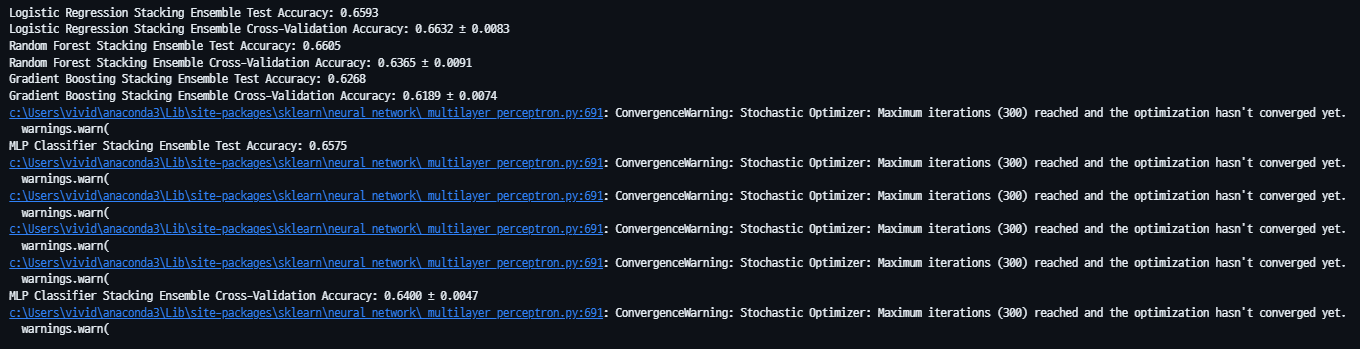